> Dans cette section, nous commencerons par les connaissances et les connaissances acquises grâce à l'analyse exploratoire des données pour proposer de bons ensembles de *features* à l'aide de l'ingénierie des *features*. 

> Une chose à noter ici est que la plupart des features générées sont basées sur la connaissance du domaine et des expérimentations. Sans de bons ensembles de features, les algorithmes d'apprentissage automatique ne peuvent pas produire de résultats efficaces. Par conséquent, nous devrons trouver des moyens ingénieux de faire de l'ingénierie des features pour que le modèle prenne de meilleures décisions.

> En plus de générer des features importantes/utiles, il est également essentiel de supprimer les features redondantes et bruyantes. Si nous alimentons notre modèle d'apprentissage automatique en déchets/bruit, il renverra par conséquent des déchets/bruit. Nous devons donc trouver de bonnes techniques de sélection de features.

# Librairies

In [1]:
#importing Useful DataStructures
import pandas as pd
import numpy as np
from scipy.stats import uniform

#importing plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

#importing Misc Libraries
import os
import gc
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV

#other modelling libraries
from bayes_opt import BayesianOptimization
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

# Les fonctions utiles

In [2]:
def reduce_mem_usage(data, verbose = True):
    #source: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    '''
    This function is used to reduce the memory usage by converting the datatypes of a pandas
    DataFrame withing required limits.
    '''
    
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-'*100)
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('-'*100)
    
    return data

In [3]:
def relational_tables_prepare(file_directory = "../P7_Pret_Credit_Conso_VERGE-DEPRE_Thierry/Projet+Mise+en+prod+-+home-credit-default-risk/", verbose = True):
    '''
    Function to pickle the relational tables which would need to be merged during production with the 
    test datapoint
    
    Inputs:
        file_directory: str, default = ''
            The directory in which files are saved
        verbose: bool, default = True
            Whether to keep verbosity or not
    
    Returns:
        None
    '''
    
    if verbose:
        print("Loading the tables into memory...")
        start = datetime.now()
        
    #loading all the tables in memory, for dimensionality reduction
    with open(file_directory + 'bureau_merged_preprocessed.pkl', 'rb') as f:
        bureau_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'previous_application_preprocessed.pkl', 'rb') as f:
        previous_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'installments_payments_preprocessed.pkl', 'rb') as f:
        installments_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'POS_CASH_balance_preprocessed.pkl', 'rb') as f:
        pos_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'credit_card_balance_preprocessed.pkl', 'rb') as f:
        cc_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'application_train_preprocessed.pkl', 'rb') as f:
        application_train = reduce_mem_usage(pickle.load(f), verbose = False) 
    with open(file_directory + 'application_test_preprocessed.pkl', 'rb') as f:
        application_test = reduce_mem_usage(pickle.load(f), verbose = False)
    with open('Final_XGBOOST_Selected_features.pkl', 'rb') as f:
        final_cols = pickle.load(f)
        
    if verbose:
        print("Done.")
        print(f"Time Elapsed = {datetime.now() - start}")
        start2 = datetime.now()
        print("\nRemoving the non-useful features...")
    #removing non-useful columns from pre-processed previous_application table
    previous_app_columns_to_keep = set(previous_aggregated.columns).intersection(set(final_cols)).union(
                                    set([ele for ele in previous_aggregated.columns if 'AMT_ANNUITY' in ele] + [ele for ele in previous_aggregated.columns if 'AMT_GOODS' in ele]))
    previous_aggregated = previous_aggregated[previous_app_columns_to_keep]
    #removing non-useful columns from pre-processed credit_card_balance table
    credit_card_balance_columns_to_keep = set(cc_aggregated.columns).intersection(set(final_cols)).union(
                                    set([ele for ele in cc_aggregated.columns if 'AMT_RECEIVABLE_PRINCIPAL' in ele] + 
                                        [ele for ele in cc_aggregated.columns if 'AMT_RECIVABLE' in ele] + 
                                        [ele for ele in cc_aggregated.columns if 'TOTAL_RECEIVABLE' in ele] + ['SK_ID_CURR']))
    cc_aggregated = cc_aggregated[credit_card_balance_columns_to_keep]
    #removing non-useful columns from pre-processed installments_payments table
    installments_payments_columns_to_keep = set(installments_aggregated.columns).intersection(set(final_cols)).union(
                                            set([ele for ele in installments_aggregated.columns if 'AMT_PAYMENT' in 
                                                 ele and 'RATIO' not in ele and 'DIFF' not in ele] + ['AMT_INSTALMENT_MEAN_MAX', 'AMT_INSTALMENT_SUM_MAX']))
    installments_aggregated = installments_aggregated[installments_payments_columns_to_keep]
    #removing non-useful columns from pre-processed bureau-aggregated table
    bureau_columns_to_keep =  set(bureau_aggregated.columns).intersection(set(final_cols)).union([ele for ele in bureau_aggregated.columns
                                        if 'DAYS_CREDIT' in ele and 'ENDDATE' not in ele and 'UPDATE' not in ele] + [ele for ele in bureau_aggregated.columns if
                                        'AMT_CREDIT' in ele and 'OVERDUE' in ele] + [ele for ele in bureau_aggregated.columns if 'AMT_ANNUITY' in ele and 'CREDIT'  not in ele])
    bureau_aggregated = bureau_aggregated[bureau_columns_to_keep]
    
    if verbose:
        print("Done.")
        print(f"Time Elapsed = {datetime.now() - start2}")
        print("\nMerging all the tables, and saving to pickle file 'relational_table.pkl'...")

    #merging all the tables
    relational_table = cc_aggregated.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = relational_table.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = relational_table.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = relational_table.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = reduce_mem_usage(relational_table, verbose = False)

    with open(file_directory + 'relational_table.pkl', 'wb') as f:
        pickle.dump(relational_table, f)
    
    if verbose:
        print("Done.")
        print(f"Total Time taken = {datetime.now() - start}")

In [4]:
class modelling:
    '''
    Class for Doing Hyperparameter tuning to find best set of hyperparameters, building models on best hyperparams and
    displaying results on best hyperparameters.
    
    It has 4 methods:
        1. init method
        2. random_search_cv method
        3. train_on_best_params method
        4. proba_to_class method
        5. tune_threshold method
        6. results_on_best_params method
        7. feat_importances_show method
    '''
    def __init__(self, base_model, x_train, y_train, x_test, calibration = False, calibration_method = 'isotonic',
                 calibration_cv = 4, k_folds = 4, random_state = 982):
        '''
        Function to initialize the class members.
        
        Inputs: 
            self
            base_model: estimator/classifier
                The base model to be used for the modelling purpose
            x_train: numpy array
                Training standardized data
            y_train: numpy array
                Training class labels
            x_test: numpy array
                Test standardized data
            calibration: bool, default = False
                Whether to calibrate the model for generating class probabilities
            calibration_method: str, default = 'isotonic'
                The type of calibration to use, i.e. sigmoid or isotonic
            calibration_cv: int, default = 4
                Number of cross-validation folds for calibrating the probabilities
            k_folds: int, default = 4
                Number of cross-validation folds for training and tuning the model
            random_state: int, default = 982
                Random state for StratifiedKFold for reproducibility
                
        Returns: 
            None            
        '''
        self.base_model = base_model
        self.num_folds = k_folds
        self.kfolds = StratifiedKFold(n_splits = k_folds, shuffle = True, random_state = random_state)
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.calibration = calibration
        if self.calibration:
            self.calibration_method = calibration_method
            self.calibration_cv = calibration_cv

    def random_search_cv(self, hyperparams_dict, n_iter = 30, verbose = True, n_jobs = 1, random_state = 843):
        '''
        Function to do RandomizedSearchCV on training data.
        
        Inputs:
            self
            hyperparams_dict: dict
                Dictionary of hyperparameters to tune
            n_iter: int, default = 30
                Number of iterations to perform for random search
            verbose: bool, default = True
                Whether to keep verbosity or not
            n_jobs: int, default = 1
                Number of cores to use for Random Search
            random_state: int, default = 843
                Random state for reproducibility of RandomizedSearchCV
                
        Returns:
            None
        '''
        
        if verbose:
            start = datetime.now()
            print(f"Doing Randomized Search CV on Classifier with {n_iter} random initializations...")
        rscv = RandomizedSearchCV(self.base_model, hyperparams_dict, n_iter = n_iter, scoring = 'roc_auc', 
                                  cv = self.kfolds, return_train_score = True, verbose = 2,
                                  n_jobs = n_jobs, random_state = random_state)
        rscv.fit(self.x_train, self.y_train)
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        
        #getting the Search Results
        self.tuning_results = pd.DataFrame(rscv.cv_results_)
        #best model
        self.best_model = rscv.best_estimator_
        
        gc.collect()
        
    def train_on_best_params(self, verbose = True):
        '''
        Function to train the model on best hyperparameters obtained from previous method.
        Generates Cross-Validation predictions as Out-of-fold predictions
        
        Inputs:
            self
            verbose: bool, default = True
                Whether to keep verbosity or not
        
        Returns:
            None
        '''
        
        if verbose:
            print("Fitting Classifier on best parameters\n")
            print(f"{self.num_folds}-Fold Cross Validation")
            start = datetime.now()
            
        self.cv_preds_probas = np.zeros(self.x_train.shape[0])
        #we will select a best threshold for each fold of cross-validation and average over the
        #folds to find the optimal threshold
        self.best_threshold_train = 0
        for fold_number, (train_indices, val_indices) in enumerate(self.kfolds.split(self.x_train, self.y_train), 1):
            if verbose:
                print(f"\tFitting Fold {fold_number}")
                
            self.best_model.fit(self.x_train[train_indices], self.y_train[train_indices])
            if not self.calibration:
                self.train_preds_probas = self.best_model.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.best_model.predict_proba(self.x_train[val_indices])[:,1]
            else:
                #fitting the calibration Classifier over the base model for calibrated probabilities
                self.calibrated_classifier = CalibratedClassifierCV(self.best_model, method = self.calibration_method, cv = self.calibration_cv)
                self.calibrated_classifier.fit(self.x_train[train_indices], self.y_train[train_indices])
                
                self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.calibrated_classifier.predict_proba(self.x_train[val_indices])[:,1]
            
            #tuning the threshold for optimal TPR and FPR from ROC Curve
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_probas) / self.num_folds
        
        #converting the class probabilities to class labels
        self.cv_preds_class = self.proba_to_class(self.cv_preds_probas, self.best_threshold_train)
        
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
            
        gc.collect()
    
    def proba_to_class(self, proba, threshold):
        '''
        Function to convert a given probability to class label based on a threshold value.
        
        Inputs:
            self
            proba: numpy array
                Probabilities of class label = 1
            threshold: int
                Threshold probability to be considered as Positive or Negative Class Label
            
        Returns:
            Converted Class Label
        '''
        return np.where(proba >= threshold, 1, 0)
        
    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Function to find the optimal threshold for maximizing the TPR and minimizing the FPR from ROC-AUC Curve.
        This is found out by using the J Statistic, which is J = TPR - FPR.
        Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        
        Inputs:
            self
            true_labels: numpy array or pandas series
                True Class Labels
            predicted_probas: numpy array
                Predicted Probability of Positive Class label
            
        Returns:
            Threshold probability.
        '''
        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)
        
        return threshold[index_for_best_threshold]
        
    def results_on_best_params(self, model_name):
        '''
        Function to train the whole data on best parameters and display the results.
        
        Inputs:
            self
            model_name: str
                model name to get feature importances.
        
        Returns:
            None
        '''
        #we have to fit the whole model for optimal test predictions
        self.best_model.fit(self.x_train, self.y_train)
        if not self.calibration:
            self.train_preds_probas = self.best_model.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.best_model.predict_proba(self.x_test)[:,1]
        else:
            #fitting calibration model over whole training data for test predictions
            self.calibrated_classifier.fit(self.x_train, self.y_train)
            self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.calibrated_classifier.predict_proba(self.x_test)[:,1]
        
        #getting class labels from probabilities
        self.train_preds_class = self.proba_to_class(self.train_preds_probas, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_probas, self.best_threshold_train)
        
        #feature importances
        if model_name == 'linear':
            self.feat_imp = self.best_model.coef_[0]
        else:
            self.feat_imp = self.best_model.feature_importances_
                
        print("=" * 100)
        print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {self.best_threshold_train}\n")
        print("Train Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.train_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.train_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.train_preds_class)}")
        print("CV Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.cv_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.cv_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.cv_preds_class)}")

        print('=' * 100)
        print("Confusion Matrix of CV data:")
        conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
        conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
        plt.figure(figsize = (7,6))
        plt.title('Confusion Matrix Heatmap')
        sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
        plt.show()
        
        print('=' * 100)
        print("Distribution of Original Class Labels and Predicted CV and Test Class Labels")
        plt.figure(figsize = (20,6))
        plt.subplot(1,3,1)
        plt.title('Class Distribution of Original Dataset')
        sns.countplot(self.y_train)
        plt.subplot(1,3,2)
        plt.title('Class Distribution of predicted Class Labels on CV')
        sns.countplot(self.cv_preds_class)
        plt.subplot(1,3,3)
        plt.title('Class Distribution of predicted Test Dataset')
        sns.countplot(self.test_preds_class)
        plt.show()
        print('=' * 100)
        
        gc.collect()
        
    def feat_importances_show(self, feature_names, num_features, figsize = (10,15)):
        '''
        Function to display the top most important features.
        
        Inputs:
            self
            feature_names: numpy array
                Names of features of training set
            num_features: int
                Number of top features importances to display
            figsize: tuple, default = (10,15)
                Size of figure to be displayed
            
        Returns:
            None
        '''
        
        #getting the top features indices and their names
        top_feats_indices = np.argsort(self.feat_imp)[::-1][:num_features]
        feat_importance_top = self.feat_imp[top_feats_indices]
        column_names = feature_names[top_feats_indices]
        
        #plotting a horizontal bar plot of feature importances
        plt.figure(figsize = figsize) 
        sns.barplot(feat_importance_top, list(range(num_features)), orient = 'h')
        plt.yticks(list(range(50)), column_names)
        plt.title(f'Top {num_features} features as per classifier')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.grid()
        plt.show()
        print('=' * 100)
        
        gc.collect()

In [5]:
class Boosting:
    '''
    Class for Boosting Ensembles and displaying results. Contains 6 methods:
    
        1. init method
        2. train method
        3. proba_to_class method
        4. tune_threshold method
        5. results method
        6. feat_importance_show
    '''

    def __init__(self, x_train, y_train, x_test, params, num_folds = 3, random_state = 33, verbose = True, save_model_to_pickle = False):
        '''
        Function to initialize the class members.
        
        Inputs:
            self
            x_train: DataFrame
                Training DataFrame
            y_train: DataFrame
                Training Class labels
            x_test: DataFrame
                Test DataFrame
            params: dict
                Parameters for the boosting ensemble
            num_folds: int, default = 3
                Number of folds for k-Fold Cross Validation
            random_state: int, default = 33
                Random State for Splitting the data for K-Fold Cross Validation
            verbose: bool, default = True
                Whether to keep verbosity or not
            save_model_to_pickle: bool, default = False
                Whether to save the model to pickle file or not
        
        Returns:
            None
        '''

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.params = params
        self.num_folds = num_folds
        self.stratified_cv = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = random_state)
        self.verbose = verbose
        self.save_model = save_model_to_pickle
        
    def train(self, booster, verbose = 400, early_stopping = 200, pickle_name = ''):
        '''
        Function to train the Classifier on given parameters. It fits the classifier for each fold, and for Cross Validation,
        uses Out-of-Fold Predictions. The test predictions are averaged predictions over each fold.
        
        Inputs:
            self
            booster: str
                Whether the booster is 'xgboost' or 'lightgbm'
            verbose: int, default = 400
                Number of boosting rounds for printint boosting results.
            early_stopping: int, default = 200
                Number of boosting rounds to look for early stopping
            pickle_name: str, default = ''
                The string to add to end of pickle file of model, if any
        
        Returns:
            None        
        '''
        
        self.train_preds_proba_mean = np.zeros(self.x_train.shape[0])
        #out-of-fold cv predictions
        self.cv_preds_proba = np.zeros(self.x_train.shape[0])
        self.test_preds_proba_mean = np.zeros(self.x_test.shape[0])
        #best threshold will be 
        self.best_threshold_train = 0
        self.feature_importance = pd.DataFrame()
        self.feature_importance['features'] = self.x_train.columns
        self.feature_importance['gain'] = np.zeros(self.x_train.shape[1])
        
        if self.verbose:
            print(f"Fitting the {booster} on Training Data with {self.num_folds} fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation")
            start = datetime.now()
        
        for fold_number, (train_indices, cv_indices) in enumerate(self.stratified_cv.split(self.x_train, self.y_train), 1):
            if self.verbose:
                print(f"\n\tFold Number {fold_number}\n")
            
            x_tr = self.x_train.iloc[train_indices]
            y_tr = self.y_train.iloc[train_indices]
            x_cv = self.x_train.iloc[cv_indices]
            y_cv = self.y_train.iloc[cv_indices]
            
            if booster == 'xgboost':
                clf = XGBClassifier(**self.params)
            else:
                clf = LGBMClassifier(**self.params)
                
            clf.fit(x_tr, y_tr, eval_set = [(x_tr, y_tr), (x_cv, y_cv)], eval_metric = 'auc',
                     verbose = verbose, early_stopping_rounds = 200)
            
            if booster == 'xgboost':
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, ntree_limit = clf.get_booster().best_ntree_limit)[:, 1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, ntree_limit = clf.get_booster().best_ntree_limit)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, ntree_limit = clf.get_booster().best_ntree_limit)[:,1] / self.num_folds

                #feature importance
                gain_fold = clf.get_booster().get_score(importance_type = 'gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = gain_fold.keys()
                feat_imp['gain'] = gain_fold.values()
            
            else:
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, num_iteration = clf.best_iteration_)[:,1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, num_iteration = clf.best_iteration_)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, num_iteration = clf.best_iteration_)[:,1] / self.num_folds

                #feature importance
                gain_fold = clf.booster_.feature_importance(importance_type='gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = self.x_train.columns
                feat_imp['gain'] = gain_fold
            
            #tuning the threshold for optimal TPR and FPR from ROC Curve
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_proba_mean[train_indices]) / self.num_folds
            #concatenating the feature importance of each fold to original df
            self.feature_importance = pd.concat([self.feature_importance, feat_imp], axis = 0)

            if self.save_model:
                #saving the model into a pickle file
                with open(f'clf_{booster}_fold_{fold_number}_model_{pickle_name}.pkl', 'wb') as f:
                    pickle.dump(clf, f)
          
        #mean feature importance averaged over all folds
        self.feature_importance = self.feature_importance.groupby('features', as_index = False).mean()
        #sorting the feature importance
        self.feature_importance = self.feature_importance.sort_values(by = 'gain', ascending = False)
        
        if self.verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        gc.collect()
        
    def proba_to_class(self, proba, threshold):
        '''
        Function to convert a given probability to class label based on a threshold value.
        
        Inputs:
            self
            proba: numpy array
                Probabilities of class label = 1
            threshold: int
                Threshold probability to be considered as Positive or Negative Class Label
            
        Returns:
            Converted Class Label
        '''

        return np.where(proba >= threshold, 1, 0)
        
    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Function to find the optimal threshold for maximizing the TPR and minimizing the FPR from ROC-AUC Curve.
        This is found out by using the J Statistic, which is J = TPR - FPR.
        Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        
        Inputs:
            self
            true_labels: numpy array or pandas series
                True Class Labels
            predicted_probas: numpy array
                Predicted Probability of Positive Class label
            
        Returns:
            Threshold probability.
        '''

        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)
        
        return threshold[index_for_best_threshold]
           
    def results(self, roc_auc = True, precision_recall = True, confusion_matrix = True, cv_test_distribution = False):
        '''
        Function to display the final results of Train, CV and Test Dataset.
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        #getting the crisp class labels
        self.train_preds_class = self.proba_to_class(self.train_preds_proba_mean, self.best_threshold_train)
        self.cv_preds_class = self.proba_to_class(self.cv_preds_proba, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_proba_mean, self.best_threshold_train)
        print("=" * 100)
        print("Train Results:")
        print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {self.best_threshold_train}\n")
        if roc_auc:
            print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.train_preds_proba_mean)}")
        if precision_recall:
            print(f"\tPrecision Score = {precision_score(self.y_train, self.train_preds_class)}")
            print(f"\tRecall Score = {recall_score(self.y_train, self.train_preds_class)}")
        print("CV Results:")
        if roc_auc:
            print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.cv_preds_proba)}")
        if precision_recall:
            print(f"\tPrecision Score = {precision_score(self.y_train, self.cv_preds_class)}")
            print(f"\tRecall Score = {recall_score(self.y_train, self.cv_preds_class)}")

        if confusion_matrix:
            print('=' * 100)
            print("Confusion, Precision and Recall Matrix on CV data:")
            #conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
            conf_mat = confusion_matrix(target_train, np.where(self.cv_preds_proba))
            conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
            
            #conf_mat = confusion_matrix(target_train, np.round(predicted_proba_train)) # exemple
            
            plt.figure(figsize = (7,6))
            plt.title('Confusion Matrix Heatmap')
            sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
            plt.show()
        
        if cv_test_distribution:
            print('=' * 100)
            print("Distribution of Original Class Labels and Predicted CV and Test Class Labels")
            plt.figure(figsize = (20,6))
            plt.subplot(1,3,1)
            plt.title('Class Distribution of Original Dataset')
            sns.countplot(self.y_train)
            plt.subplot(1,3,2)
            plt.title('Class Distribution of predicted Class Labels on CV')
            sns.countplot(self.cv_preds_class)
            plt.subplot(1,3,3)
            plt.title('Class Distribution of predicted Test Dataset')
            sns.countplot(self.test_preds_class)
            plt.show()
        print('=' * 100)
        
        gc.collect()
    
    def feat_importances_show(self, num_features, figsize = (10,15)):
        '''
        Function to display the top most important features.
        
        Inputs:
            self
            num_features: int
                Number of top features importances to display
            figsize: tuple, default = (10,15)
                Size of figure to be displayed
            
        Returns:
            None
        '''
        
        plt.figure(figsize = figsize) 
        sns.barplot(self.feature_importance['gain'].iloc[:num_features], self.feature_importance['features'].iloc[:num_features], orient = 'h')
        plt.title(f'Top {num_features} features as per classifier')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.grid()
        plt.show()
        print('=' * 100)
        
        gc.collect()

# Data Cleaning and Feature Engineering

In [6]:
number_of_rows = 10000

## Bureau & Bureau_balance

__Tableaux de prétraitement__

> bureau_balance.csv et bureau.csv
> Ces tableaux contiennent les informations relatives aux crédits antérieurs du client qui n'étaient pas avec Home Credit Group, et ont été rapportés par le département du bureau de crédit.

__bureau_balance__
Tout d'abord, la table bureau_balance contient trois champs, à savoir SK_ID_BUREAU, MONTHS_BALANCE et STATUS.
Étant donné que le statut suit un comportement quelque peu ordinal, nous commençons par l'encoder par étiquette.
Ensuite, certaines fonctionnalités sont créées telles que le statut pondéré, qui est obtenu en divisant le statut par MONTHS_BALANCE.
Étant donné que les données contiennent les séries temporelles, nous calculons également la moyenne mobile pondérée exponentielle des champs Statut et Statut pondéré.
Enfin, nous agrégeons les données sur SK_ID_BUREAU, de telle sorte que nous les agrégeons d'abord sur toutes les données, puis nous agrégeons également sur les 2 dernières années. Ces 2 années représenteraient le comportement le plus récent des clients.
Les agrégations effectuées sont basées sur la connaissance du domaine, telles que la moyenne, le min, le max, la somme, le nombre, etc. Pour les fonctionnalités EDA, nous ne prenons que les dernières/plus récentes valeurs, car elles contiennent quelque peu la tendance de toutes les valeurs précédentes.

__bureau__
Tout d'abord, nous fusionnons la table bureau avec la table agrégée bureau_balance de l'étape précédente, sur SK_ID_BUREAU.
Nous remplaçons certaines valeurs erronées par des valeurs NaN. Nous avons vu des prêts remontant jusqu'à 100 ans. Nous pensons qu'ils ne diraient pas grand-chose sur le comportement récent du client, alors nous les supprimons et ne conservons les prêts que sur une période de 50 ans.
Nous créons certaines caractéristiques par multiplications, divisions, soustractions de caractéristiques brutes, basées sur la connaissance du domaine, telles que la durée du crédit, le ratio annuité/crédit, etc.
Les caractéristiques catégorielles sont codées à chaud.
Pour les fusionner avec la table principale, c'est-à-dire application_train, nous agrégeons cette table sur SK_ID_CURR. Nous effectuons à nouveau les agrégations de deux manières. Nous agrégeons les crédits en fonction de la catégorie CREDIT_ACTIVE, où nous agrégeons séparément les deux catégories les plus populaires, à savoir Actif et Fermé. Plus tard, nous agrégeons également les catégories restantes et les fusionnons. Nous avons également agrégé l'ensemble des données. Les agrégations effectuées sont somme, moyenne, min, max, dernier, etc.

In [7]:
class preprocess_bureau_balance_and_bureau:
    '''
    Preprocess the tables bureau_balance and bureau.
    Contains 4 member functions:
        1. init method
        2. preprocess_bureau_balance method
        3. preprocess_bureau method
        4. main method
    '''
    
    def __init__(self, file_directory = "../P7_Pret_Credit_Conso_VERGE-DEPRE_Thierry/Projet+Mise+en+prod+-+home-credit-default-risk/", verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
        self.start = datetime.now()
        
    def preprocess_bureau_balance(self):
        '''
        Function to preprocess bureau_balance table.
        This function first loads the table into memory, does some feature engineering, and finally
        aggregates the data over SK_ID_BUREAU
        
        Inputs:
            self
            
        Returns:
            preprocessed and aggregated bureau_balance table.
        '''
        
        if self.verbose:
            print('#######################################################')
            print('#          Pre-processing bureau_balance.csv          #')
            print('#######################################################')
            print("\nLoading the DataFrame, bureau_balance.csv, into memory...")

        #bureau_balance = pd.read_csv(self.file_directory + 'bureau_balance.csv')
        df1 = pd.read_csv(self.file_directory + 'bureau_balance.csv')
        #number_of_rows = 10000
        bureau_balance = df1.head(number_of_rows)

        if self.verbose:
            print("Loaded bureau_balance.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
            print("\nStarting Data Cleaning and Feature Engineering...")

        #as we saw from EDA, bureau_balance has a variable called STATUS, which describes about the status of loan.
        #it has 7 labels, we will label encode them
        #so we give C as 0, and rest increasing
        #also we will give X the benefit of doubt and keep it as middle value
        dict_for_status = { 'C': 0, '0': 1, '1': 2, '2': 3, 'X': 4, '3': 5, '4': 6, '5': 7}
        bureau_balance['STATUS'] = bureau_balance['STATUS'].map(dict_for_status)

        #weighing the status with the months_balance
        #converting months to positive
        bureau_balance['MONTHS_BALANCE'] = np.abs(bureau_balance['MONTHS_BALANCE'])
        bureau_balance['WEIGHTED_STATUS'] = bureau_balance.STATUS / (bureau_balance.MONTHS_BALANCE + 1)

        #sorting the bureau_balance in ascending order of month and by the bureau SK_ID
        #this is done so as to make the rolling exponential average easily for previous months till current month
        bureau_balance = bureau_balance.sort_values(by=['SK_ID_BUREAU', 'MONTHS_BALANCE'], ascending=[0, 0])
        #we will do exponential weighted average on the encoded status
        #this is because if a person had a bad status 2 years ago, it should be given less weightage today
        # we keep the latent variable alpha = 0.8 
        #doing this for both weighted status and the status itself
        bureau_balance['EXP_WEIGHTED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['WEIGHTED_STATUS'].transform(lambda x: x.ewm(alpha = 0.8).mean())
        bureau_balance['EXP_ENCODED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].transform(lambda x: x.ewm(alpha = 0.8).mean())    

        if self.verbose:
            print("Halfway through. A little bit more patience...")
            print(f"Total Time Elapsed = {datetime.now() - self.start}")

        #we can see that these datapoints are for 96 months i.e. 8 years.
        #so we will extract the means, and exponential averages for each year separately
        #first we convert month to year
        bureau_balance['MONTHS_BALANCE'] = bureau_balance['MONTHS_BALANCE'] // 12

        #defining our aggregations
        aggregations_basic = {
            'MONTHS_BALANCE' : ['mean','max'],
            'STATUS' : ['mean','max','first'],
            'WEIGHTED_STATUS' : ['mean','sum','first'],
            'EXP_ENCODED_STATUS' : ['last'],
            'EXP_WEIGHTED_STATUS' : ['last']}

        #we will be finding aggregates for each year too
        aggregations_for_year = {
            'STATUS' : ['mean','max','last','first'],
            'WEIGHTED_STATUS' : ['mean','max', 'first','last'],
            'EXP_WEIGHTED_STATUS' : ['last'],
            'EXP_ENCODED_STATUS' : ['last'] }

        #aggregating over whole dataset first
        aggregated_bureau_balance = bureau_balance.groupby(['SK_ID_BUREAU']).agg(aggregations_basic)
        aggregated_bureau_balance.columns = ['_'.join(ele).upper() for ele in aggregated_bureau_balance.columns]

        #aggregating some of the features separately for latest 2 years
        aggregated_bureau_years = pd.DataFrame()
        for year in range(2):
            year_group = bureau_balance[bureau_balance['MONTHS_BALANCE'] == year].groupby('SK_ID_BUREAU').agg(aggregations_for_year)
            year_group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in year_group.columns]

            if year == 0:
                aggregated_bureau_years = year_group
            else:
                aggregated_bureau_years = aggregated_bureau_years.merge(year_group, on = 'SK_ID_BUREAU', how = 'outer')

        #aggregating for rest of the years
        aggregated_bureau_rest_years = bureau_balance[bureau_balance.MONTHS_BALANCE > year].groupby(['SK_ID_BUREAU']).agg(aggregations_for_year)
        aggregated_bureau_rest_years.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in aggregated_bureau_rest_years.columns]

        #merging with rest of the years
        aggregated_bureau_years = aggregated_bureau_years.merge(aggregated_bureau_rest_years, on = 'SK_ID_BUREAU', how = 'outer')
        aggregated_bureau_balance = aggregated_bureau_balance.merge(aggregated_bureau_years, on = 'SK_ID_BUREAU', how = 'inner')

        #filling the missing values obtained after aggregations with 0
        aggregated_bureau_balance.fillna(0, inplace = True)

        if self.verbose:
            print('Done preprocessing bureau_balance.')
            print(f"\nInitial Size of bureau_balance: {bureau_balance.shape}")
            print(f'Size of bureau_balance after Pre-Processing, Feature Engineering and Aggregation: {aggregated_bureau_balance.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed bureau_balance to bureau_balance_preprocessed.pkl')
            with open(self.file_directory + 'bureau_balance_preprocessed.pkl', 'wb') as f:
                pickle.dump(aggregated_bureau_balance, f)
            if self.verbose:
                print('Done.')     
        
        return aggregated_bureau_balance
    
    def preprocess_bureau(self, aggregated_bureau_balance):
        '''
        Function to preprocess the bureau table and merge it with the aggregated bureau_balance table.
        Finally aggregates the data over SK_ID_CURR for it to be merged with application_train table.
        
        Inputs:
            self
            aggregated_bureau_balance: DataFrame of aggregated bureau_balance table
        
        Returns:
            Final preprocessed, merged and aggregated bureau table
        '''
        
        if self.verbose:
            start2 = datetime.now()
            print('\n##############################################')
            print('#          Pre-processing bureau.csv         #')
            print('##############################################')
            print("\nLoading the DataFrame, bureau.csv, into memory...")

        #bureau = pd.read_csv('bureau.csv')
        df2 = pd.read_csv(self.file_directory + 'bureau.csv')
        #number_of_rows = 10000
        bureau = df2.head(number_of_rows)

        if self.verbose:
            print("Loaded bureau.csv")
            print(f"Time Taken to load = {datetime.now() - start2}")
            print("\nStarting Data Cleaning and Feature Engineering...")

        #merging it with aggregated bureau_balance on 'SK_ID_BUREAU'
        bureau_merged = bureau.merge(aggregated_bureau_balance, on = 'SK_ID_BUREAU', how = 'left')

        #from the EDA we saw some erroneous values in DAYS Fields, we will remove those
        #there are some loans which ended about very long ago, around 100 years ago.
        #Thus we will only keep those loans which have ended in past 50 years.
        bureau_merged['DAYS_CREDIT_ENDDATE'][bureau_merged['DAYS_CREDIT_ENDDATE'] > -50*365] = np.nan
        bureau_merged['DAYS_ENDDATE_FACT'][bureau_merged['DAYS_ENDDATE_FACT'] > -50*365] = np.nan
        #there is also a feature which tells about the number of days ago the Credit Report Came
        bureau_merged['DAYS_CREDIT_UPDATE'][bureau_merged['DAYS_CREDIT_UPDATE'] > -50*365] = np.nan
        
        #engineering some features based on domain knowledge
        bureau_merged['CREDIT_DURATION'] = np.abs(bureau_merged['DAYS_CREDIT'] - bureau_merged['DAYS_CREDIT_ENDDATE'])
        bureau_merged['FLAG_OVERDUE_RECENT'] = [0 if ele == 0 else 1 for ele in bureau_merged['CREDIT_DAY_OVERDUE']]
        bureau_merged['MAX_AMT_OVERDUE_DURATION_RATIO'] = bureau_merged['AMT_CREDIT_MAX_OVERDUE'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
        bureau_merged['CURRENT_AMT_OVERDUE_DURATION_RATIO'] = bureau_merged['AMT_CREDIT_SUM_OVERDUE'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
        bureau_merged['AMT_OVERDUE_DURATION_LEFT_RATIO'] = bureau_merged['AMT_CREDIT_SUM_OVERDUE'] / (bureau_merged['DAYS_CREDIT_ENDDATE'] + 0.00001)
        bureau_merged['CNT_PROLONGED_MAX_OVERDUE_MUL'] = bureau_merged['CNT_CREDIT_PROLONG'] * bureau_merged['AMT_CREDIT_MAX_OVERDUE']
        bureau_merged['CNT_PROLONGED_DURATION_RATIO'] = bureau_merged['CNT_CREDIT_PROLONG'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
        bureau_merged['CURRENT_DEBT_TO_CREDIT_RATIO'] = bureau_merged['AMT_CREDIT_SUM_DEBT'] / (bureau_merged['AMT_CREDIT_SUM'] + 0.00001)
        bureau_merged['CURRENT_CREDIT_DEBT_DIFF'] = bureau_merged['AMT_CREDIT_SUM'] - bureau_merged['AMT_CREDIT_SUM_DEBT']
        bureau_merged['AMT_ANNUITY_CREDIT_RATIO'] = bureau_merged['AMT_ANNUITY'] / (bureau_merged['AMT_CREDIT_SUM'] + 0.00001)
        bureau_merged['CREDIT_ENDDATE_UPDATE_DIFF'] = np.abs(bureau_merged['DAYS_CREDIT_UPDATE'] - bureau_merged['DAYS_CREDIT_ENDDATE'])

        #now we will be aggregating the bureau_merged df with respect to 'SK_ID_CURR' so as to merge it with application_train later    
        #firstly we will aggregate the columns based on the category of CREDIT_ACTIVE
        aggregations_CREDIT_ACTIVE = {
                        'DAYS_CREDIT' : ['mean','min','max','last'],
                        'CREDIT_DAY_OVERDUE' : ['mean','max'],
                        'DAYS_CREDIT_ENDDATE' : ['mean','max'],
                        'DAYS_ENDDATE_FACT' : ['mean','min'],
                        'AMT_CREDIT_MAX_OVERDUE': ['max','sum'],
                        'CNT_CREDIT_PROLONG': ['max','sum'],
                        'AMT_CREDIT_SUM' : ['sum','max'],
                        'AMT_CREDIT_SUM_DEBT': ['sum'],
                        'AMT_CREDIT_SUM_LIMIT': ['max','sum'],
                        'AMT_CREDIT_SUM_OVERDUE': ['max','sum'],
                        'DAYS_CREDIT_UPDATE' : ['mean','min'],
                        'AMT_ANNUITY' : ['mean','sum','max'],
                        'CREDIT_DURATION' : ['max','mean'],
                        'FLAG_OVERDUE_RECENT': ['sum'],
                        'MAX_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                        'CURRENT_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                        'AMT_OVERDUE_DURATION_LEFT_RATIO' : ['max', 'mean'],
                        'CNT_PROLONGED_MAX_OVERDUE_MUL' : ['mean','max'],
                        'CNT_PROLONGED_DURATION_RATIO' : ['mean', 'max'],
                        'CURRENT_DEBT_TO_CREDIT_RATIO' : ['mean', 'min'],
                        'CURRENT_CREDIT_DEBT_DIFF' : ['mean','min'],
                        'AMT_ANNUITY_CREDIT_RATIO' : ['mean','max','min'],
                        'CREDIT_ENDDATE_UPDATE_DIFF' : ['max','min'],
                        'STATUS_MEAN' : ['mean', 'max'],
                        'WEIGHTED_STATUS_MEAN' : ['mean', 'max']
                         }

        #we saw from EDA that the two most common type of CREDIT ACTIVE were 'Closed' and 'Active'.
        #So we will aggregate them two separately and the remaining categories separately.
        categories_to_aggregate_on = ['Closed','Active']
        bureau_merged_aggregated_credit = pd.DataFrame()
        for i, status in enumerate(categories_to_aggregate_on):
            group = bureau_merged[bureau_merged['CREDIT_ACTIVE'] == status].groupby('SK_ID_CURR').agg(aggregations_CREDIT_ACTIVE)
            group.columns = ['_'.join(ele).upper() + '_CREDITACTIVE_' + status.upper() for ele in group.columns]

            if i==0:
                bureau_merged_aggregated_credit = group
            else:
                bureau_merged_aggregated_credit = bureau_merged_aggregated_credit.merge(group, on = 'SK_ID_CURR', how = 'outer')
        #aggregating for remaining categories
        bureau_merged_aggregated_credit_rest = bureau_merged[(bureau_merged['CREDIT_ACTIVE'] != 'Active') & 
                                                             (bureau_merged['CREDIT_ACTIVE'] != 'Closed')].groupby('SK_ID_CURR').agg(aggregations_CREDIT_ACTIVE)
        bureau_merged_aggregated_credit_rest.columns = ['_'.join(ele).upper() + 'CREDIT_ACTIVE_REST' for ele in bureau_merged_aggregated_credit_rest.columns]

        #merging with other categories
        bureau_merged_aggregated_credit = bureau_merged_aggregated_credit.merge(bureau_merged_aggregated_credit_rest, on = 'SK_ID_CURR', how = 'outer')

        #Encoding the categorical columns in one-hot form
        currency_ohe = pd.get_dummies(bureau_merged['CREDIT_CURRENCY'], prefix = 'CURRENCY')
        credit_active_ohe = pd.get_dummies(bureau_merged['CREDIT_ACTIVE'], prefix = 'CREDIT_ACTIVE')
        credit_type_ohe = pd.get_dummies(bureau_merged['CREDIT_TYPE'], prefix = 'CREDIT_TYPE')

        #merging the one-hot encoded columns
        bureau_merged = pd.concat([bureau_merged.drop(['CREDIT_CURRENCY','CREDIT_ACTIVE','CREDIT_TYPE'], axis = 1), 
                                   currency_ohe, credit_active_ohe, credit_type_ohe], axis = 1)

        #aggregating the bureau_merged over all the columns
        bureau_merged_aggregated = bureau_merged.drop('SK_ID_BUREAU', axis = 1).groupby('SK_ID_CURR').agg('mean')
        bureau_merged_aggregated.columns = [ele + '_MEAN_OVERALL' for ele in bureau_merged_aggregated.columns]
        #merging it with aggregates over categories
        bureau_merged_aggregated = bureau_merged_aggregated.merge(bureau_merged_aggregated_credit, on = 'SK_ID_CURR', how = 'outer')

        if self.verbose:
            print('Done preprocessing bureau and bureau_balance.')
            print(f"\nInitial Size of bureau: {bureau.shape}")
            print(f'Size of bureau and bureau_balance after Merging, Pre-Processing, Feature Engineering and Aggregation: {bureau_merged_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed bureau and bureau_balance to bureau_merged_preprocessed.pkl')
            with open(self.file_directory + 'bureau_merged_preprocessed.pkl', 'wb') as f:
                pickle.dump(bureau_merged_aggregated, f)
            if self.verbose:
                print('Done.')  
        if self.verbose:
            print('-'*100)

        return bureau_merged_aggregated
    
    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of the bureau and bureau_balance tables.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed and merged bureau and burea_balance tables
        '''
        
        #preprocessing the bureau_balance first
        aggregated_bureau_balance = self.preprocess_bureau_balance()
        #preprocessing the bureau table next, by combining it with the aggregated bureau_balance
        bureau_merged_aggregated = self.preprocess_bureau(aggregated_bureau_balance)
        
        return bureau_merged_aggregated

In [8]:
bureau_aggregated = preprocess_bureau_balance_and_bureau(dump_to_pickle = True).main()

#######################################################
#          Pre-processing bureau_balance.csv          #
#######################################################

Loading the DataFrame, bureau_balance.csv, into memory...
Loaded bureau_balance.csv
Time Taken to load = 0:00:11.086654

Starting Data Cleaning and Feature Engineering...
Halfway through. A little bit more patience...
Total Time Elapsed = 0:00:12.060584
Done preprocessing bureau_balance.

Initial Size of bureau_balance: (10000, 6)
Size of bureau_balance after Pre-Processing, Feature Engineering and Aggregation: (273, 40)

Total Time Taken = 0:00:12.454682

Pickling pre-processed bureau_balance to bureau_balance_preprocessed.pkl
Done.

##############################################
#          Pre-processing bureau.csv         #
##############################################

Loading the DataFrame, bureau.csv, into memory...
Loaded bureau.csv
Time Taken to load = 0:00:04.327482

Starting Data Cleaning and Feature Engineer

## Previous Application (previous_application.csv)

Ce tableau contient les données statiques relatives aux clients et à leurs crédits antérieurs avec Home Credit Group.

Tout d'abord, nous commençons par nettoyer les valeurs erronées. Dans l'EDA, nous avons vu des champs DAYS avec une valeur égale à 365243.0, ils semblent erronés, et nous les remplacerons donc par des valeurs NaN.
Nous remplaçons les valeurs NaN pour les catégories par une catégorie « XNA ».
Ensuite, nous procédons à l'ingénierie des fonctionnalités, où nous créons des fonctionnalités basées sur le domaine, telles que le ratio crédit-acompte, le montant non approuvé, le ratio crédit/marchandises, etc.
Nous essayons également de prédire le taux d'intérêt, inspiré par l'une des écritures des gagnants.
Pour pouvoir le fusionner avec la table principale, nous devons agréger les lignes de previous_application sur SK_ID_CURR. Nous effectuons des agrégations basées sur le domaine, sur tous les crédits précédents pour chaque client, tels que la moyenne, le max, le min, etc. Ici encore, nous agrégeons de trois manières. Nous effectuons d'abord une agrégation globale, puis nous agrégeons pour les 2 premières applications et les 5 dernières applications. Le premier et le dernier sont décidés par les DAYS_FIRST_DUE des candidatures. En fin de compte, nous fusionnons toutes ces agrégations ensemble.

In [9]:
class preprocess_previous_application:
    '''
    Preprocess the previous_application table.
    Contains 5 member functions:
        1. init method
        2. load_dataframe method
        3. data_cleaning method
        4. preprocessing_feature_engineering method
        5. main method
    '''
    
    def __init__(self, file_directory = "../P7_Pret_Credit_Conso_VERGE-DEPRE_Thierry/Projet+Mise+en+prod+-+home-credit-default-risk/" , verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
    
    def load_dataframe(self):
        '''
        Function to load the previous_application.csv DataFrame.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            self.start = datetime.now()
            print('########################################################')
            print('#        Pre-processing previous_application.csv        #')
            print('########################################################')
            print("\nLoading the DataFrame, previous_application.csv, into memory...")

        #loading the DataFrame into memory
        #self.previous_application = pd.read_csv(self.file_directory + 'previous_application.csv')
        df3 = pd.read_csv(self.file_directory + 'previous_application.csv')
        #number_of_rows = 10000
        self.previous_application = df3.head(number_of_rows)
        
        self.initial_shape = self.previous_application.shape

        if self.verbose:
            print("Loaded previous_application.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
    
    def data_cleaning(self):
        '''
        Function to clean the data. Removes erroneous points, fills categorical NaNs with 'XNA'.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print('\nStarting Data Cleaning...')
            
        #sorting the applications from oldest to most recent previous loans for each user
        self.previous_application = self.previous_application.sort_values(by = ['SK_ID_CURR','DAYS_FIRST_DUE'])
        
        #in the EDA we found some erroneous values in DAYS columns, so we will replace them with NaN values
        self.previous_application['DAYS_FIRST_DRAWING'][self.previous_application['DAYS_FIRST_DRAWING'] == 365243.0] = np.nan
        self.previous_application['DAYS_FIRST_DUE'][self.previous_application['DAYS_FIRST_DUE'] == 365243.0] = np.nan
        self.previous_application['DAYS_LAST_DUE_1ST_VERSION'][self.previous_application['DAYS_LAST_DUE_1ST_VERSION'] == 365243.0] = np.nan
        self.previous_application['DAYS_LAST_DUE'][self.previous_application['DAYS_LAST_DUE'] == 365243.0] = np.nan
        self.previous_application['DAYS_TERMINATION'][self.previous_application['DAYS_TERMINATION'] == 365243.0] = np.nan
        #we also see abruptly large value for SELLERPLACE_AREA
        self.previous_application['SELLERPLACE_AREA'][self.previous_application['SELLERPLACE_AREA'] == 4000000] = np.nan
        #filling the NaN values for categories
        categorical_columns = self.previous_application.dtypes[self.previous_application.dtypes == 'object'].index.tolist()
        self.previous_application[categorical_columns] = self.previous_application[categorical_columns].fillna('XNA')
        
        if self.verbose:
            print("Done.")
            print(f"Time taken = {datetime.now() - start}")

    def preprocessing_feature_engineering(self):
        '''
        Function to do preprocessing such as categorical encoding and feature engineering.
        
        Inputs: 
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nPerforming Preprocessing and Feature Engineering...")

        #label encoding the categorical variables
        name_contract_dict = {'Approved': 0, 'Refused' : 3, 'Canceled' : 2, 'Unused offer' : 1}
        self.previous_application['NAME_CONTRACT_STATUS'] = self.previous_application['NAME_CONTRACT_STATUS'].map(name_contract_dict)
        yield_group_dict = {'XNA': 0, 'low_action': 1, 'low_normal': 2,'middle': 3, 'high': 4}
        self.previous_application['NAME_YIELD_GROUP'] = self.previous_application['NAME_YIELD_GROUP'].map(yield_group_dict)
        appl_per_contract_last_dict = {'Y':1, 'N':0}
        self.previous_application['FLAG_LAST_APPL_PER_CONTRACT'] = self.previous_application['FLAG_LAST_APPL_PER_CONTRACT'].map(appl_per_contract_last_dict)
        remaining_categorical_columns = self.previous_application.dtypes[self.previous_application.dtypes == 'object'].index.tolist()
        for col in remaining_categorical_columns:
            encoding_dict = dict([(j,i) for i,j in enumerate(self.previous_application[col].unique(),1)])
            self.previous_application[col] = self.previous_application[col].map(encoding_dict)    
        
        #engineering some features on domain knowledge
        self.previous_application['MISSING_VALUES_TOTAL_PREV'] = self.previous_application.isna().sum(axis = 1)
        self.previous_application['AMT_DECLINED'] = self.previous_application['AMT_APPLICATION'] - self.previous_application['AMT_CREDIT']
        self.previous_application['AMT_CREDIT_GOODS_RATIO'] = self.previous_application['AMT_CREDIT'] / (self.previous_application['AMT_GOODS_PRICE'] + 0.00001)
        self.previous_application['AMT_CREDIT_GOODS_DIFF'] = self.previous_application['AMT_CREDIT'] - self.previous_application['AMT_GOODS_PRICE']
        self.previous_application['AMT_CREDIT_APPLICATION_RATIO'] = self.previous_application['AMT_APPLICATION'] / (self.previous_application['AMT_CREDIT'] + 0.00001)
        self.previous_application['CREDIT_DOWNPAYMENT_RATIO'] = self.previous_application['AMT_DOWN_PAYMENT'] / (self.previous_application['AMT_CREDIT'] + 0.00001)
        self.previous_application['GOOD_DOWNPAYMET_RATIO'] = self.previous_application['AMT_DOWN_PAYMENT'] / (self.previous_application['AMT_GOODS_PRICE'] + 0.00001)
        self.previous_application['INTEREST_DOWNPAYMENT'] = self.previous_application['RATE_DOWN_PAYMENT'] * self.previous_application['AMT_DOWN_PAYMENT']
        self.previous_application['INTEREST_CREDIT'] = self.previous_application['AMT_CREDIT'] * self.previous_application['RATE_INTEREST_PRIMARY']
        self.previous_application['INTEREST_CREDIT_PRIVILEGED'] = self.previous_application['AMT_CREDIT'] * self.previous_application['RATE_INTEREST_PRIVILEGED']
        self.previous_application['APPLICATION_AMT_TO_DECISION_RATIO'] = self.previous_application['AMT_APPLICATION'] / (self.previous_application['DAYS_DECISION'] + 0.00001) * -1
        self.previous_application['AMT_APPLICATION_TO_SELLERPLACE_AREA'] = self.previous_application['AMT_APPLICATION'] / (self.previous_application['SELLERPLACE_AREA'] + 0.00001)
        self.previous_application['ANNUITY'] = self.previous_application['AMT_CREDIT'] / (self.previous_application['CNT_PAYMENT'] + 0.00001)
        self.previous_application['ANNUITY_GOODS'] = self.previous_application['AMT_GOODS_PRICE'] / (self.previous_application['CNT_PAYMENT'] + 0.00001)
        self.previous_application['DAYS_FIRST_LAST_DUE_DIFF' ] = self.previous_application['DAYS_LAST_DUE'] - self.previous_application['DAYS_FIRST_DUE']
        self.previous_application['AMT_CREDIT_HOUR_PROCESS_START'] = self.previous_application['AMT_CREDIT'] * self.previous_application['HOUR_APPR_PROCESS_START']
        self.previous_application['AMT_CREDIT_NFLAG_LAST_APPL_DAY'] = self.previous_application['AMT_CREDIT'] * self.previous_application['NFLAG_LAST_APPL_IN_DAY']
        self.previous_application['AMT_CREDIT_YIELD_GROUP'] = self.previous_application['AMT_CREDIT'] * self.previous_application['NAME_YIELD_GROUP']
        #https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
        self.previous_application['AMT_INTEREST'] = self.previous_application['CNT_PAYMENT'] * self.previous_application[
                                                'AMT_ANNUITY'] - self.previous_application['AMT_CREDIT'] 
        self.previous_application['INTEREST_SHARE'] = self.previous_application['AMT_INTEREST'] / (self.previous_application[
                                                                                                'AMT_CREDIT'] + 0.00001)
        self.previous_application['INTEREST_RATE'] = 2 * 12 * self.previous_application['AMT_INTEREST'] / (self.previous_application[
                                            'AMT_CREDIT'] * (self.previous_application['CNT_PAYMENT'] + 1))
        
        if self.verbose:
            print("Done.")
            print(f"Time taken = {datetime.now() - start}")
    
    def aggregations(self):
        '''
        Function to aggregate the previous applications over SK_ID_CURR
        
        Inputs:
            self
        
        Returns:
            aggregated previous_applications
        '''
        
        if self.verbose:
            print("\nAggregating previous applications over SK_ID_CURR...")
            
        aggregations_for_previous_application = {
            'MISSING_VALUES_TOTAL_PREV' : ['sum'],
            'NAME_CONTRACT_TYPE' : ['mean','last'],
            'AMT_ANNUITY' : ['mean','sum','max'],
            'AMT_APPLICATION' : ['mean','max','sum'],
            'AMT_CREDIT' : ['mean','max','sum'],
            'AMT_DOWN_PAYMENT' : ['mean','max','sum'],
            'AMT_GOODS_PRICE' : ['mean','max','sum'],
            'WEEKDAY_APPR_PROCESS_START' : ['mean','max','min'],
            'HOUR_APPR_PROCESS_START' : ['mean','max','min'],
            'FLAG_LAST_APPL_PER_CONTRACT' : ['mean','sum'],
            'NFLAG_LAST_APPL_IN_DAY' : ['mean','sum'],
            'RATE_DOWN_PAYMENT' : ['mean','max'],
            'RATE_INTEREST_PRIMARY' : ['mean','max'],
            'RATE_INTEREST_PRIVILEGED' : ['mean','max'],
            'NAME_CASH_LOAN_PURPOSE' : ['mean','last'],
            'NAME_CONTRACT_STATUS' : ['mean','max','last'],
            'DAYS_DECISION' : ['mean','max','min'],
            'NAME_PAYMENT_TYPE' : ['mean', 'last'],
            'CODE_REJECT_REASON' : ['mean','last'],
            'NAME_TYPE_SUITE' : ['mean','last'],
            'NAME_CLIENT_TYPE' : ['mean','last'],
            'NAME_GOODS_CATEGORY' : ['mean','last'],
            'NAME_PORTFOLIO' : ['mean','last'],
            'NAME_PRODUCT_TYPE' : ['mean','last'],
            'CHANNEL_TYPE' : ['mean','last'],
            'SELLERPLACE_AREA' : ['mean','max','min'],
            'NAME_SELLER_INDUSTRY' : ['mean','last'],
            'CNT_PAYMENT' : ['sum','mean','max'],
            'NAME_YIELD_GROUP' : ['mean','last'],
            'PRODUCT_COMBINATION' : ['mean', 'last'],
            'DAYS_FIRST_DRAWING' : ['mean','max'],
            'DAYS_FIRST_DUE' : ['mean','max'],
            'DAYS_LAST_DUE_1ST_VERSION' : ['mean'],
            'DAYS_LAST_DUE' : ['mean'],
            'DAYS_TERMINATION' : ['mean','max'],
            'NFLAG_INSURED_ON_APPROVAL' : ['sum'],
            'AMT_DECLINED' : ['mean','max','sum'],
            'AMT_CREDIT_GOODS_RATIO' : ['mean', 'max', 'min'],
            'AMT_CREDIT_GOODS_DIFF' : ['sum','mean','max', 'min'],
            'AMT_CREDIT_APPLICATION_RATIO' : ['mean','min'],
            'CREDIT_DOWNPAYMENT_RATIO' : ['mean','max'],
            'GOOD_DOWNPAYMET_RATIO' : ['mean','max'],
            'INTEREST_DOWNPAYMENT' : ['mean','sum','max'],
            'INTEREST_CREDIT' : ['mean','sum','max'],
            'INTEREST_CREDIT_PRIVILEGED' : ['mean','sum','max'],
            'APPLICATION_AMT_TO_DECISION_RATIO' : ['mean','min'],
            'AMT_APPLICATION_TO_SELLERPLACE_AREA' : ['mean','max'],
            'ANNUITY' : ['mean','sum','max'],
            'ANNUITY_GOODS' : ['mean','sum','max'],
            'DAYS_FIRST_LAST_DUE_DIFF' : ['mean','max'],
            'AMT_CREDIT_HOUR_PROCESS_START' : ['mean','sum'],
            'AMT_CREDIT_NFLAG_LAST_APPL_DAY' : ['mean','max'],
            'AMT_CREDIT_YIELD_GROUP' : ['mean','sum','min'],
            'AMT_INTEREST' : ['mean','sum','max','min'],
            'INTEREST_SHARE' : ['mean','max','min'],
            'INTEREST_RATE' : ['mean','max','min']
        }

        #grouping the previous applications over SK_ID_CURR while only taking the latest 5 applications
        group_last_3 = self.previous_application.groupby('SK_ID_CURR').tail(5).groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
        group_last_3.columns = ['_'.join(ele).upper() + '_LAST_5' for ele in group_last_3.columns]
        #grouping the previous applications over SK_ID_CURR while only taking the first 2 applications
        group_first_3 = self.previous_application.groupby('SK_ID_CURR').head(2).groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
        group_first_3.columns = ['_'.join(ele).upper() + '_FIRST_2' for ele in group_first_3.columns]
        #grouping the previous applications over SK_ID_CURR while taking all the applications into consideration
        group_all = self.previous_application.groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
        group_all.columns = ['_'.join(ele).upper() + '_ALL' for ele in group_all.columns]

        #merging all the applications
        previous_application_aggregated = group_last_3.merge(group_first_3, on = 'SK_ID_CURR', how = 'outer')
        previous_application_aggregated = previous_application_aggregated.merge(group_all, on = 'SK_ID_CURR', how = 'outer')

        return previous_application_aggregated
    
    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of previous_application table.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed and aggregated previous_application table.
        '''
        
        #loading the DataFrame
        self.load_dataframe()
        
        #cleaning the data
        self.data_cleaning()
        
        #preprocessing the categorical features and creating new features
        self.preprocessing_feature_engineering()
        
        #aggregating data over SK_ID_CURR
        previous_application_aggregated = self.aggregations()
        
        if self.verbose:
            print('Done aggregations.')
            print(f"\nInitial Size of previous_application: {self.initial_shape}")
            print(f'Size of previous_application after Pre-Processing, Feature Engineering and Aggregation: {previous_application_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed previous_application to previous_application_preprocessed.pkl')
            with open(self.file_directory + 'previous_application_preprocessed.pkl', 'wb') as f:
                pickle.dump(previous_application_aggregated, f)
            if self.verbose:
                print('Done.')  
        if self.verbose:
            print('-'*100)
                    
        return previous_application_aggregated

In [10]:
previous_aggregated = preprocess_previous_application(dump_to_pickle = True).main()

########################################################
#        Pre-processing previous_application.csv        #
########################################################

Loading the DataFrame, previous_application.csv, into memory...
Loaded previous_application.csv
Time Taken to load = 0:00:11.526065

Starting Data Cleaning...
Done.
Time taken = 0:00:00.259831

Performing Preprocessing and Feature Engineering...
Done.
Time taken = 0:00:00.097065

Aggregating previous applications over SK_ID_CURR...
Done aggregations.

Initial Size of previous_application: (10000, 37)
Size of previous_application after Pre-Processing, Feature Engineering and Aggregation: (9734, 399)

Total Time Taken = 0:00:13.215082

Pickling pre-processed previous_application to previous_application_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------


## Installments Payments (installments_payments.csv)

Ce tableau contient les détails de chaque versement des crédits antérieurs du client avec Home Credit Group.

Nous commençons par trier les données d'abord par SK_ID_CURR et SK_ID_PREV, puis par NUM_INSTALMENT_NUMBER. Cela amène les derniers versements à la fin.
Nous créons certaines fonctionnalités, telles que le nombre de jours de retard de paiement, la différence entre le montant du paiement requis et celui payé, etc.
Ensuite, nous agrégeons ces lignes sur SK_ID_PREV, de sorte que le prêt précédent de chaque client n'obtienne qu'une ligne. Ces agrégations sont effectuées de trois manières, d'abord des agrégations globales, deuxièmement, nous agrégeons uniquement les versements qui ont eu lieu au cours des 365 derniers jours, et enfin, nous agrégeons les 5 premiers versements de chaque prêt. Cela nous aidera à capturer le comportement de départ, le comportement le plus récent et le comportement global des paiements échelonnés du client.
Maintenant, pour fusionner cette table avec la table principale, nous agrégeons les données sur SK_ID_CURR.

In [11]:
class preprocess_installments_payments:
    '''
    Preprocess the installments_payments table.
    Contains 6 member functions:
        1. init method
        2. load_dataframe method
        3. data_preprocessing_and_feature_engineering method
        4. aggregations_sk_id_prev method
        5. aggregations_sk_id_curr method
        6. main method
    '''
     
    def __init__(self, file_directory = "../P7_Pret_Credit_Conso_VERGE-DEPRE_Thierry/Projet+Mise+en+prod+-+home-credit-default-risk/", verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
        
    def load_dataframe(self):
        '''
        Function to load the installments_payments.csv DataFrame.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            self.start = datetime.now()
            print('##########################################################')
            print('#        Pre-processing installments_payments.csv        #')
            print('##########################################################')
            print("\nLoading the DataFrame, installments_payments.csv, into memory...")

        #self.installments_payments = pd.read_csv(self.file_directory + 'installments_payments.csv')
        df4 = pd.read_csv(self.file_directory + 'installments_payments.csv')
        #number_of_rows = 10000
        self.installments_payments = df4.head(number_of_rows)
        
        self.initial_shape = self.installments_payments.shape

        if self.verbose:
            print("Loaded previous_application.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")

    def data_preprocessing_and_feature_engineering(self):
        '''
        Function for pre-processing and feature engineering
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nStarting Data Pre-processing and Feature Engineering...")
        
        #sorting by SK_ID_PREV and NUM_INSTALMENT_NUMBER
        self.installments_payments = self.installments_payments.sort_values(by = ['SK_ID_CURR','SK_ID_PREV','NUM_INSTALMENT_NUMBER'], ascending = True)
        
        #getting the total NaN values in the table
        self.installments_payments['MISSING_VALS_TOTAL_INSTAL'] = self.installments_payments.isna().sum(axis = 1)
        #engineering new features based on some domain based polynomial operations
        self.installments_payments['DAYS_PAYMENT_RATIO'] = self.installments_payments['DAYS_INSTALMENT'] / (self.installments_payments['DAYS_ENTRY_PAYMENT'] + 0.00001)
        self.installments_payments['DAYS_PAYMENT_DIFF'] = self.installments_payments['DAYS_INSTALMENT'] - self.installments_payments['DAYS_ENTRY_PAYMENT']
        self.installments_payments['AMT_PAYMENT_RATIO'] = self.installments_payments['AMT_PAYMENT'] / (self.installments_payments['AMT_INSTALMENT'] + 0.00001)
        self.installments_payments['AMT_PAYMENT_DIFF'] = self.installments_payments['AMT_INSTALMENT'] - self.installments_payments['AMT_PAYMENT']
        self.installments_payments['EXP_DAYS_PAYMENT_RATIO'] = self.installments_payments['DAYS_PAYMENT_RATIO'].transform(lambda x: x.ewm(alpha = 0.5).mean())
        self.installments_payments['EXP_DAYS_PAYMENT_DIFF'] = self.installments_payments['DAYS_PAYMENT_DIFF'].transform(lambda x: x.ewm(alpha = 0.5).mean())
        self.installments_payments['EXP_AMT_PAYMENT_RATIO'] = self.installments_payments['AMT_PAYMENT_RATIO'].transform(lambda x: x.ewm(alpha = 0.5).mean())
        self.installments_payments['EXP_AMT_PAYMENT_DIFF'] = self.installments_payments['AMT_PAYMENT_DIFF'].transform(lambda x: x.ewm(alpha = 0.5).mean())
        
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
    
    def aggregations_sk_id_prev(self):
        '''
        Function for aggregations of installments on previous loans over SK_ID_PREV
        
        Inputs:
            self
        
        Returns:
            installments_payments table aggregated over previous loans
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nPerforming Aggregations over SK_ID_PREV...")
        
        #aggregating the data over SK_ID_PREV, i.e. for each previous loan
        overall_aggregations = {
            'MISSING_VALS_TOTAL_INSTAL' : ['sum'],
            'NUM_INSTALMENT_VERSION' : ['mean','sum'],
            'NUM_INSTALMENT_NUMBER' : ['max'],
            'DAYS_INSTALMENT' : ['max','min'],
            'DAYS_ENTRY_PAYMENT' : ['max','min'],
            'AMT_INSTALMENT' : ['mean', 'sum', 'max'],
            'AMT_PAYMENT' : ['mean', 'sum', 'max'],
            'DAYS_PAYMENT_RATIO' : ['mean', 'min','max'],
            'DAYS_PAYMENT_DIFF' : ['mean','min','max'],
            'AMT_PAYMENT_RATIO' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF' : ['mean','min','max'],
            'EXP_DAYS_PAYMENT_RATIO' : ['last'],
            'EXP_DAYS_PAYMENT_DIFF' : ['last'],
            'EXP_AMT_PAYMENT_RATIO' : ['last'],
            'EXP_AMT_PAYMENT_DIFF' : ['last']
        }
        limited_period_aggregations = {
            'NUM_INSTALMENT_VERSION' : ['mean','sum'],
            'AMT_INSTALMENT' : ['mean', 'sum', 'max'],
            'AMT_PAYMENT' : ['mean', 'sum', 'max'],
            'DAYS_PAYMENT_RATIO' : ['mean', 'min','max'],
            'DAYS_PAYMENT_DIFF' : ['mean','min','max'],
            'AMT_PAYMENT_RATIO' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF' : ['mean','min','max'],
            'EXP_DAYS_PAYMENT_RATIO' : ['last'],
            'EXP_DAYS_PAYMENT_DIFF' : ['last'],
            'EXP_AMT_PAYMENT_RATIO' : ['last'],
            'EXP_AMT_PAYMENT_DIFF' : ['last']
        }

        #aggregating installments_payments over SK_ID_PREV for last 1 year installments
        group_last_1_year = self.installments_payments[self.installments_payments['DAYS_INSTALMENT'] > -365].groupby('SK_ID_PREV').agg(limited_period_aggregations)
        group_last_1_year.columns = ['_'.join(ele).upper() + '_LAST_1_YEAR' for ele in group_last_1_year.columns]
        #aggregating installments_payments over SK_ID_PREV for first 5 installments
        group_first_5_instalments = self.installments_payments.groupby('SK_ID_PREV', as_index = False).head(5).groupby('SK_ID_PREV').agg(limited_period_aggregations)
        group_first_5_instalments.columns = ['_'.join(ele).upper() + '_FIRST_5_INSTALLMENTS' for ele in group_first_5_instalments.columns]
        #overall aggregation of installments_payments over SK_ID_PREV
        group_overall = self.installments_payments.groupby(['SK_ID_PREV','SK_ID_CURR'], as_index = False).agg(overall_aggregations)
        group_overall.columns = ['_'.join(ele).upper() for ele in group_overall.columns]
        group_overall.rename(columns = {'SK_ID_PREV_': 'SK_ID_PREV','SK_ID_CURR_' : 'SK_ID_CURR'}, inplace = True)

        #merging all of the above aggregations together
        installments_payments_agg_prev = group_overall.merge(group_last_1_year, on = 'SK_ID_PREV', how = 'outer')
        installments_payments_agg_prev = installments_payments_agg_prev.merge(group_first_5_instalments, on = 'SK_ID_PREV', how = 'outer')
        
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
            
        return installments_payments_agg_prev
    
    def aggregations_sk_id_curr(self, installments_payments_agg_prev):
        '''
        Function to aggregate the installments payments on previous loans over SK_ID_CURR
        
        Inputs:
            self
            installments_payments_agg_prev: DataFrame
                installments payments aggregated over SK_ID_PREV
        
        Returns:
            installments payments aggregated over SK_ID_CURR
        '''
                    
        #aggregating over SK_ID_CURR
        main_features_aggregations = {
            'MISSING_VALS_TOTAL_INSTAL_SUM' : ['sum'],
            'NUM_INSTALMENT_VERSION_MEAN' : ['mean'],
            'NUM_INSTALMENT_VERSION_SUM' : ['mean'],
            'NUM_INSTALMENT_NUMBER_MAX' : ['mean','sum','max'],
            'AMT_INSTALMENT_MEAN' : ['mean','sum','max'],
            'AMT_INSTALMENT_SUM' : ['mean','sum','max'],
            'AMT_INSTALMENT_MAX' : ['mean'],
            'AMT_PAYMENT_MEAN' : ['mean','sum','max'],
            'AMT_PAYMENT_SUM' : ['mean','sum','max'],
            'AMT_PAYMENT_MAX' : ['mean'],
            'DAYS_PAYMENT_RATIO_MEAN' : ['mean','min','max'],
            'DAYS_PAYMENT_RATIO_MIN' : ['mean','min'],
            'DAYS_PAYMENT_RATIO_MAX' : ['mean','max'],
            'DAYS_PAYMENT_DIFF_MEAN' : ['mean','min','max'],
            'DAYS_PAYMENT_DIFF_MIN' : ['mean','min'],
            'DAYS_PAYMENT_DIFF_MAX' : ['mean','max'],
            'AMT_PAYMENT_RATIO_MEAN' : ['mean', 'min','max'],
            'AMT_PAYMENT_RATIO_MIN' : ['mean','min'],
            'AMT_PAYMENT_RATIO_MAX' : ['mean','max'],
            'AMT_PAYMENT_DIFF_MEAN' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF_MIN' : ['mean','min'],
            'AMT_PAYMENT_DIFF_MAX' : ['mean','max'],
            'EXP_DAYS_PAYMENT_RATIO_LAST' : ['mean'],
            'EXP_DAYS_PAYMENT_DIFF_LAST' : ['mean'],
            'EXP_AMT_PAYMENT_RATIO_LAST' : ['mean'],
            'EXP_AMT_PAYMENT_DIFF_LAST' : ['mean']
        }

        grouped_main_features = installments_payments_agg_prev.groupby('SK_ID_CURR').agg(main_features_aggregations)
        grouped_main_features.columns = ['_'.join(ele).upper() for ele in grouped_main_features.columns]

        #group remaining ones
        grouped_remaining_features = installments_payments_agg_prev.iloc[:,[1] + list(range(31,len(installments_payments_agg_prev.columns)))].groupby('SK_ID_CURR').mean()

        installments_payments_aggregated = grouped_main_features.merge(grouped_remaining_features, on = 'SK_ID_CURR', how = 'inner')
                
        return installments_payments_aggregated
    
    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of installments_payments table.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed and aggregated installments_payments table.
        '''
        
        #loading the dataframe
        self.load_dataframe()
        #doing pre-processing and feature engineering
        self.data_preprocessing_and_feature_engineering()
        #First aggregating the data for each SK_ID_PREV
        installments_payments_agg_prev = self.aggregations_sk_id_prev()
    
        if self.verbose:
            print("\nAggregations over SK_ID_CURR...")
        #aggregating the previous loans for each SK_ID_CURR
        installments_payments_aggregated = self.aggregations_sk_id_curr(installments_payments_agg_prev)
        
        if self.verbose:
            print('\nDone preprocessing installments_payments.')
            print(f"\nInitial Size of installments_payments: {self.initial_shape}")
            print(f'Size of installments_payments after Pre-Processing, Feature Engineering and Aggregation: {installments_payments_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed installments_payments to installments_payments_preprocessed.pkl')
            with open(self.file_directory + 'installments_payments_preprocessed.pkl', 'wb') as f:
                pickle.dump(installments_payments_aggregated, f)
            if self.verbose:
                print('Done.')  
        if self.verbose:
            print('-'*100)

        return installments_payments_aggregated

In [12]:
installments_aggregated = preprocess_installments_payments(dump_to_pickle = True).main()

##########################################################
#        Pre-processing installments_payments.csv        #
##########################################################

Loading the DataFrame, installments_payments.csv, into memory...
Loaded previous_application.csv
Time Taken to load = 0:00:17.932895

Starting Data Pre-processing and Feature Engineering...
Done.
Time Taken = 0:00:00.116077

Performing Aggregations over SK_ID_PREV...
Done.
Time Taken = 0:00:00.208138

Aggregations over SK_ID_CURR...

Done preprocessing installments_payments.

Initial Size of installments_payments: (10000, 8)
Size of installments_payments after Pre-Processing, Feature Engineering and Aggregation: (8893, 101)

Total Time Taken = 0:00:18.376189

Pickling pre-processed installments_payments to installments_payments_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------


## POS_CASH_balance (POS_CASH_balance.csv)

Ce tableau contient les instantanés du solde mensuel des précédents points de vente et des prêts en espèces que le demandeur avait avec Home Credit Group. Le tableau contient des colonnes comme le statut du contrat, le nombre de versements restants, etc.

Semblable à la table bureau_balance, cette table a également des fonctionnalités basées sur le temps. Nous commençons donc par calculer les EDA sur les entités CNT_INSTALMENT et CNT_INSTALMENT_FUTURE.
Nous créons ensuite des fonctionnalités basées sur le domaine.
Nous agrégeons ensuite les données sur SK_ID_PREV. Pour cette agrégation, nous le faisons de 3 manières. Premièrement, nous agrégeons l'ensemble des données sur SK_ID_PREV. Nous agrégeons également les données des 2 dernières années séparément et le reste des années séparément. Enfin, nous agrégeons également les données des différents types de contrats, c'est-à-dire Actifs et Terminés.
Ensuite, nous agrégeons les données sur SK_ID_CURR, pour qu'elles soient fusionnées avec la table principale.

In [13]:
class preprocess_POS_CASH_balance:
    '''
    Preprocess the POS_CASH_balance table.
    Contains 6 member functions:
        1. init method
        2. load_dataframe method
        3. data_preprocessing_and_feature_engineering method
        4. aggregations_sk_id_prev method
        5. aggregations_sk_id_curr method
        6. main method
    '''

    def __init__(self, file_directory = "../P7_Pret_Credit_Conso_VERGE-DEPRE_Thierry/Projet+Mise+en+prod+-+home-credit-default-risk/", verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
    
    def load_dataframe(self):
        '''
        Function to load the POS_CASH_balance.csv DataFrame.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            self.start = datetime.now()
            print('#########################################################')
            print('#          Pre-processing POS_CASH_balance.csv          #')
            print('#########################################################')
            print("\nLoading the DataFrame, POS_CASH_balance.csv, into memory...")

        #self.pos_cash = pd.read_csv('POS_CASH_balance.csv')
        df5 = pd.read_csv(self.file_directory +'POS_CASH_balance.csv')
        #number_of_rows = 10000
        self.pos_cash =df5.head(number_of_rows)
        
        self.initial_size = self.pos_cash.shape

        if self.verbose:
            print("Loaded POS_CASH_balance.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
            
    def data_preprocessing_and_feature_engineering(self):
        '''
        Function to preprocess the table and create new features.
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nStarting Data Cleaning and Feature Engineering...")

        #making the MONTHS_BALANCE Positive
        self.pos_cash['MONTHS_BALANCE'] = np.abs(self.pos_cash['MONTHS_BALANCE'])
        #sorting the DataFrame according to the month of status from oldest to latest, for rolling computations
        self.pos_cash = self.pos_cash.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=False)

        #computing Exponential Moving Average for some features based on MONTHS_BALANCE
        columns_for_ema = ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']
        exp_columns = ['EXP_'+ele for ele in columns_for_ema]
        self.pos_cash[exp_columns] = self.pos_cash.groupby('SK_ID_PREV')[columns_for_ema].transform(lambda x: x.ewm(alpha = 0.6).mean())

        #creating new features based on Domain Knowledge
        self.pos_cash['SK_DPD_RATIO'] = self.pos_cash['SK_DPD'] / (self.pos_cash['SK_DPD_DEF'] + 0.00001)
        self.pos_cash['TOTAL_TERM'] = self.pos_cash['CNT_INSTALMENT'] + self.pos_cash['CNT_INSTALMENT_FUTURE']
        self.pos_cash['EXP_POS_TOTAL_TERM'] = self.pos_cash['EXP_CNT_INSTALMENT'] + self.pos_cash['EXP_CNT_INSTALMENT_FUTURE']
        
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
            
    def aggregations_sk_id_prev(self):
        '''
        Function to aggregated the POS_CASH_balance rows over SK_ID_PREV
        
        Inputs:
            self
        
        Returns:
            Aggregated POS_CASH_balance table over SK_ID_PREV
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nAggregations over SK_ID_PREV...")
            
        #aggregating over SK_ID_PREV
        overall_aggregations = {
            'SK_ID_CURR' : ['first'],
            'MONTHS_BALANCE' : ['max'],
            'CNT_INSTALMENT' : ['mean', 'max','min'],
            'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
            'SK_DPD' : ['max','sum'],
            'SK_DPD_DEF' : ['max','sum'],
            'EXP_CNT_INSTALMENT' : ['last'],
            'EXP_CNT_INSTALMENT_FUTURE' : ['last'],
            'SK_DPD_RATIO' : ['mean','max'],
            'TOTAL_TERM' : ['mean','max','last'],
            'EXP_POS_TOTAL_TERM' : ['mean'] 
        }
        aggregations_for_year = {
            'CNT_INSTALMENT' : ['mean', 'max','min'],
            'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
            'SK_DPD' : ['max','sum'],
            'SK_DPD_DEF' : ['max','sum'],
            'EXP_CNT_INSTALMENT' : ['last'],
            'EXP_CNT_INSTALMENT_FUTURE' : ['last'],
            'SK_DPD_RATIO' : ['mean','max'],
            'TOTAL_TERM' : ['mean','max'],
            'EXP_POS_TOTAL_TERM' : ['last'] 
        }
        aggregations_for_categories = {
            'CNT_INSTALMENT' : ['mean', 'max','min'],
            'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
            'SK_DPD' : ['max','sum'],
            'SK_DPD_DEF' : ['max','sum'],
            'EXP_CNT_INSTALMENT' : ['last'],
            'EXP_CNT_INSTALMENT_FUTURE' : ['last'],
            'SK_DPD_RATIO' : ['mean','max'],
            'TOTAL_TERM' : ['mean','max'],
            'EXP_POS_TOTAL_TERM' : ['last']
        }
        #performing overall aggregations over SK_ID_PREV
        pos_cash_aggregated_overall = self.pos_cash.groupby('SK_ID_PREV').agg(overall_aggregations)
        pos_cash_aggregated_overall.columns = ['_'.join(ele).upper() for ele in pos_cash_aggregated_overall.columns]
        pos_cash_aggregated_overall.rename(columns = {'SK_ID_CURR_FIRST': 'SK_ID_CURR'}, inplace = True)

        #yearwise aggregations
        self.pos_cash['YEAR_BALANCE'] = self.pos_cash['MONTHS_BALANCE'] //12
        #aggregating over SK_ID_PREV for each last 2 years
        pos_cash_aggregated_year = pd.DataFrame()
        for year in range(2):
            group = self.pos_cash[self.pos_cash['YEAR_BALANCE'] == year].groupby('SK_ID_PREV').agg(aggregations_for_year)
            group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in group.columns]
            if year == 0:
                pos_cash_aggregated_year = group
            else:
                pos_cash_aggregated_year = pos_cash_aggregated_year.merge(group, on = 'SK_ID_PREV', how = 'outer')

        #aggregating over SK_ID_PREV for rest of the years
        pos_cash_aggregated_rest_years = self.pos_cash[self.pos_cash['YEAR_BALANCE'] >= 2].groupby('SK_ID_PREV').agg(aggregations_for_year)
        pos_cash_aggregated_rest_years.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in pos_cash_aggregated_rest_years.columns]
        #merging all the years aggregations
        pos_cash_aggregated_year = pos_cash_aggregated_year.merge(pos_cash_aggregated_rest_years, on = 'SK_ID_PREV', how = 'outer')
        self.pos_cash = self.pos_cash.drop(['YEAR_BALANCE'], axis = 1)

        #aggregating over SK_ID_PREV for each of NAME_CONTRACT_STATUS categories
        contract_type_categories = ['Active', 'Completed']
        pos_cash_aggregated_contract = pd.DataFrame()
        for i, contract_type in enumerate(contract_type_categories):
            group = self.pos_cash[self.pos_cash['NAME_CONTRACT_STATUS'] == contract_type].groupby('SK_ID_PREV').agg(aggregations_for_categories)
            group.columns = ['_'.join(ele).upper() + '_' + contract_type.upper() for ele in group.columns]
            if i == 0:
                pos_cash_aggregated_contract = group
            else:
                pos_cash_aggregated_contract = pos_cash_aggregated_contract.merge(group, on = 'SK_ID_PREV', how = 'outer')

        pos_cash_aggregated_rest_contract = self.pos_cash[(self.pos_cash['NAME_CONTRACT_STATUS'] != 'Active') & 
                                        (self.pos_cash['NAME_CONTRACT_STATUS'] != 'Completed')].groupby('SK_ID_PREV').agg(aggregations_for_categories)
        pos_cash_aggregated_rest_contract.columns = ['_'.join(ele).upper() + '_REST' for ele in pos_cash_aggregated_rest_contract.columns]
        #merging the categorical aggregations
        pos_cash_aggregated_contract = pos_cash_aggregated_contract.merge(pos_cash_aggregated_rest_contract, on = 'SK_ID_PREV', how = 'outer')    

        #merging all the aggregations
        pos_cash_aggregated = pos_cash_aggregated_overall.merge(pos_cash_aggregated_year, on = 'SK_ID_PREV', how = 'outer')
        pos_cash_aggregated = pos_cash_aggregated.merge(pos_cash_aggregated_contract, on = 'SK_ID_PREV', how = 'outer')

        #onehot encoding the categorical feature NAME_CONTRACT_TYPE
        name_contract_dummies = pd.get_dummies(self.pos_cash['NAME_CONTRACT_STATUS'], prefix='CONTRACT')
        contract_names = name_contract_dummies.columns.tolist()
        #concatenating one-hot encoded categories with main table
        self.pos_cash = pd.concat([self.pos_cash, name_contract_dummies], axis=1)
        #aggregating these over SK_ID_PREV as well
        aggregated_cc_contract = self.pos_cash[['SK_ID_PREV'] + contract_names].groupby('SK_ID_PREV').mean()    

        #merging with the final aggregations
        pos_cash_aggregated = pos_cash_aggregated.merge(aggregated_cc_contract, on = 'SK_ID_PREV', how = 'outer')
                
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
        
        return pos_cash_aggregated

    def aggregations_sk_id_curr(self, pos_cash_aggregated):
        '''
        Function to aggregated the aggregateed POS_CASH_balance table over SK_ID_CURR
        
        Inputs:
            self
            pos_cash_aggregated: DataFrame
                aggregated pos_cash table over SK_ID_PREV
                
        Returns:
            pos_cash_balance table aggregated over SK_ID_CURR
        '''
        
        #aggregating over SK_ID_CURR
        columns_to_aggregate = pos_cash_aggregated.columns[1:]
        #defining the aggregations to perform
        aggregations_final = {}
        for col in columns_to_aggregate:
            if 'MEAN' in col:
                aggregates = ['mean','sum','max']
            else:
                aggregates = ['mean']
            aggregations_final[col] = aggregates
        pos_cash_aggregated_final = pos_cash_aggregated.groupby('SK_ID_CURR').agg(aggregations_final)
        pos_cash_aggregated_final.columns = ['_'.join(ele).upper() for ele in pos_cash_aggregated_final.columns]
        
        return pos_cash_aggregated_final
    
    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of POS_CASH_balance table.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed and aggregated POS_CASH_balance table.
        '''
        
        #loading the dataframe
        self.load_dataframe()
        #performing the data pre-processing and feature engineering
        self.data_preprocessing_and_feature_engineering()
        #performing aggregations over SK_ID_PREV
        pos_cash_aggregated = self.aggregations_sk_id_prev()
        
        if self.verbose:
            print("\nAggregation over SK_ID_CURR...")
        #doing aggregations over each SK_ID_CURR
        pos_cash_aggregated_final = self.aggregations_sk_id_curr(pos_cash_aggregated)
        
        if self.verbose:
            print('\nDone preprocessing POS_CASH_balance.')
            print(f"\nInitial Size of POS_CASH_balance: {self.initial_size}")
            print(f'Size of POS_CASH_balance after Pre-Processing, Feature Engineering and Aggregation: {pos_cash_aggregated_final.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed POS_CASH_balance to POS_CASH_balance_preprocessed.pkl')
            with open(self.file_directory + 'POS_CASH_balance_preprocessed.pkl', 'wb') as f:
                pickle.dump(pos_cash_aggregated_final, f)
            if self.verbose:
                print('Done.')
        if self.verbose:
            print('-'*100)

        return pos_cash_aggregated_final

In [14]:
pos_aggregated = preprocess_POS_CASH_balance(dump_to_pickle = True).main()

#########################################################
#          Pre-processing POS_CASH_balance.csv          #
#########################################################

Loading the DataFrame, POS_CASH_balance.csv, into memory...
Loaded POS_CASH_balance.csv
Time Taken to load = 0:00:09.172934

Starting Data Cleaning and Feature Engineering...
Done.
Time Taken = 0:00:26.539273

Aggregations over SK_ID_PREV...
Done.
Time Taken = 0:00:00.375248

Aggregation over SK_ID_CURR...

Done preprocessing POS_CASH_balance.

Initial Size of POS_CASH_balance: (10000, 8)
Size of POS_CASH_balance after Pre-Processing, Feature Engineering and Aggregation: (9494, 185)

Total Time Taken = 0:00:36.458223

Pickling pre-processed POS_CASH_balance to POS_CASH_balance_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------


## credit_card_balance (credit_card_balance.csv)

Ce tableau contient des informations sur les cartes de crédit précédentes que le client avait avec Home Credit Group.

Nous commençons par supprimer une valeur erronée, puis nous procédons à l'ingénierie des fonctionnalités.
Nous créons des fonctionnalités basées sur le domaine telles que le total des tirages, le nombre de tirages, le rapport solde/limite, le paiement effectué sur la différence de paiement minimum requis, etc.
Ce tableau contient également toutes ces données par mois, nous calculons donc également les EDA pour certaines des fonctionnalités de ce tableau.
Pour les agrégations, nous agrégeons d'abord sur SK_ID_PREV. Ici, nous agrégeons sur trois bases. Premièrement, nous faisons des agrégations globales. Nous faisons également des agrégations pour les 2 dernières années séparément et le reste des années. Enfin, nous agrégeons sur SK_ID_PREV pour la variable catégorielle NAME_CONTRACT_TYPE.
Pour l'agrégation sur SK_ID_CURR, nous avons vu à partir de l'EDA que la plupart des clients actuels n'avaient qu'une seule carte de crédit auparavant, nous effectuons donc des agrégations moyennes simples sur SK_ID_CURR.

In [15]:
class preprocess_credit_card_balance:
    '''
    Preprocess the credit_card_balance table.
    Contains 5 member functions:
        1. init method
        2. load_dataframe method
        3. data_preprocessing_and_feature_engineering method
        4. aggregations method
        5. main method
    '''

    def __init__(self, file_directory = "../P7_Pret_Credit_Conso_VERGE-DEPRE_Thierry/Projet+Mise+en+prod+-+home-credit-default-risk/", verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
    
    def load_dataframe(self):
        '''
        Function to load the credit_card_balance.csv DataFrame.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            self.start = datetime.now()
            print('#########################################################')
            print('#        Pre-processing credit_card_balance.csv         #')
            print('#########################################################')
            print("\nLoading the DataFrame, credit_card_balance.csv, into memory...")

        #self.cc_balance = pd.read_csv(self.file_directory + 'credit_card_balance.csv')
        df6 = pd.read_csv(self.file_directory + 'credit_card_balance.csv')
        #number_of_rows = 10000
        self.cc_balance = df6.head(number_of_rows)
        
        self.initial_size = self.cc_balance.shape

        if self.verbose:
            print("Loaded credit_card_balance.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
            
    def data_preprocessing_and_feature_engineering(self):
        '''
        Function to preprocess the table, by removing erroneous points, and then creating new domain based features.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nStarting Preprocessing and Feature Engineering...")
            
        #there is one abruptly large value for AMT_PAYMENT_CURRENT
        self.cc_balance['AMT_PAYMENT_CURRENT'][self.cc_balance['AMT_PAYMENT_CURRENT'] > 4000000] = np.nan
        #calculating the total missing values for each previous credit card
        self.cc_balance['MISSING_VALS_TOTAL_CC'] = self.cc_balance.isna().sum(axis = 1)
        #making the MONTHS_BALANCE Positive
        self.cc_balance['MONTHS_BALANCE'] = np.abs(self.cc_balance['MONTHS_BALANCE'])
        #sorting the DataFrame according to the month of status from oldest to latest, for rolling computations
        self.cc_balance = self.cc_balance.sort_values(by = ['SK_ID_PREV','MONTHS_BALANCE'], ascending = [1,0])

        #Creating new features
        self.cc_balance['AMT_DRAWING_SUM'] = self.cc_balance['AMT_DRAWINGS_ATM_CURRENT'] + self.cc_balance['AMT_DRAWINGS_CURRENT'] + self.cc_balance[
                                    'AMT_DRAWINGS_OTHER_CURRENT'] + self.cc_balance['AMT_DRAWINGS_POS_CURRENT']
        self.cc_balance['BALANCE_LIMIT_RATIO'] = self.cc_balance['AMT_BALANCE'] / (self.cc_balance['AMT_CREDIT_LIMIT_ACTUAL'] + 0.00001)
        self.cc_balance['CNT_DRAWING_SUM'] = self.cc_balance['CNT_DRAWINGS_ATM_CURRENT'] + self.cc_balance['CNT_DRAWINGS_CURRENT'] + self.cc_balance[
                                            'CNT_DRAWINGS_OTHER_CURRENT'] + self.cc_balance['CNT_DRAWINGS_POS_CURRENT'] + self.cc_balance['CNT_INSTALMENT_MATURE_CUM']
        self.cc_balance['MIN_PAYMENT_RATIO'] = self.cc_balance['AMT_PAYMENT_CURRENT'] / (self.cc_balance['AMT_INST_MIN_REGULARITY'] + 0.0001)
        self.cc_balance['PAYMENT_MIN_DIFF'] = self.cc_balance['AMT_PAYMENT_CURRENT'] - self.cc_balance['AMT_INST_MIN_REGULARITY']
        self.cc_balance['MIN_PAYMENT_TOTAL_RATIO'] = self.cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] / (self.cc_balance['AMT_INST_MIN_REGULARITY'] +0.00001)
        self.cc_balance['PAYMENT_MIN_DIFF'] = self.cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] - self.cc_balance['AMT_INST_MIN_REGULARITY']
        self.cc_balance['AMT_INTEREST_RECEIVABLE'] = self.cc_balance['AMT_TOTAL_RECEIVABLE'] - self.cc_balance['AMT_RECEIVABLE_PRINCIPAL']
        self.cc_balance['SK_DPD_RATIO'] = self.cc_balance['SK_DPD'] / (self.cc_balance['SK_DPD_DEF'] + 0.00001)
        
        #calculating the rolling Exponential Weighted Moving Average over months for certain features
        rolling_columns = [
            'AMT_BALANCE',
            'AMT_CREDIT_LIMIT_ACTUAL',
            'AMT_RECEIVABLE_PRINCIPAL',
            'AMT_RECIVABLE',
            'AMT_TOTAL_RECEIVABLE',
            'AMT_DRAWING_SUM',
            'BALANCE_LIMIT_RATIO',
            'CNT_DRAWING_SUM',
            'MIN_PAYMENT_RATIO',
            'PAYMENT_MIN_DIFF',
            'MIN_PAYMENT_TOTAL_RATIO',
            'AMT_INTEREST_RECEIVABLE',
            'SK_DPD_RATIO' ]
        exp_weighted_columns = ['EXP_' + ele for ele in rolling_columns]
        self.cc_balance[exp_weighted_columns] = self.cc_balance.groupby(['SK_ID_CURR','SK_ID_PREV'])[rolling_columns].transform(lambda x: x.ewm(alpha = 0.7).mean())
        
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
            
    def aggregations(self):
        '''
        Function to perform aggregations of rows of credit_card_balance table, first over SK_ID_PREV,
        and then over SK_ID_CURR
        
        Inputs:
            self
        
        Returns:
            aggregated credit_card_balance table.
        '''

        if self.verbose:
            print("\nAggregating the DataFrame, first over SK_ID_PREv, then over SK_ID_CURR")

        #performing aggregations over SK_ID_PREV
        overall_aggregations = {
            'SK_ID_CURR' : ['first'],
            'MONTHS_BALANCE': ['max'],
            'AMT_BALANCE' : ['sum','mean','max'],
            'AMT_CREDIT_LIMIT_ACTUAL' : ['sum','mean','max'],
            'AMT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_POS_CURRENT' : ['sum','max'],
            'AMT_INST_MIN_REGULARITY' : ['mean','min','max'],
            'AMT_PAYMENT_CURRENT' : ['mean','min','max'],
            'AMT_PAYMENT_TOTAL_CURRENT' : ['mean','min','max'],
            'AMT_RECEIVABLE_PRINCIPAL' : ['sum','mean','max'],
            'AMT_RECIVABLE' : ['sum','mean','max'],
            'AMT_TOTAL_RECEIVABLE' : ['sum','mean','max'],
            'CNT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_POS_CURRENT' : ['sum','max'],
            'CNT_INSTALMENT_MATURE_CUM' : ['sum','max','min'],
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],

            'AMT_DRAWING_SUM' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'PAYMENT_MIN_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],

            'EXP_AMT_BALANCE' : ['last'],
            'EXP_AMT_CREDIT_LIMIT_ACTUAL' : ['last'],
            'EXP_AMT_RECEIVABLE_PRINCIPAL' : ['last'],
            'EXP_AMT_RECIVABLE' : ['last'],
            'EXP_AMT_TOTAL_RECEIVABLE' : ['last'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_PAYMENT_MIN_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last'],
            'MISSING_VALS_TOTAL_CC' : ['sum']
        }
        aggregations_for_categories = {
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'PAYMENT_MIN_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_PAYMENT_MIN_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last']
        }
        aggregations_for_year = {
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'PAYMENT_MIN_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_PAYMENT_MIN_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last']
        }
        #performing overall aggregations over SK_ID_PREV for all features
        cc_balance_aggregated_overall = self.cc_balance.groupby('SK_ID_PREV').agg(overall_aggregations)
        cc_balance_aggregated_overall.columns = ['_'.join(ele).upper() for ele in cc_balance_aggregated_overall.columns]
        cc_balance_aggregated_overall.rename(columns = {'SK_ID_CURR_FIRST' : 'SK_ID_CURR'}, inplace = True)

        #aggregating over SK_ID_PREV for different categories
        contract_status_categories = ['Active','Completed']
        cc_balance_aggregated_categories = pd.DataFrame()
        for i, contract_type in enumerate(contract_status_categories):
            group = self.cc_balance[self.cc_balance['NAME_CONTRACT_STATUS'] == contract_type].groupby('SK_ID_PREV').agg(aggregations_for_categories)
            group.columns = ['_'.join(ele).upper() + '_' + contract_type.upper() for ele in group.columns]
            if i == 0:
                cc_balance_aggregated_categories = group
            else:
                cc_balance_aggregated_categories = cc_balance_aggregated_categories.merge(group, on = 'SK_ID_PREV', how = 'outer')
        #aggregating over SK_ID_PREV for rest of the categories
        cc_balance_aggregated_categories_rest = self.cc_balance[(self.cc_balance['NAME_CONTRACT_STATUS'] != 'Active') & 
                                        (self.cc_balance.NAME_CONTRACT_STATUS != 'Completed')].groupby('SK_ID_PREV').agg(aggregations_for_categories)
        cc_balance_aggregated_categories_rest.columns = ['_'.join(ele).upper() + '_REST' for ele in cc_balance_aggregated_categories_rest.columns]
        #merging all the categorical aggregations
        cc_balance_aggregated_categories = cc_balance_aggregated_categories.merge(cc_balance_aggregated_categories_rest, on = 'SK_ID_PREV', how = 'outer')

        #aggregating over SK_ID_PREV for different years
        self.cc_balance['YEAR_BALANCE'] = self.cc_balance['MONTHS_BALANCE'] //12
        cc_balance_aggregated_year = pd.DataFrame()
        for year in range(2):
            group = self.cc_balance[self.cc_balance['YEAR_BALANCE'] == year].groupby('SK_ID_PREV').agg(aggregations_for_year)
            group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in group.columns]
            if year == 0:
                cc_balance_aggregated_year = group
            else:
                cc_balance_aggregated_year = cc_balance_aggregated_year.merge(group, on = 'SK_ID_PREV', how = 'outer')
        #aggregating over SK_ID_PREV for rest of years
        cc_balance_aggregated_year_rest = self.cc_balance[self.cc_balance['YEAR_BALANCE'] >= 2].groupby('SK_ID_PREV').agg(aggregations_for_year)
        cc_balance_aggregated_year_rest.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in cc_balance_aggregated_year_rest.columns]
        #merging all the yearwise aggregations
        cc_balance_aggregated_year = cc_balance_aggregated_year.merge(cc_balance_aggregated_year_rest, on = 'SK_ID_PREV', how = 'outer')
        self.cc_balance = self.cc_balance.drop('YEAR_BALANCE', axis = 1)

        #merging all the aggregations
        cc_aggregated = cc_balance_aggregated_overall.merge(cc_balance_aggregated_categories, on = 'SK_ID_PREV', how = 'outer')
        cc_aggregated = cc_aggregated.merge(cc_balance_aggregated_year, on = 'SK_ID_PREV', how = 'outer')

        #one-hot encoding the categorical column NAME_CONTRACT_STATUS
        name_contract_dummies = pd.get_dummies(self.cc_balance.NAME_CONTRACT_STATUS, prefix='CONTRACT')
        contract_names = name_contract_dummies.columns.tolist()     
        #merging the one-hot encoded feature with original table
        self.cc_balance = pd.concat([self.cc_balance, name_contract_dummies], axis=1)
        #aggregating over SK_ID_PREV the one-hot encoded columns
        aggregated_cc_contract = self.cc_balance[['SK_ID_PREV'] + contract_names].groupby('SK_ID_PREV').mean()

        #merging with the aggregated table
        cc_aggregated = cc_aggregated.merge(aggregated_cc_contract, on = 'SK_ID_PREV', how = 'outer')

        #now we will aggregate on SK_ID_CURR
        #As seen from EDA, since most of the SK_ID_CURR had only 1 credit card, so for aggregations, we will simply take the means
        cc_aggregated = cc_aggregated.groupby('SK_ID_CURR', as_index = False).mean()
                    
        return cc_aggregated
                    
    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of credit_card_balance table.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed and aggregated credit_card_balance table.
        '''
        
        #loading the dataframe 
        self.load_dataframe()
        #preprocessing and performing Feature Engineering
        self.data_preprocessing_and_feature_engineering()
        #aggregating over SK_ID_PREV and SK_ID_CURR
        cc_aggregated = self.aggregations()

        if self.verbose:
            print('\nDone preprocessing credit_card_balance.')
            print(f"\nInitial Size of credit_card_balance: {self.initial_size}")
            print(f'Size of credit_card_balance after Pre-Processing, Feature Engineering and Aggregation: {cc_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed credit_card_balance to credit_card_balance_preprocessed.pkl')
            with open(self.file_directory + 'credit_card_balance_preprocessed.pkl', 'wb') as f:
                pickle.dump(cc_aggregated, f)
            if self.verbose:
                print('Done.')
        if self.verbose:
            print('-'*100)
                    
        return cc_aggregated

In [16]:
cc_aggregated = preprocess_credit_card_balance(dump_to_pickle = True).main()

#########################################################
#        Pre-processing credit_card_balance.csv         #
#########################################################

Loading the DataFrame, credit_card_balance.csv, into memory...
Loaded credit_card_balance.csv
Time Taken to load = 0:00:12.624212

Starting Preprocessing and Feature Engineering...
Done.
Time Taken = 0:01:23.610455

Aggregating the DataFrame, first over SK_ID_PREv, then over SK_ID_CURR

Done preprocessing credit_card_balance.

Initial Size of credit_card_balance: (10000, 23)
Size of credit_card_balance after Pre-Processing, Feature Engineering and Aggregation: (9520, 247)

Total Time Taken = 0:01:37.176410

Pickling pre-processed credit_card_balance to credit_card_balance_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------


## application_train & application_test

Ces tableaux sont constitués de données statiques relatives aux Emprunteurs. Chaque ligne représente une demande de prêt.

Tout d'abord, nous commençons par nettoyer les données en supprimant les points de données erronés. Nous supprimons également les lignes dans les données de train avec des catégories telles que ces catégories n'apparaissent pas dans les données de test. Nous convertissons également les fonctionnalités d'évaluation de la région en caractéristiques catégoriques, car nous avons vu de l'EDA qu'elles ne suivent pas un comportement ordinal en ce qui concerne les caractéristiques par défaut.
Inspiré de l'écriture du gagnant pour le problème, nous prédisons également les valeurs manquantes des caractéristiques EXT_SOURCE en construisant un modèle de régression sur le reste des caractéristiques numériques.
Ensuite, nous effectuons une ingénierie des fonctionnalités sur les fonctionnalités numériques et générons des fonctionnalités basées sur la connaissance du domaine, telles que le rapport REVENU/ANNUITÉ, les moyens EXT_SOURCE, etc.
Nous essayons également de prédire les taux d'intérêt en utilisant les données des fonctionnalités des applications précédentes et en utilisant les données des fonctionnalités application_train. Nous créons également une fonctionnalité basée sur les valeurs cibles de application_train où nous calculons la moyenne des cibles des 500 voisins les plus proches de chaque ligne.
Ensuite, nous créons des caractéristiques basées sur les interactions catégorielles en regroupant les données sur plusieurs combinaisons catégorielles et en imputant les agrégats pour chaque groupe en tant que caractéristiques.
Nous encodons les caractéristiques catégorielles par codage de réponse, car nous ne voulions pas augmenter la dimensionnalité de plusieurs fois en utilisant OHE.

In [17]:
class preprocess_application_train_test:
    '''
    Preprocess the application_train and application_test tables.
    Contains 11 member functions:
        1. init method
        2. load_dataframe method
        3. data_cleaning method
        4. ext_source_values_predictor method
        5. numeric_feature_engineering method
        6. neighbors_EXT_SOURCE_feature method
        7. categorical_interaction_features method
        8. response_fit method
        9. response_transform method
        10. cnt_payment_prediction method
        11. main method
    '''
    
    def __init__(self, file_directory = "../P7_Pret_Credit_Conso_VERGE-DEPRE_Thierry/Projet+Mise+en+prod+-+home-credit-default-risk/", verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
        self.file_directory = file_directory
        
    def load_dataframes(self):
        '''
        Function to load the application_train.csv and application_test.csv DataFrames.
        
        Inputs:
            self
            
        Returns:
            None
        '''

        if self.verbose:
            self.start = datetime.now()
            print('#######################################################')
            print('#        Pre-processing application_train.csv         #')
            print('#        Pre-processing application_test.csv          #')
            print('#######################################################')
            print("\nLoading the DataFrame, credit_card_balance.csv, into memory...")

        #self.application_train = pd.read_csv(self.file_directory + 'application_train.csv')
        df7 = pd.read_csv(self.file_directory + 'application_train.csv')
        #number_of_rows = 10000
        self.application_train = df7.head(number_of_rows)
        
        self.application_test = pd.read_csv(self.file_directory + 'application_test.csv')
        df8 = pd.read_csv(self.file_directory + 'application_test.csv')
        #number_of_rows = 10000
        self.application_test = df8.head(number_of_rows)
        
        
        self.initial_shape = self.application_train.shape
        
        if self.verbose:
            print("Loaded application_train.csv and application_test.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
    
    def data_cleaning(self):
        '''
        Function to clean the tables, by removing erroneous rows/entries.
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        if self.verbose:
            print("\nPerforming Data Cleaning...")
        
        #there are some FLAG_DOCUMENT features having just one category for almost all data, we will remove those
        flag_cols_to_drop = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12',
                            'FLAG_DOCUMENT_20']
        self.application_train = self.application_train.drop(flag_cols_to_drop, axis = 1)
        self.application_test = self.application_test.drop(flag_cols_to_drop, axis = 1)
        #converting age from days to years
        self.application_train['DAYS_BIRTH'] = self.application_train['DAYS_BIRTH'] * -1 / 365
        self.application_test['DAYS_BIRTH'] = self.application_test['DAYS_BIRTH'] * -1 / 365
        #From the EDA we saw some erroneous values in DAYS_EMPLOYED field
        self.application_train['DAYS_EMPLOYED'][self.application_train['DAYS_EMPLOYED'] == 365243] = np.nan
        self.application_test['DAYS_EMPLOYED'][self.application_test['DAYS_EMPLOYED'] == 365243] = np.nan
        #OBS Columns have an erroneous value, we'll remove those values
        self.application_train['OBS_30_CNT_SOCIAL_CIRCLE'][self.application_train['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        self.application_train['OBS_60_CNT_SOCIAL_CIRCLE'][self.application_train['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        self.application_test['OBS_30_CNT_SOCIAL_CIRCLE'][self.application_test['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        self.application_test['OBS_60_CNT_SOCIAL_CIRCLE'][self.application_test['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        #there were also 4 rows with 'XNA' as Gender, removing these rows
        self.application_train = self.application_train[self.application_train['CODE_GENDER'] != 'XNA']
        #filling the categorical columns with 'XNA' value
        categorical_columns = self.application_train.dtypes[self.application_train.dtypes == 'object'].index.tolist()
        self.application_train[categorical_columns] = self.application_train[categorical_columns].fillna('XNA')
        self.application_test[categorical_columns] = self.application_test[categorical_columns].fillna('XNA')
        #converting columns of REGION_RATING_CLIENT to object type, as we saw some complex impact on TARGET variable during EDA
        self.application_train['REGION_RATING_CLIENT'] = self.application_train['REGION_RATING_CLIENT'].astype('object')
        self.application_train['REGION_RATING_CLIENT_W_CITY'] = self.application_train['REGION_RATING_CLIENT_W_CITY'].astype('object')
        self.application_test['REGION_RATING_CLIENT'] = self.application_test['REGION_RATING_CLIENT'].astype('object')
        self.application_test['REGION_RATING_CLIENT_W_CITY'] = self.application_test['REGION_RATING_CLIENT_W_CITY'].astype('object')
        #counting the total NaN values for each application
        self.application_train['MISSING_VALS_TOTAL_APP'] = self.application_train.isna().sum(axis = 1)
        self.application_test['MISSING_VALS_TOTAL_APP'] = self.application_test.isna().sum(axis = 1)

        if self.verbose:
            print("Done.")
            
    def ext_source_values_predictor(self):
        '''
        Function to predict the missing values of EXT_SOURCE features
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nPredicting the missing values of EXT_SOURCE columns...")
            
        #predicting the EXT_SOURCE missing values
        #using only numeric columns for predicting the EXT_SOURCES
        columns_for_modelling = list(set(self.application_test.dtypes[self.application_test.dtypes != 'object'].index.tolist())
                                             - set(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','SK_ID_CURR']))
        with open('columns_for_ext_values_predictor.pkl', 'wb') as f:
            pickle.dump(columns_for_modelling, f)
        
        #we'll train an XGB Regression model for predicting missing EXT_SOURCE values
        #we will predict in the order of least number of missing value columns to max.
        for ext_col in ['EXT_SOURCE_2','EXT_SOURCE_3','EXT_SOURCE_1']:
            #X_model - datapoints which do not have missing values of given column
            #Y_train - values of column trying to predict with non missing values
            #X_train_missing - datapoints in application_train with missing values
            #X_test_missing - datapoints in application_test with missing values
            X_model, X_train_missing, X_test_missing, Y_train = self.application_train[~self.application_train[ext_col].isna()][columns_for_modelling], self.application_train[
                                                                self.application_train[ext_col].isna()][columns_for_modelling], self.application_test[
                                                                self.application_test[ext_col].isna()][columns_for_modelling], self.application_train[
                                                                ext_col][~self.application_train[ext_col].isna()]
            xg = XGBRegressor(n_estimators = 1000, max_depth = 3, learning_rate = 0.1, n_jobs = -1, random_state = 59)
            xg.fit(X_model, Y_train)
            #dumping the model to pickle file
            with open(f'nan_{ext_col}_xgbr_model.pkl', 'wb') as f:
                pickle.dump(xg, f)

            self.application_train[ext_col][self.application_train[ext_col].isna()] = xg.predict(X_train_missing)
            self.application_test[ext_col][self.application_test[ext_col].isna()] = xg.predict(X_test_missing)
            
            #adding the predicted column to columns for modelling for next column's prediction
            columns_for_modelling = columns_for_modelling + [ext_col]
            
        if self.verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
                    
    def numeric_feature_engineering(self, data):
        '''
        Function to perform feature engineering on numeric columns based on domain knowledge.
        
        Inputs:
            self
            data: DataFrame
                The tables of whose features are to be generated
        
        Returns: 
            None
        '''
    
        #income and credit features
        data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['CREDIT_ANNUITY_RATIO'] = data['AMT_CREDIT'] / (data['AMT_ANNUITY'] + 0.00001)
        data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_ANNUITY_DIFF'] = data['AMT_INCOME_TOTAL'] - data['AMT_ANNUITY']
        data['CREDIT_GOODS_RATIO'] = data['AMT_CREDIT'] / (data['AMT_GOODS_PRICE'] + 0.00001)
        data['CREDIT_GOODS_DIFF'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE'] + 0.00001
        data['GOODS_INCOME_RATIO'] = data['AMT_GOODS_PRICE'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_EXT_RATIO'] = data['AMT_INCOME_TOTAL'] / (data['EXT_SOURCE_3'] + 0.00001)
        data['CREDIT_EXT_RATIO'] = data['AMT_CREDIT'] / (data['EXT_SOURCE_3'] + 0.00001)
        #age ratios and diffs
        data['AGE_EMPLOYED_DIFF'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
        data['EMPLOYED_TO_AGE_RATIO'] = data['DAYS_EMPLOYED'] / (data['DAYS_BIRTH'] + 0.00001)
        #car ratios
        data['CAR_EMPLOYED_DIFF'] = data['OWN_CAR_AGE'] - data['DAYS_EMPLOYED']
        data['CAR_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_EMPLOYED']+0.00001)
        data['CAR_AGE_DIFF'] = data['DAYS_BIRTH'] - data['OWN_CAR_AGE']
        data['CAR_AGE_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_BIRTH'] + 0.00001)
        #flag contacts sum
        data['FLAG_CONTACTS_SUM'] = data['FLAG_MOBIL'] + data['FLAG_EMP_PHONE'] + data['FLAG_WORK_PHONE'] + data[
                                    'FLAG_CONT_MOBILE'] + data['FLAG_PHONE'] + data['FLAG_EMAIL']
        
        data['HOUR_PROCESS_CREDIT_MUL'] = data['AMT_CREDIT'] * data['HOUR_APPR_PROCESS_START']
        #family members
        data['CNT_NON_CHILDREN'] = data['CNT_FAM_MEMBERS'] - data['CNT_CHILDREN']
        data['CHILDREN_INCOME_RATIO'] = data['CNT_CHILDREN'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['PER_CAPITA_INCOME'] = data['AMT_INCOME_TOTAL'] / (data['CNT_FAM_MEMBERS'] + 1)
        #region ratings
        data['REGIONS_RATING_INCOME_MUL'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) * data['AMT_INCOME_TOTAL'] / 2
        data['REGION_RATING_MAX'] = [max(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MAX'] = [min(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MEAN'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) / 2
        data['REGION_RATING_MUL'] = data['REGION_RATING_CLIENT'] * data['REGION_RATING_CLIENT_W_CITY']
        #flag regions
        data['FLAG_REGIONS'] = data['REG_REGION_NOT_LIVE_REGION'] + data['REG_REGION_NOT_WORK_REGION'] + data['LIVE_REGION_NOT_WORK_REGION']+data[
                                'REG_CITY_NOT_LIVE_CITY'] + data['REG_CITY_NOT_WORK_CITY'] + data['LIVE_CITY_NOT_WORK_CITY']   
        #ext_sources
        data['EXT_SOURCE_MEAN'] = (data['EXT_SOURCE_1'] + data['EXT_SOURCE_2'] + data['EXT_SOURCE_3'] ) / 3
        data['EXT_SOURCE_MUL'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3'] 
        data['EXT_SOURCE_MAX'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_MIN'] = [min(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_VAR'] = [np.var([ele1,ele2,ele3]) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['WEIGHTED_EXT_SOURCE'] =  data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 3 + data.EXT_SOURCE_3 * 4
        #apartment scores
        data['APARTMENTS_SUM_AVG'] = data['APARTMENTS_AVG'] + data['BASEMENTAREA_AVG'] + data['YEARS_BEGINEXPLUATATION_AVG'] + data[
                                    'YEARS_BUILD_AVG'] + data['COMMONAREA_AVG'] + data['ELEVATORS_AVG'] + data['ENTRANCES_AVG'] + data[
                                    'FLOORSMAX_AVG'] + data['FLOORSMIN_AVG'] + data['LANDAREA_AVG'] + data['LIVINGAPARTMENTS_AVG'] + data[
                                    'LIVINGAREA_AVG'] + data['NONLIVINGAPARTMENTS_AVG'] + data['NONLIVINGAREA_AVG']

        data['APARTMENTS_SUM_MODE'] = data['APARTMENTS_MODE'] + data['BASEMENTAREA_MODE'] + data['YEARS_BEGINEXPLUATATION_MODE'] + data[
                                    'YEARS_BUILD_MODE'] + data['COMMONAREA_MODE'] + data['ELEVATORS_MODE'] + data['ENTRANCES_MODE'] + data[
                                    'FLOORSMAX_MODE'] + data['FLOORSMIN_MODE'] + data['LANDAREA_MODE'] + data['LIVINGAPARTMENTS_MODE'] + data[
                                    'LIVINGAREA_MODE'] + data['NONLIVINGAPARTMENTS_MODE'] + data['NONLIVINGAREA_MODE'] + data['TOTALAREA_MODE']

        data['APARTMENTS_SUM_MEDI'] = data['APARTMENTS_MEDI'] + data['BASEMENTAREA_MEDI'] + data['YEARS_BEGINEXPLUATATION_MEDI'] + data[
                                    'YEARS_BUILD_MEDI'] + data['COMMONAREA_MEDI'] + data['ELEVATORS_MEDI'] + data['ENTRANCES_MEDI'] + data[
                                    'FLOORSMAX_MEDI'] + data['FLOORSMIN_MEDI'] + data['LANDAREA_MEDI'] + data['LIVINGAPARTMENTS_MEDI'] + data[
                                    'LIVINGAREA_MEDI'] + data['NONLIVINGAPARTMENTS_MEDI'] + data['NONLIVINGAREA_MEDI']
        data['INCOME_APARTMENT_AVG_MUL'] = data['APARTMENTS_SUM_AVG'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MODE_MUL'] = data['APARTMENTS_SUM_MODE'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MEDI_MUL'] = data['APARTMENTS_SUM_MEDI'] * data['AMT_INCOME_TOTAL']
        #OBS And DEF
        data['OBS_30_60_SUM'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['OBS_60_CNT_SOCIAL_CIRCLE']
        data['DEF_30_60_SUM'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_30_MUL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] *  data['DEF_30_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_60_MUL'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] *  data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['SUM_OBS_DEF_ALL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['DEF_30_CNT_SOCIAL_CIRCLE'] + data[
                                    'OBS_60_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['OBS_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        #Flag Documents combined
        data['SUM_FLAGS_DOCUMENTS'] = data['FLAG_DOCUMENT_3'] + data['FLAG_DOCUMENT_5'] + data['FLAG_DOCUMENT_6']  + data[
                                    'FLAG_DOCUMENT_7'] + data['FLAG_DOCUMENT_8'] + data['FLAG_DOCUMENT_9'] + data[
                                    'FLAG_DOCUMENT_11'] + data['FLAG_DOCUMENT_13'] + data['FLAG_DOCUMENT_14'] + data[
                                    'FLAG_DOCUMENT_15'] + data['FLAG_DOCUMENT_16'] + data['FLAG_DOCUMENT_17'] + data[
                                    'FLAG_DOCUMENT_18'] + data['FLAG_DOCUMENT_19'] + data['FLAG_DOCUMENT_21']
        #details change
        data['DAYS_DETAILS_CHANGE_MUL'] = data['DAYS_LAST_PHONE_CHANGE'] * data['DAYS_REGISTRATION'] * data['DAYS_ID_PUBLISH']
        data['DAYS_DETAILS_CHANGE_SUM'] = data['DAYS_LAST_PHONE_CHANGE'] + data['DAYS_REGISTRATION'] + data['DAYS_ID_PUBLISH']
        #enquires
        data['AMT_ENQ_SUM'] = data['AMT_REQ_CREDIT_BUREAU_HOUR'] + data['AMT_REQ_CREDIT_BUREAU_DAY'] + data['AMT_REQ_CREDIT_BUREAU_WEEK'] + data[
                            'AMT_REQ_CREDIT_BUREAU_MON'] + data['AMT_REQ_CREDIT_BUREAU_QRT'] + data['AMT_REQ_CREDIT_BUREAU_YEAR']
        data['ENQ_CREDIT_RATIO'] = data['AMT_ENQ_SUM'] / (data['AMT_CREDIT'] + 0.00001)
        
        cnt_payment = self.cnt_payment_prediction(data)
        data['EXPECTED_CNT_PAYMENT'] = cnt_payment
        data['EXPECTED_INTEREST'] = data['AMT_ANNUITY'] *  data['EXPECTED_CNT_PAYMENT'] - data['AMT_CREDIT']
        data['EXPECTED_INTEREST_SHARE'] = data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] + 0.00001)
        data['EXPECTED_INTEREST_RATE'] = 2 * 12 * data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] * (data['EXPECTED_CNT_PAYMENT'] + 1))
                    
        return data
    
    def neighbors_EXT_SOURCE_feature(self):
        '''
        Function to generate a feature which contains the means of TARGET of 500 neighbors of a particular row.
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        #https://www.kaggle.com/c/home-credit-default-risk/discussion/64821
        #imputing the mean of 500 nearest neighbor's target values for each application
        #neighbors are computed using EXT_SOURCE feature and CREDIT_ANNUITY_RATIO
        
        knn = KNeighborsClassifier(500, n_jobs = -1)
        
        train_data_for_neighbors = self.application_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATIO']].fillna(0)
        #saving the training data for neighbors
        with open('TARGET_MEAN_500_Neighbors_training_data.pkl', 'wb') as f:
            pickle.dump(train_data_for_neighbors, f)
        train_target = self.application_train.TARGET
        test_data_for_neighbors = self.application_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATIO']].fillna(0)
        
        knn.fit(train_data_for_neighbors, train_target)
        #pickling the knn model
        with open('KNN_model_TARGET_500_neighbors.pkl', 'wb') as f:
            pickle.dump(knn, f)
            
        train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]
        test_500_neighbors = knn.kneighbors(test_data_for_neighbors)[1]
        
        #adding the means of targets of 500 neighbors to new column
        self.application_train['TARGET_NEIGHBORS_500_MEAN'] = [self.application_train['TARGET'].iloc[ele].mean() for ele in train_500_neighbors]
        self.application_test['TARGET_NEIGHBORS_500_MEAN'] = [self.application_train['TARGET'].iloc[ele].mean() for ele in test_500_neighbors]
    
    def categorical_interaction_features(self, train_data, test_data):
        '''
        Function to generate some features based on categorical groupings.
        
        Inputs:
            self
            train_data, test_data : DataFrames
                train and test dataframes
        
        Returns:
            Train and test datasets, with added categorical interaction features.
        '''
        
        #now we will create features based on categorical interactions
        columns_to_aggregate_on = [
            ['NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE'],
            ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE'],
            ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE'],
            ['NAME_EDUCATION_TYPE','NAME_INCOME_TYPE','OCCUPATION_TYPE'],
            ['OCCUPATION_TYPE','ORGANIZATION_TYPE'],
            ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY']

        ]
        aggregations = {
            'AMT_ANNUITY' : ['mean','max','min'],
            'ANNUITY_INCOME_RATIO' : ['mean','max','min'],
            'AGE_EMPLOYED_DIFF' : ['mean','min'],
            'AMT_INCOME_TOTAL' : ['mean','max','min'],
            'APARTMENTS_SUM_AVG' : ['mean','max','min'],
            'APARTMENTS_SUM_MEDI' : ['mean','max','min'],
            'EXT_SOURCE_MEAN' : ['mean','max','min'],
            'EXT_SOURCE_1' : ['mean','max','min'],
            'EXT_SOURCE_2' : ['mean','max','min'],
            'EXT_SOURCE_3' : ['mean','max','min']
        }
        
        #extracting values
        for group in columns_to_aggregate_on:
            #grouping based on categories
            grouped_interactions = train_data.groupby(group).agg(aggregations) 
            grouped_interactions.columns = ['_'.join(ele).upper() + '_AGG_' + '_'.join(group) for ele in grouped_interactions.columns]
            #saving the grouped interactions to pickle file
            group_name = '_'.join(group)
            with open(f'Application_train_grouped_interactions_{group_name}.pkl', 'wb') as f:
                pickle.dump(grouped_interactions, f)
            #merging with the original data
            train_data = train_data.join(grouped_interactions, on = group)
            test_data = test_data.join(grouped_interactions, on = group)

        return train_data, test_data

    def response_fit(self, data, column):
        '''
        Response Encoding Fit Function
        Function to create a vocabulary with the probability of occurrence of each category for categorical features
        for a given class label.
        
        Inputs:
            self
            data: DataFrame
                training Dataset
            column: str
                the categorical column for which vocab is to be generated
        
        Returns:
            Dictionary of probability of occurrence of each category in a particular class label.
        '''
        
        dict_occurrences = {1: {}, 0: {}}
        for label in [0,1]:
            dict_occurrences[label] = dict((data[column][data.TARGET == label].value_counts() / data[column].value_counts()).fillna(0))

        return dict_occurrences

    def response_transform(self, data, column, dict_mapping):
        '''
        Response Encoding Transform Function
        Function to transform the categorical feature into two features, which contain the probability
        of occurrence of that category for each class label.
        
        Inputs:
            self
            data: DataFrame
                DataFrame whose categorical features are to be encoded
            column: str
                categorical column whose encoding is to be done
            dict_mapping: dict
                Dictionary obtained from Response Fit function for that particular column
        
        Returns:
            None
        '''
        
        data[column + '_0'] = data[column].map(dict_mapping[0])
        data[column + '_1'] = data[column].map(dict_mapping[1])
    
    def cnt_payment_prediction(self, data_to_predict):
        '''
        Function to predict the Count_payments on Current Loans using data from previous loans.
        
        Inputs:
            self
            data_to_predict: DataFrame
                the values using which the model would predict the Count_payments on current applications
        
        Returns:
            Predicted Count_payments of the current applications.
        '''
        
        #https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
        previous_application = pd.read_csv(self.file_directory + 'previous_application.csv')
        train_data = previous_application[['AMT_CREDIT', 'AMT_ANNUITY', 'CNT_PAYMENT']].dropna()
        train_data['CREDIT_ANNUITY_RATIO'] = train_data['AMT_CREDIT'] / (train_data['AMT_ANNUITY'] + 1)
        #value to predict is our CNT_PAYMENT
        train_value = train_data.pop('CNT_PAYMENT')
        
        #test data would be our application_train data
        test_data = data_to_predict[['AMT_CREDIT','AMT_ANNUITY']].fillna(0)
        test_data['CREDIT_ANNUITY_RATIO'] = test_data['AMT_CREDIT'] / (test_data['AMT_ANNUITY'] + 1)
        
        lgbmr = LGBMRegressor(max_depth = 9, n_estimators = 5000, n_jobs = -1, learning_rate = 0.3, 
                              random_state = 125)
        lgbmr.fit(train_data, train_value)
        #dumping the model to pickle file
        with open('cnt_payment_predictor_lgbmr.pkl', 'wb') as f:
            pickle.dump(lgbmr, f)
        #predicting the CNT_PAYMENT for test_data
        cnt_payment = lgbmr.predict(test_data)
        
        return cnt_payment

    def main(self):
        '''
        Function to be called for complete preprocessing of application_train and application_test tables.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed application_train and application_test tables.
        '''

        #loading the DataFrames first
        self.load_dataframes()
        #first doing Data Cleaning
        self.data_cleaning()
        #predicting the missing values of EXT_SOURCE columns
        self.ext_source_values_predictor()
        
        #doing the feature engineering
        if self.verbose:
            start = datetime.now()
            print("\nStarting Feature Engineering...")
            print("\nCreating Domain Based Features on Numeric Data")
        #Creating Numeric features based on domain knowledge
        self.application_train = self.numeric_feature_engineering(self.application_train)
        self.application_test = self.numeric_feature_engineering(self.application_test)
        #500 Neighbors Target mean
        self.neighbors_EXT_SOURCE_feature()
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")

        if self.verbose:
            start = datetime.now()
            print("Creating features based on Categorical Interactions on some Numeric Features")
        #creating features based on categorical interactions
        self.application_train, self.application_test = self.categorical_interaction_features(self.application_train, self.application_test)   
        if self.verbose:
            print("Done.")
            print(f"Time taken = {datetime.now() - start}")
        
        #using response coding on categorical features, to keep the dimensionality in check
        #categorical columns to perform response coding on
        categorical_columns_application = self.application_train.dtypes[self.application_train.dtypes == 'object'].index.tolist()
        for col in categorical_columns_application:
            #extracting the dictionary with values corresponding to TARGET variable 0 and 1 for each of the categories
            mapping_dictionary = self.response_fit(self.application_train, col)
            #saving the mapping dictionary to pickle file
            with open(f'Response_coding_dict_{col}.pkl', 'wb') as f:
                pickle.dump(mapping_dictionary, f)
            #mapping this dictionary with our DataFrame
            self.response_transform(self.application_train, col, mapping_dictionary)
            self.response_transform(self.application_test, col, mapping_dictionary)
            #removing the original categorical columns
            _ = self.application_train.pop(col)
            _ = self.application_test.pop(col)
        
        if self.verbose:
            print('Done preprocessing appplication_train and application_test.')
            print(f"\nInitial Size of application_train: {self.initial_shape}")
            print(f'Size of application_train after Pre-Processing and Feature Engineering: {self.application_train.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed application_train and application_test to application_train_preprocessed.pkl and application_test_preprocessed, respectively.')
            with open(self.file_directory + 'application_train_preprocessed.pkl', 'wb') as f:
                pickle.dump(self.application_train, f)
            with open(self.file_directory + 'application_test_preprocessed.pkl', 'wb') as f:
                pickle.dump(self.application_test, f)
            if self.verbose:
                print('Done.')  
        if self.verbose:
            print('-'*100)
                        
        return self.application_train, self.application_test

In [18]:
application_train, application_test = preprocess_application_train_test(dump_to_pickle = True).main()

#######################################################
#        Pre-processing application_train.csv         #
#        Pre-processing application_test.csv          #
#######################################################

Loading the DataFrame, credit_card_balance.csv, into memory...
Loaded application_train.csv and application_test.csv
Time Taken to load = 0:00:08.152347

Performing Data Cleaning...
Done.

Predicting the missing values of EXT_SOURCE columns...
Done.
Time elapsed = 0:00:38.370849

Starting Feature Engineering...

Creating Domain Based Features on Numeric Data
Done.
Time Taken = 0:03:57.360429
Creating features based on Categorical Interactions on some Numeric Features
Done.
Time taken = 0:00:00.615939
Done preprocessing appplication_train and application_test.

Initial Size of application_train: (10000, 122)
Size of application_train after Pre-Processing and Feature Engineering: (10000, 369)

Total Time Taken = 0:04:45.770604

Pickling pre-processed application_trai

# Fusion de toutes les tables

> Nous allons maintenant fusionner toutes les tables prétraitées avec les tables application_train et application_test. Les fusions seront des jointures externes gauches, de sorte que toutes les applications actuelles soient préservées, car nous devons nous en inspirer.

In [19]:
def merge_all_tables(application_train, application_test, bureau_aggregated, previous_aggregated, 
                    installments_aggregated, pos_aggregated, cc_aggregated):
    '''
    Function to merge all the tables together with the application_train and application_test tables
    on SK_ID_CURR.
    
    Inputs:
        All the previously pre-processed Tables.
        
    Returns:
        Single merged tables, one for training data and one for test data
    '''

    #merging application_train and application_test with Aggregated bureau table
    app_train_merged = application_train.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = application_test.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated previous_applications
    app_train_merged = app_train_merged.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated installments tables
    app_train_merged = app_train_merged.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated POS_Cash balance table
    app_train_merged = app_train_merged.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated credit card table
    app_train_merged = app_train_merged.merge(cc_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(cc_aggregated, on = 'SK_ID_CURR', how = 'left')

    return reduce_mem_usage(app_train_merged), reduce_mem_usage(app_test_merged)

In [20]:
train_data, test_data = merge_all_tables(application_train, application_test, 
                                         bureau_aggregated, previous_aggregated, 
                                         installments_aggregated, pos_aggregated, 
                                         cc_aggregated)

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 117.26 MB
Memory usage after optimization: 45.69 MB
Decreased by 61.0%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 117.19 MB
Memory usage after optimization: 40.63 MB
Decreased by 65.3%
----------------------------------------------------------------------------------------------------


# Ajout de Nouvelles *Features* basées sur l'interaction entre différentes tables

> Nous allons créer d'autres features basées sur les interactions entre les différentes tables.\
> Par exemple, nous calculerons le ratio rente/revenu pour les demandes précédentes, de même nous calculerons les ratios crédit/revenu et plusieurs de ces features.

In [21]:
def create_new_features(data):
    '''
    Function to create few more features after the merging of features, by using the
    interactions between various tables.
    
    Inputs:
        data: DataFrame
    
    Returns:
        None
    '''
    
    #previous applications columns
    prev_annuity_columns = [ele for ele in previous_aggregated.columns if 'AMT_ANNUITY' in ele]
    for col in prev_annuity_columns:
        data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    prev_goods_columns = [ele for ele in previous_aggregated.columns if 'AMT_GOODS' in ele]
    for col in prev_goods_columns:
        data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
  
    #credit_card_balance columns
    cc_amt_principal_cols = [ele for ele in cc_aggregated.columns if 'AMT_RECEIVABLE_PRINCIPAL' in ele]
    for col in cc_amt_principal_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    cc_amt_recivable_cols = [ele for ele in cc_aggregated.columns if 'AMT_RECIVABLE' in ele]
    for col in cc_amt_recivable_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    cc_amt_total_receivable_cols = [ele for ele in cc_aggregated.columns if 'TOTAL_RECEIVABLE' in ele]
    for col in cc_amt_total_receivable_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    
    #installments_payments columns
    installments_payment_cols = [ele for ele in installments_aggregated.columns if 'AMT_PAYMENT' in ele and 'RATIO' not in ele and 'DIFF' not in ele]
    for col in installments_payment_cols:
        data['INSTALLMENTS_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    #https://www.kaggle.com/c/home-credit-default-risk/discussion/64821
    installments_max_installment = ['AMT_INSTALMENT_MEAN_MAX', 'AMT_INSTALMENT_SUM_MAX']
    for col in installments_max_installment:
        data['INSTALLMENTS_ANNUITY_' + col + '_RATIO'] = data['AMT_ANNUITY'] / (data[col] + 0.00001)
    
    #POS_CASH_balance features have been created in its own dataframe itself

    #bureau and bureau_balance columns
    bureau_days_credit_cols = [ele for ele in bureau_aggregated.columns if 'DAYS_CREDIT' in ele and 'ENDDATE' not in ele and 'UPDATE' not in ele]
    for col in bureau_days_credit_cols:
        data['BUREAU_' + col + '_EMPLOYED_DIFF'] = data[col] - data['DAYS_EMPLOYED']
        data['BUREAU_' + col + '_REGISTRATION_DIFF'] = data[col] - data['DAYS_REGISTRATION']  
    bureau_overdue_cols = [ele for ele in bureau_aggregated.columns if 'AMT_CREDIT' in ele and 'OVERDUE' in ele]
    for col in bureau_overdue_cols:
        data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    bureau_amt_annuity_cols = [ele for ele in bureau_aggregated.columns if 'AMT_ANNUITY' in ele and 'CREDIT'  not in ele]
    for col in bureau_amt_annuity_cols:
        data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)

In [22]:
create_new_features(train_data)
create_new_features(test_data)

print("After Pre-processing, aggregation, merging and Feature Engineering,")
print(f"Final Shape of Training Data = {train_data.shape}")
print(f"Final Shape of Test Data = {test_data.shape}")

#freeing up the memory
del application_train, application_test, bureau_aggregated, previous_aggregated, installments_aggregated, pos_aggregated, cc_aggregated

After Pre-processing, aggregation, merging and Feature Engineering,
Final Shape of Training Data = (10000, 1622)
Final Shape of Test Data = (10000, 1621)


In [23]:
def final_pickle_dump(train_data, test_data, train_file_name, test_file_name, file_directory = '', verbose = True):
    '''
    Function to dump the preprocessed files to pickle.
    
    Inputs:
        train_data: DataFrame
            Training Data
        test_data: DataFrame
            Test Data
        train_file_name: str
            Name of pickle file for training data
        test_file_name: str
            Name of pickle file for test data
        file_directory: str, default = ''
            Path of directory to save pickle file into
        verbose: bool, default = True
            Whether to keep verbosity or not
    
    Returns:
        None
    '''
    if verbose:
        print("Dumping the final preprocessed data to pickle files.")
        start = datetime.now()
    with open(file_directory + train_file_name + '.pkl','wb') as f:
        pickle.dump(train_data, f)
    with open(file_directory + test_file_name + '.pkl','wb') as f:
        pickle.dump(test_data,f)
    
    if verbose:
        print("Done.")
        print(f"Time elapsed = {datetime.now() - start}")

final_pickle_dump(train_data, test_data, 'train_data_final', 'test_data_final')

Dumping the final preprocessed data to pickle files.
Done.
Time elapsed = 0:00:00.545467


In [24]:
#removing the SK_ID_CURR from training and test data
train_data = train_data.drop(['SK_ID_CURR'], axis = 1)
skid_test = test_data.pop('SK_ID_CURR')
#extracting the class labels for training data
target_train = train_data.pop('TARGET')

In [25]:
with open('Train_TARGET.pkl', 'wb') as f:
    pickle.dump(target_train, f)

# Features Selection

> Dans cette section, nous allons essayer de réduire le nombre de features, de manière à ce que cela n'ait pas d'impact négatif sur les performances du modèle.

## Recherche de features vides

> Ici, les features vides font référence aux caractéristiques qui n'ont qu'une valeur unique. Ces fonctionnalités sont inutiles pour les classificateurs, car elles ne contiennent aucune information.

In [26]:
empty_columns = []
for col in train_data.columns:
    if len(train_data[col].unique()) <=1:
        empty_columns.append(col)
    
print(f"There are {len(empty_columns)} columns with just 1 unique value")
print("Removing these from dataset")
train_data = train_data.drop(empty_columns, axis = 1)
test_data = test_data.drop(empty_columns, axis = 1)

There are 184 columns with just 1 unique value
Removing these from dataset


## Sélection de fonctionnalités récursives à l'aide de LightGBM

> Dans cette section, nous essaierons davantage de réduire l'ensemble de caractéristiques, à l'aide d'un modèle de classification, en utilisant l'attribut d'importance des caractéristiques . Dans cette méthode, nous exécuterons de manière récursive le modèle de classification sur l'ensemble de données d'entraînement et vérifierons l'AUC de validation croisée. Si l'AUC de validation croisée passe en dessous d'un certain seuil, nous cesserons d'ajouter les fonctionnalités aux fonctionnalités.

> Les étapes seraient :

    > Exécutez le classificateur sur l'ensemble d'entraînement et calculez l'AUC de validation croisée 3 fois.
    > Sélectionnez les caractéristiques dont l'importance des caractéristiques n'est pas nulle selon le modèle.
    > Réexécutez le classificateur avec les fonctionnalités qui n'avaient aucune importance de fonctionnalité. Ceci est fait parce qu'il peut y avoir des cas où le classificateur aurait attribué une importance de 0 à certaines fonctionnalités, mais cela pourrait être dû à cette itération et à ce caractère aléatoire. Nous réexécutons donc le classificateur sur ces fonctionnalités, pour voir si elles seules peuvent donner un bon score métrique.
    > Arrêtez d'ajouter des fonctionnalités si le score de validation croisée pour les fonctionnalités de faible importance passe en dessous d'un seuil.
    
>

In [27]:
class recursive_feature_selector:
    '''
    Class to recursively select top features.
    Contains 2 methods:
        1. init method
        2. main method
    '''
    
    def __init__(self, train_data, test_data, target_train, num_folds = 3, verbose = True, random_state = 5358):
        '''
        Function to initialize the class variables.
        
        Inputs:
            self
            train_data: DataFrame
                Training Data
            test_data: DataFrame
                Test Data
            target_train: Series
                Class Labels for training Data
            num_folds: int, default = 3
                Number of folds for K-Fold CV
            verbose: bool, default = True
                Whether to keep verbosity or not
            random_state: int, default = 5358
                The random state for the classifier for recursive feature selection
                
        Returns: 
            None
        '''
        
        self.train_data = train_data
        self.test_data = test_data
        self.target_train = target_train
        self.num_folds = num_folds
        self.verbose = verbose
        self.random_state = random_state
        
    def main(self):
        '''
        Function to select features recursively
        
        Inputs:
            self
        
        Returns:
            Training and testing data with reduced number of features
        '''
        
        if self.verbose:
            print("Starting Feature Selection...")
            start = datetime.now()
            
        #set of important features
        self.important_columns = set()
        score = 1
        i = 1
        
        while score > 0.72:
            if self.verbose:
                print(f"Iteration {i}:")
                
            #removing the features which have been selected from the modelling data
            selection_data = self.train_data.drop(list(self.important_columns), axis = 1)
            #defining the CV strategry
            fold = StratifiedKFold(n_splits = self.num_folds, shuffle = True, random_state = 33)
            #reinitializing the score
            score = 0
            model_feature_importance = np.zeros_like(selection_data.columns)
            
            #doing K-Fold Cross validation
            for fold_num, (train_indices, val_indices) in enumerate(fold.split(selection_data, self.target_train),1):
                if self.verbose:
                    print(f"\t\tFitting fold {fold_num}")
                
                #defining the train and validation data
                x_train = selection_data.iloc[train_indices]
                x_val = selection_data.iloc[val_indices]
                y_train = self.target_train.iloc[train_indices]
                y_val = self.target_train.iloc[val_indices]
                
                #instantiating the LightGBM Classifier
                lg = LGBMClassifier(n_jobs = -1, random_state = self.random_state)
                lg.fit(x_train, y_train)

                #appending the feature importance of each feature averaged over different folds
                model_feature_importance += lg.feature_importances_ / self.num_folds
                #average k-fold ROC-AUC Score
                score += roc_auc_score(y_val, lg.predict_proba(x_val)[:,1]) / self.num_folds

            #getting the non-zero feature importance columns
            imp_cols_indices = np.where(np.abs(model_feature_importance) > 0)
            #names of non-zero feature importance columns
            cols_imp = self.train_data.columns[imp_cols_indices]
            
            if score > 0.7:
                self.important_columns.update(cols_imp)
                if self.verbose:
                    print(f"\tNo. of important columns kept = {len(self.important_columns)}")            
            if self.verbose:
                print(f"\tCross Validation score = {score}")
            i += 1
            
        self.important_columns = list(self.important_columns)
        
        if self.verbose:
            print("\nDone Selecting Features.")
            print(f"Total columns removed = {self.train_data.shape[1] - len(self.important_columns)}")
            print(f"\nInitial Shape of train_data = {self.train_data.shape}")
        self.train_data = self.train_data[self.important_columns]
        self.test_data = self.test_data[self.important_columns]
        if self.verbose:
            print(f"Final Shape of train_data = {self.train_data.shape}")
            print(f"\nTotal Time Taken = {datetime.now() - start}")
            
        #saving the final columns into a pickle file
        with open('final_cols.pkl', 'wb') as f:
            pickle.dump(train_data.columns.tolist(), f)
        
        gc.collect()

        return self.train_data, self.test_data

In [28]:
#instantiating the class recursive_feature_selector
feature_selector =  recursive_feature_selector(train_data, test_data, target_train)
train_data, test_data = feature_selector.main()
important_columns = feature_selector.important_columns

Starting Feature Selection...
Iteration 1:
		Fitting fold 1
		Fitting fold 2
		Fitting fold 3
	No. of important columns kept = 438
	Cross Validation score = 0.7679891705983596
Iteration 2:
		Fitting fold 1
		Fitting fold 2
		Fitting fold 3
	Cross Validation score = 0.5688158785152546

Done Selecting Features.
Total columns removed = 998

Initial Shape of train_data = (10000, 1436)
Final Shape of train_data = (10000, 438)

Total Time Taken = 0:00:22.151640


In [29]:
#standardizing the data
scaler = StandardScaler()
x_train_std = scaler.fit_transform(train_data)
x_test_std = scaler.fit_transform(test_data)
y_train = target_train

#replacing nan values with 0
x_train_std[np.isnan(x_train_std)] = 0
x_test_std[np.isnan(x_test_std)] = 0

# Modelisation (modelling) 

Maintenant, nous allons commencer la construction du modèle.

Nous allons commencer par un modèle aléatoire, pour créer une ligne de base et ainsi comparer nos modèles sensibles avec ces résultats.
Ensuite, nous passerons à la régression logistique et à la SVM linéaire.
Nous n'utilisons pas Kernel SVM pour des complexités de temps élevées.
Les classificateurs tels que la régression logistique et la régression linéaire fonctionnent vraiment bien lorsque les données sont de grande dimension.

Nous passerons ensuite aux ensembles (Algos Ensemblistes), en commençant par les techniques de Bagging telles que RandomForest et ExtraTrees Classifiers. 
Nous utiliserons également des classificateurs XGBoost pour comparer davantage les performances. Étant donné que le Bagging sera effectué pour des arbres de décision très profonds, la complexité du temps de train peut être élevée pour une dimensionnalité aussi élevée.

Étant donné que nous utilisons l'AUC comme KPI (metric) pour régler les modèles, et qu'il s'agit d'un cas de classification déséquilibrée, nous pourrions avoir à effectuer un réglage de seuil pour certains des modèles, qui ne donnent pas de probabilités exactes. Nous utiliserons la courbe ROC pour le déplacement du seuil.

Enfin, nous allons procéder au regroupement et au mélange et voir s'ils contribuent à améliorer davantage les modèles.

## Random Model

> Ce modèle génère aléatoirement une valeur de probabilité comprise entre 0 et 1, pour chacun des points de données. Cela servirait de modèle de référence, et que notre tout modèle sensé ne devrait pas fonctionner moins bien que cela.

Training Dataset Results:
	ROC-AUC Score = 0.4980522073607833
	Precision Score = 0.0784907183212268
	Recall Score = 0.5019354838709678
Confusion Matrix of Training data:


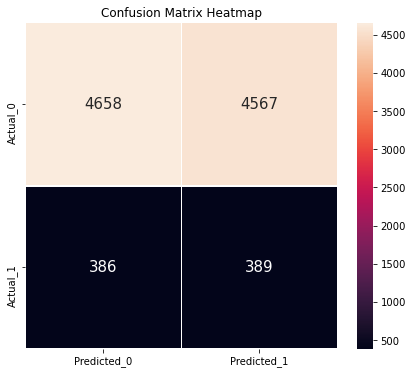

Distribution of Original Class Labels and Predicted Train and Test Class Labels


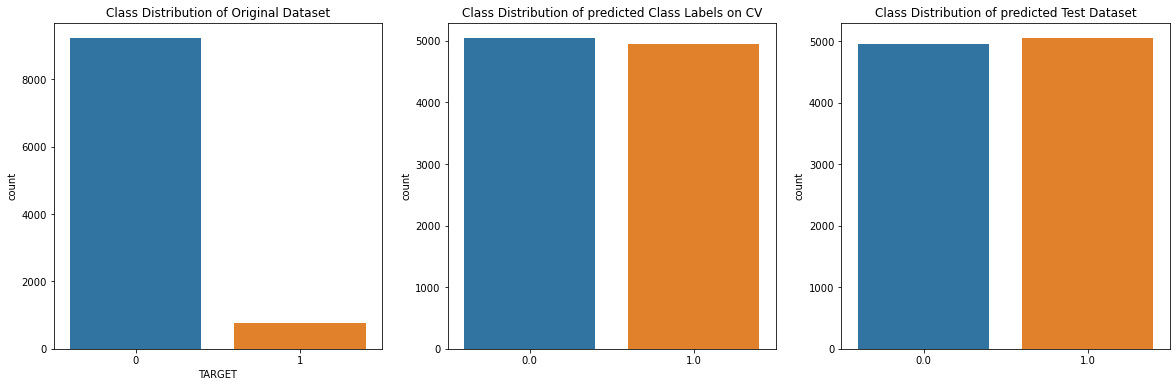

In [30]:
#predicted proability for train and test datapoints
predicted_proba_train = np.random.uniform(0, 1, len(train_data))
predicted_proba_test = np.random.uniform(0, 1, len(test_data))

print("=" * 100)
print("Training Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(target_train, predicted_proba_train)}")
print(f"\tPrecision Score = {precision_score(target_train, np.round(predicted_proba_train))}")
print(f"\tRecall Score = {recall_score(target_train, np.round(predicted_proba_train))}")
print('=' * 100)

print("Confusion Matrix of Training data:")
conf_mat = confusion_matrix(target_train, np.round(predicted_proba_train))
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (7,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
plt.show()
print('=' * 100)

print("Distribution of Original Class Labels and Predicted Train and Test Class Labels")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plt.title('Class Distribution of Original Dataset')
sns.countplot(target_train)
plt.subplot(1,3,2)
plt.title('Class Distribution of predicted Class Labels on CV')
sns.countplot(np.round(predicted_proba_train))
plt.subplot(1,3,3)
plt.title('Class Distribution of predicted Test Dataset')
sns.countplot(np.round(predicted_proba_test))
plt.show()
print('=' * 100)

D'après la matrice de confusion ci-dessus, nous voyons qu'elle prédit un nombre presque égal d'étiquettes de classe positives et négatives. Cela implique le caractère totalement aléatoire du modèle.
À partir des distributions des étiquettes de classe prédites également, nous voyons ce comportement.
L'AUC du modèle aléatoire sur l'ensemble de données d'entraînement est proche de 0,5 et le F1-Score proche de 0,14.
L'AUC similaire est également visible dans l'ensemble de données de test, comme le montre la soumission ci-dessus.
Cela définit une base de référence pour toutes les métriques ici.

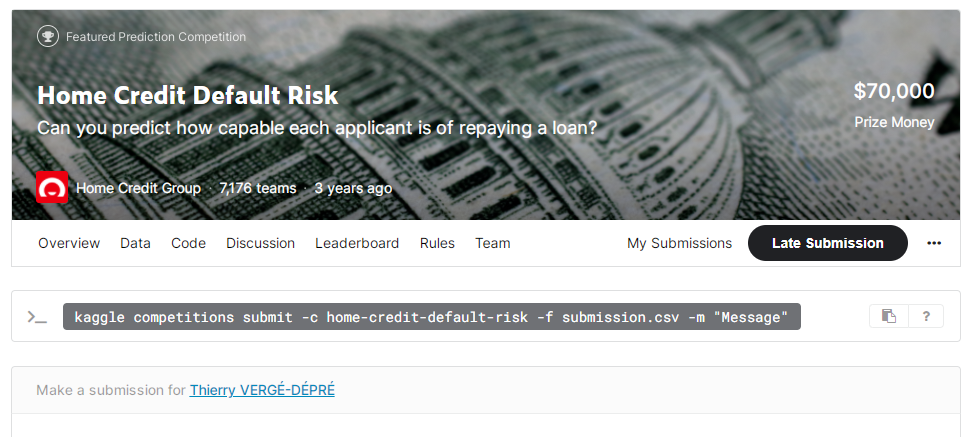

In [31]:
# Syntaxe
# kaggle competitions submit [-h](help)                             -f FILE_NAME      -m  "MESSAGE"    [-q] [competition] (URL)
#!kaggle competitions submit            -c home-credit-default-risk -f submission.csv -m "mon essage"

In [32]:
import kaggle

In [33]:
#initialiser l'API
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [34]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : predicted_proba_test}).to_csv('Random_Model.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f Random_Model.csv -m "My TVD Random Model Predictions"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk
Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/266k [00:00<?, ?B/s]
  3%|3         | 8.00k/266k [00:00<00:05, 47.0kB/s]
 75%|#######5  | 200k/266k [00:00<00:00, 912kB/s]  
100%|##########| 266k/266k [00:04<00:00, 65.1kB/s]


## Dominant Class Model

Dans ce modèle, nous prédisons tout en tant que classe dominante, qui est l'étiquette de classe 0 dans notre cas ici. Nous verrons également les métriques de ce modèle, et encore une fois, nos modèles sensibles doivent être plus performants que cela.
Étant donné que nous calculons également la valeur ROC-AUC, nous allons donc prédire au hasard une probabilité comprise entre 0 et 0,5 avec un seuil de 0,5, de sorte que tous les points soient classés comme 0.

Training Dataset Results:
	ROC-AUC Score = 0.49722682052626976
	Precision Score = 0.0
	Recall Score = 0.0
Confusion Matrix of Training data:


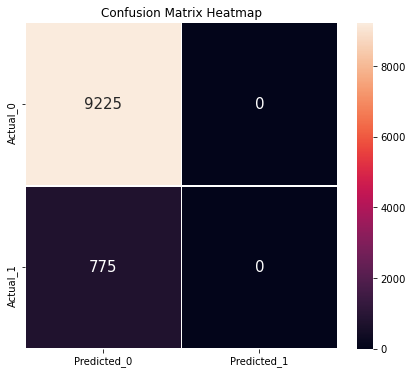

Distribution of Original Class Labels and Predicted Train and Test Class Labels


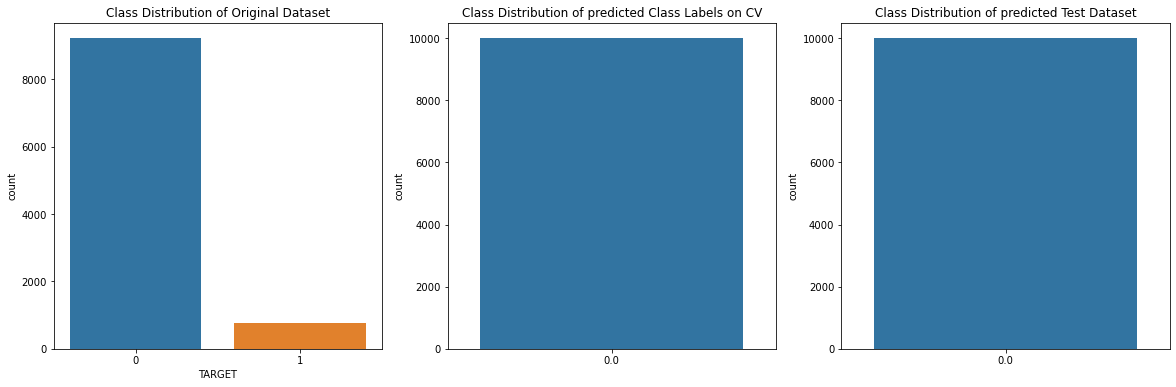

In [35]:
#predicting everything with probability less than 0.5, i.e majority class
predicted_proba_train = np.random.uniform(0, 0.5, len(train_data))
predicted_proba_test = np.random.uniform(0, 0.5, len(test_data))

print("=" * 100)
print("Training Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(target_train, predicted_proba_train)}")
print(f"\tPrecision Score = {precision_score(target_train, np.round(predicted_proba_train))}")
print(f"\tRecall Score = {recall_score(target_train, np.round(predicted_proba_train))}")
print('=' * 100)

print("Confusion Matrix of Training data:")
conf_mat = confusion_matrix(target_train, np.round(predicted_proba_train))
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (7,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
plt.show()
print('=' * 100)

print("Distribution of Original Class Labels and Predicted Train and Test Class Labels")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plt.title('Class Distribution of Original Dataset')
sns.countplot(target_train)
plt.subplot(1,3,2)
plt.title('Class Distribution of predicted Class Labels on CV')
sns.countplot(np.round(predicted_proba_train))
plt.subplot(1,3,3)
plt.title('Class Distribution of predicted Test Dataset')
sns.countplot(np.round(predicted_proba_test))
plt.show()
print('=' * 100)

D'après les résultats ci-dessus, nous observons qu'à nouveau l'AUC reste à peu près la même, qui est de 0,5.
Cependant, le F1-Score est maintenant de 0, car nous ne prévoyons rien en tant que classe positive.
La matrice de confusion montre également tous les points comme négatifs, c'est-à-dire qu'elle a un nombre élevé de faux négatifs, mais aucun faux positif.
Le Test AUC est également cohérent avec la formation, soit 0,5074.

In [36]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : predicted_proba_test}).to_csv('Dominant_Class_Model.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f Dominant_Class_Model.csv -m "My TVD Predicted probabilities between 0 to 0.5, with a threshold of 0.5"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk
Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/270k [00:00<?, ?B/s]
  3%|2         | 8.00k/270k [00:00<00:04, 59.7kB/s]
 71%|#######1  | 192k/270k [00:00<00:00, 980kB/s]  
100%|##########| 270k/270k [00:03<00:00, 75.1kB/s]


# Algorithmes d’apprentissage automatique sensibles aux données déséquilibrées

## Logistic Regression L2 Regularization

Dans cette section, nous utiliserons SGDClassifier avec perte de log et pénalité l2. Nous utiliserons GridSearchCV pour l'optimisation des hyperparamètres.
Nous n'avons pas encore divisé les données en train et cv. Nous allons créer les données de validation croisée à la volée, c'est-à-dire lors du réglage des hyperparamètres.
Pour les prédictions globales sur le CV, nous utiliserons la méthode Stratified K-Fold avec des prédictions en tant que prédictions hors pli.
Étant donné que nous optimisons les hyperparamètres pour l'AUC et que c'est également le cas d'un ensemble de données déséquilibré, nous réglerons le seuil pour le meilleur TPR et le moins TPR, en utilisant J-Statistic.

Doing Randomized Search CV on Classifier with 15 random initializations...
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   41.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   45.0s finished


Done.
Time elapsed = 0:00:46.394338


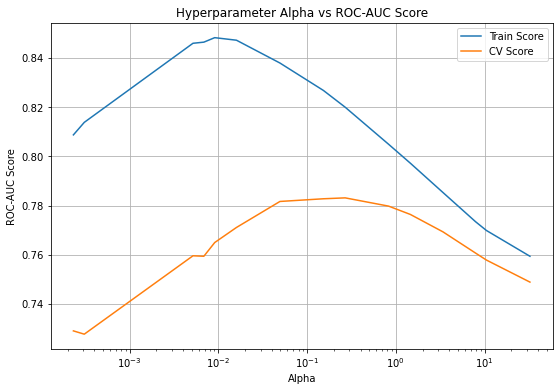

In [37]:
params = {
    'loss' : 'log',
    'penalty' : 'l2',
    'random_state' : 98,
    'class_weight' : 'balanced',
    'n_jobs' : -1
}
clf = SGDClassifier(**params)
hyperparams = {'alpha' : np.logspace(-4,2)}

sgd_lr_l2 = modelling(clf, x_train_std, y_train, x_test_std)

#lets do randomized search cv first
sgd_lr_l2.random_search_cv(hyperparams, n_iter = 15, n_jobs = 2)

#visualizing the cv results
cv_results = sgd_lr_l2.tuning_results
cv_results = cv_results.sort_values('param_alpha')

#plotting the train and cv scores
plt.figure(figsize = (9,6))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], label = 'Train Score')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], label = 'CV Score')
plt.title('Hyperparameter Alpha vs ROC-AUC Score')
plt.xlabel('Alpha')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()
plt.xscale('log')
plt.show()

Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:00:01.073772

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.4855863202037839

Train Results:
	ROC-AUC Score = 0.8137398024302822
	Precision Score = 0.16945840312674484
	Recall Score = 0.7832258064516129
CV Results:
	ROC-AUC Score = 0.7817656788180786
	Precision Score = 0.1753523434939364
	Recall Score = 0.6903225806451613
Confusion Matrix of CV data:


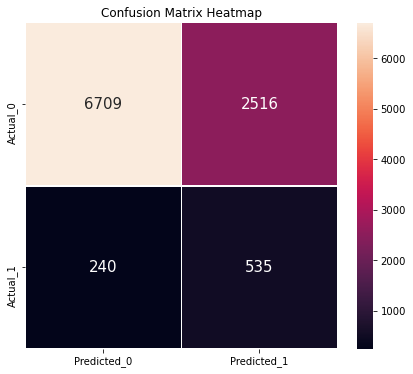

Distribution of Original Class Labels and Predicted CV and Test Class Labels


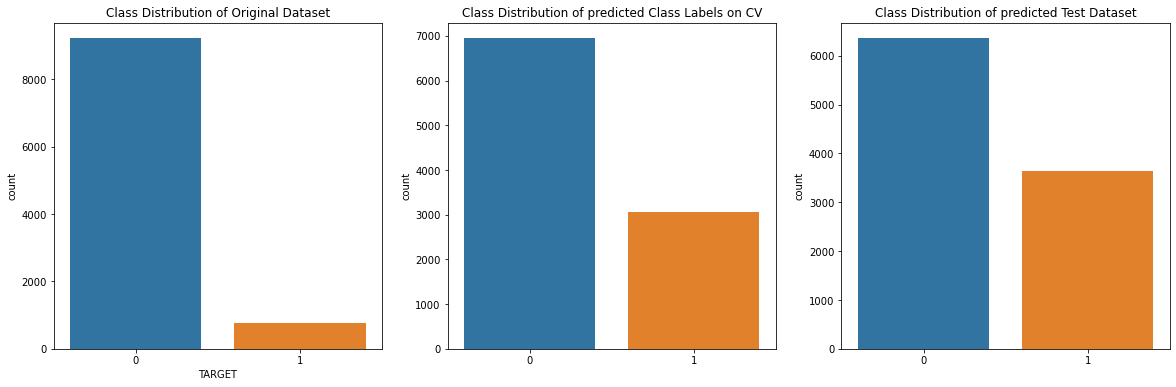

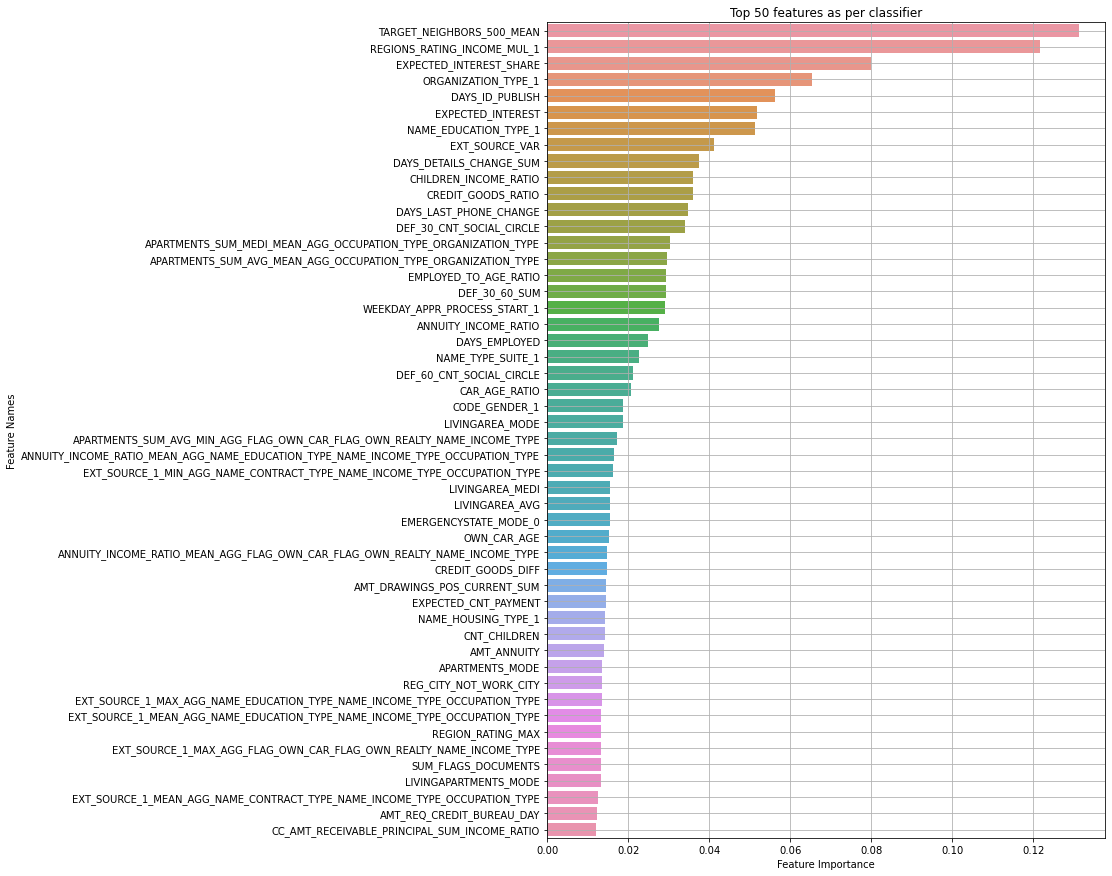

In [38]:
#training on best parameters
sgd_lr_l2.train_on_best_params()
#showing the results
sgd_lr_l2.results_on_best_params('linear')
#plotting feature importances
sgd_lr_l2.feat_importances_show(train_data.columns, num_features = 50)

Discussion des résultats

Nous avons d'abord réglé l'hyperparamètre « alpha » pour la régression logistique à l'aide de RandomizedSearchCV, avec une validation croisée quadruple.
Nous avons ensuite utilisé le meilleur modèle obtenu pour s'adapter à l'ensemble de données d'apprentissage.
D'après les scores AUC, nous voyons que les scores AUC Train et CV sont très proches les uns des autres. Cela n'implique pas beaucoup de surajustement.
Le test AUC selon Kaggle s'avère être un peu moins que CV AUC. Il n'y a pas une grande différence entre le CV et le test AUC, cela implique que le CV et le jeu de données de test sont très similaires.
Le seuil optimal de décision pour la probabilité est de 0,47, ce qui est proche de 0,5. En effet, la régression logistique renvoie en fait une vraie probabilité de classe de manière inhérente.
À partir de la matrice de confusion, nous voyons qu'il y a beaucoup de faux résultats positifs. Alors que le nombre de faux négatifs est en réalité inférieur.
On voit que la précision de notre modèle est très faible. Cependant, la valeur de rappel est en fait bonne. C'est ce que nous voulons, c'est-à-dire qu'aucun défaillant ne doit être manqué même si certains non défaillants sont classés comme défaillants, car ils peuvent alors postuler à nouveau, mais si un défaillant est manqué par le modèle, cela pourrait causer beaucoup de pertes pour l'entreprise .
Si nous regardons la distribution des étiquettes de classe prédites par rapport aux étiquettes de classe réelles, nous voyons qu'il y a beaucoup plus d'étiquettes de classe positives prédites qu'il n'y en a réellement. Cela implique à nouveau la faible valeur de la précision.
Nous voyons également que les étiquettes de classe prédites parmi les jeux de données de CV et de test suivent une distribution très similaire, ce qui implique que le modèle fonctionne de manière similaire sur les données de CV et de test.
Nous avons tracé les 50 principales caractéristiques selon le classificateur. La caractéristique de score la plus élevée est la moyenne des valeurs cibles de 500 voisins. Nous voyons également qu'une autre caractéristique conçue, c'est-à-dire l'intérêt attendu, obtient également un score assez élevé. Cela signifie que nos fonctionnalités générées aident réellement dans la tâche de classification.

In [39]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : sgd_lr_l2.test_preds_probas}).to_csv('SGD_LR_L2_penalty.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f SGD_LR_L2_penalty.csv -m "My TVD Logistic Regression with L2 Penalty"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk
Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/266k [00:00<?, ?B/s]
  3%|3         | 8.00k/266k [00:00<00:03, 78.7kB/s]
 81%|########1 | 216k/266k [00:00<00:00, 1.22MB/s] 
100%|##########| 266k/266k [00:05<00:00, 48.9kB/s]


In [40]:

with open('SGD_LR_L2_Penalty_CV_Preds.pkl', 'wb') as f:
    pickle.dump(sgd_lr_l2.cv_preds_probas, f)
with open('SGD_LR_L2_Penalty_Test_Preds.pkl', 'wb') as f:
    pickle.dump(sgd_lr_l2.test_preds_probas, f)
with open('SGD_LR_L2_Penalty_Model.pkl', 'wb') as f:
    pickle.dump(sgd_lr_l2.best_model, f)

## Linear SVM

> Dans cette section, nous allons à nouveau entraîner un SGDClassifier avec une pénalité L2 mais avec une perte de charnière, pour le cas de SVM linéaire. Nous n'utiliserons pas Kernel SVM en raison de la complexité élevée du temps de train, car le nombre de points de données est très élevé dans notre cas.

Doing Randomized Search CV on Classifier with 15 random initializations...
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   11.9s finished


Done.
Time elapsed = 0:00:12.333310


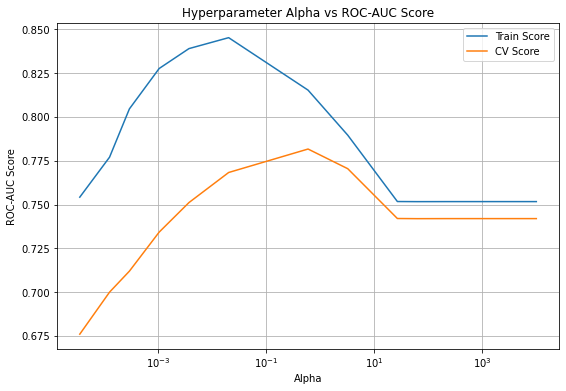

In [41]:
params = {
    'loss' : 'hinge',
    'class_weight' : 'balanced',
    'random_state' : 129,
    'n_jobs' : -1
}
clf = SGDClassifier(**params)
hyperparams = {
    'alpha' : np.logspace(-5,4) 
}
linear_svm = modelling(clf, x_train_std, y_train, x_test_std, calibration = True)

#lets do randomized search cv first
linear_svm.random_search_cv(hyperparams, n_iter = 15, n_jobs = 2, random_state = 693)

#visualizing the cv results
cv_results = linear_svm.tuning_results
cv_results = cv_results.sort_values('param_alpha')

#plotting the train and cv scores
plt.figure(figsize = (9,6))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], label = 'Train Score')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], label = 'CV Score')
plt.title('Hyperparameter Alpha vs ROC-AUC Score')
plt.xlabel('Alpha')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()
plt.xscale('log')
plt.show()

Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:00:04.344878

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.08291526852048074

Train Results:
	ROC-AUC Score = 0.8123894746044235
	Precision Score = 0.1942471590909091
	Recall Score = 0.7058064516129032
CV Results:
	ROC-AUC Score = 0.7802043535274061
	Precision Score = 0.1807988787666433
	Recall Score = 0.6658064516129032
Confusion Matrix of CV data:


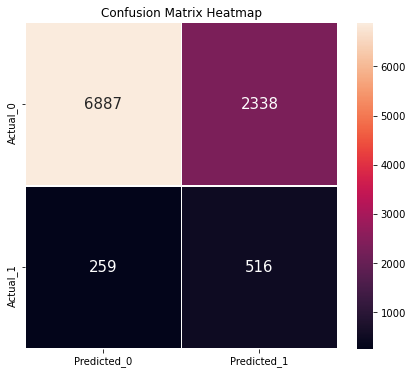

Distribution of Original Class Labels and Predicted CV and Test Class Labels


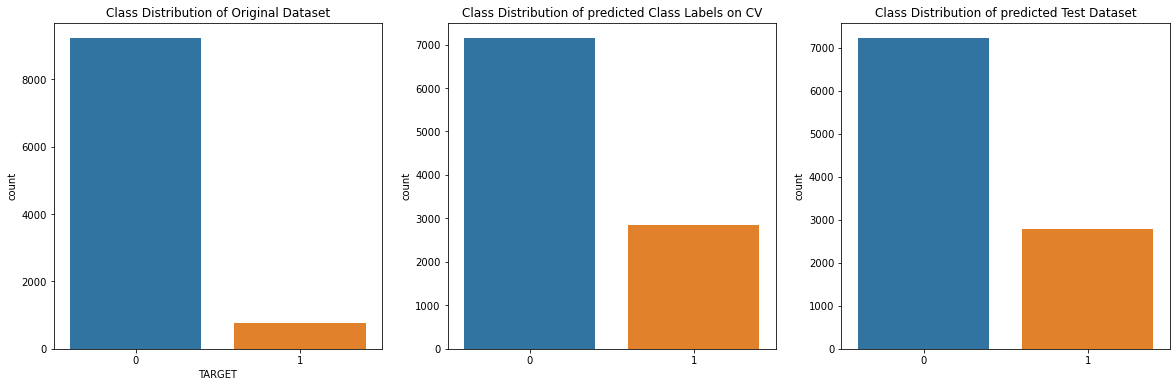

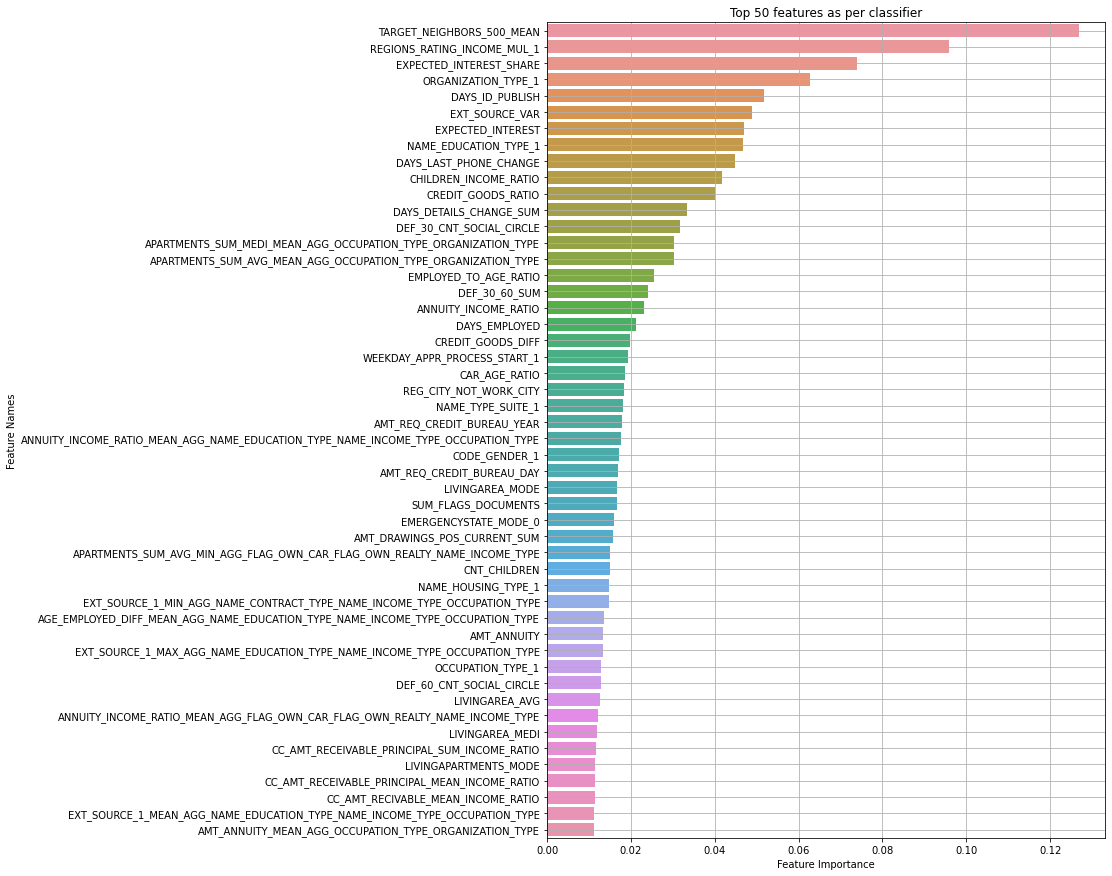

In [42]:
#training on best parameters
linear_svm.train_on_best_params()
#showing the results
linear_svm.results_on_best_params('linear')
#plotting feature importances
linear_svm.feat_importances_show(train_data.columns, num_features = 50)

Discussion des résultats

Les résultats de la SVM linéaire sans double formulation sont très similaires aux résultats de la régression logistique. Cependant, il y a une très légère amélioration des performances.
Les scores Train et CV AUC pour la SVM linéaire sont légèrement supérieurs à ceux de la régression logistique. On peut voir la même chose du Test AUC aussi, du Kaggle.
Une chose intéressante à noter ici est que la probabilité de seuil est aussi faible que 0,07.
Les valeurs de précision et de rappel sont également presque les mêmes, mais légèrement plus élevées pour la régression Logisitc.
À partir de la matrice de confusion, nous observons que les vrais positifs pour la SVM linéaire sont légèrement inférieurs à ceux de la régression logistique.
Les 50 caractéristiques les plus importantes sont également presque identiques à la régression logistique.
Ainsi, nous pouvons conclure que la régression logistique et la SVM linéaire se comportent de manière très similaire, comme prévu.

In [43]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : linear_svm.test_preds_probas}).to_csv('SGD_Linear_SVM.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f SGD_Linear_SVM.csv -m "My TVD Linear SVM SGD"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk
Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/271k [00:00<?, ?B/s]
  3%|2         | 8.00k/271k [00:00<00:06, 42.9kB/s]
 33%|###2      | 88.0k/271k [00:02<00:05, 34.9kB/s]
 35%|###5      | 96.0k/271k [00:04<00:10, 17.2kB/s]
 38%|###8      | 104k/271k [00:05<00:11, 14.9kB/s] 
 68%|######8   | 184k/271k [00:05<00:02, 44.0kB/s]
100%|##########| 271k/271k [00:06<00:00, 85.2kB/s]
100%|##########| 271k/271k [00:08<00:00, 34.4kB/s]


In [44]:

with open('SGD_Linear_SVM_CV_Preds.pkl', 'wb') as f:
    pickle.dump(linear_svm.cv_preds_probas, f)
with open('SGD_Linear_SVM_Test_Preds.pkl', 'wb') as f:
    pickle.dump(linear_svm.test_preds_probas, f)
with open('SGD_Linear_SVM_Model.pkl', 'wb') as f:
    pickle.dump(linear_svm.best_model, f)

## Random Forest Classifier

> Dans cette section, nous allons utiliser la technique d'ensachage et former un classificateur de forêt aléatoire. Nous utiliserons la technique de recherche aléatoire pour régler certains des hyperparamètres du RandomForestClassifier.

In [45]:
params = {
    'n_jobs' : -1,
    'random_state' : 210,
    'class_weight' : 'balanced_subsample',
    'verbose' : 0
}
clf = RandomForestClassifier(**params)
hyperparams = {
    'n_estimators' : list(range(500, 1500)),
    'max_depth' : list(range(10,30)),
    'min_samples_split' : list(range(5,50)),
    'min_samples_leaf' : list(range(2,50)),
    'max_samples' : uniform(0,1)   
}

rf = modelling(clf, x_train_std, y_train, x_test_std)

#lets do randomized search cv first
rf.random_search_cv(hyperparams, n_iter = 10, n_jobs = -1, random_state = 4281)

Doing Randomized Search CV on Classifier with 10 random initializations...
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.9min finished


Done.
Time elapsed = 0:07:02.682880


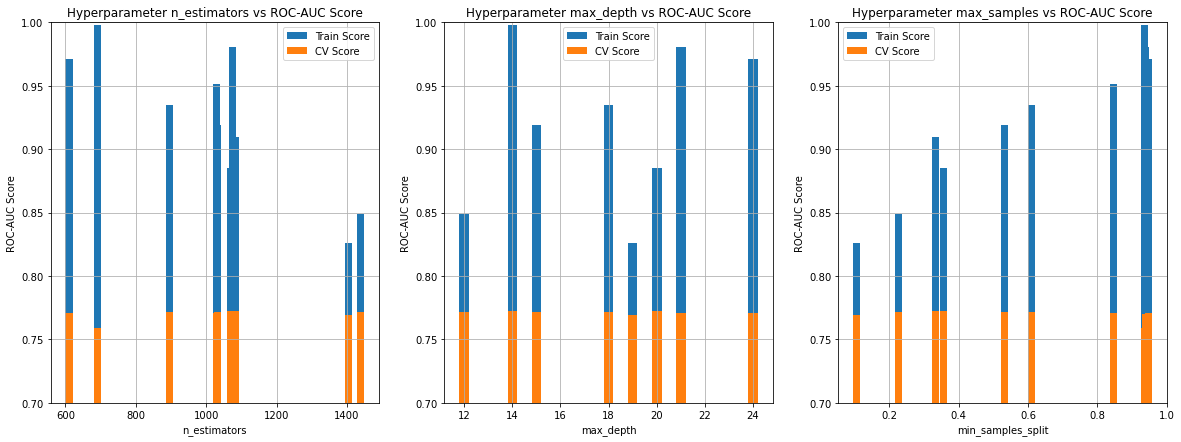

In [46]:
cv_results = rf.tuning_results

#lets plot the ROC-AUC for different Hyperparameters
plt.figure(figsize = (20,7))
plt.subplot(1,3,1)
cv_results = cv_results.sort_values('param_n_estimators')
plt.bar(cv_results['param_n_estimators'], cv_results['mean_train_score'], width = 20, label = 'Train Score')
plt.bar(cv_results['param_n_estimators'], cv_results['mean_test_score'], width = 20, label = 'CV Score')
plt.ylim(0.7,1)
plt.title('Hyperparameter n_estimators vs ROC-AUC Score')
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
cv_results = cv_results.sort_values('param_max_depth')
plt.bar(cv_results['param_max_depth'], cv_results['mean_train_score'], width = 0.4, label = 'Train Score')
plt.bar(cv_results['param_max_depth'], cv_results['mean_test_score'], width = 0.4, label = 'CV Score')
plt.ylim(0.7,1)
plt.title('Hyperparameter max_depth vs ROC-AUC Score')
plt.xlabel('max_depth')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
cv_results = cv_results.sort_values('param_min_samples_split')
plt.bar(cv_results['param_max_samples'], cv_results['mean_train_score'], width = 0.02, label = 'Train Score')
plt.bar(cv_results['param_max_samples'], cv_results['mean_test_score'], width = 0.02, label = 'CV Score')
plt.ylim(0.7,1)
plt.title('Hyperparameter max_samples vs ROC-AUC Score')
plt.xlabel('min_samples_split')
plt.ylabel('ROC-AUC Score')

plt.legend()
plt.grid()
plt.show()

> D'après les graphiques ci-dessus, nous notons que les paramètres avec le ROC-AUC de validation croisée le plus élevé ont un score ROC-AUC d'entraînement très élevé, donc pour éviter le cas de surapprentissage, nous essaierons de choisir les paramètres, qui ont un écart sensible entre les scores d'entrainement et de validation croisée.

In [47]:
cv_results['Train_CV_Score_Difference'] = cv_results['mean_train_score'] - cv_results['mean_test_score']

#lets look at the differences between the train and CV scores
print("Checking out the differences between Train and CV Scores for each set of hyperparameters:\n")
display(cv_results[['params', 'mean_test_score', 'mean_train_score', 'Train_CV_Score_Difference']])

Checking out the differences between Train and CV Scores for each set of hyperparameters:



,params,mean_test_score,mean_train_score,Train_CV_Score_Difference
3,"{'max_depth': 14, 'max_samples': 0.93717204395...",0.758885,0.997873,0.238987
6,"{'max_depth': 15, 'max_samples': 0.53224896818...",0.772011,0.919418,0.147407
8,"{'max_depth': 18, 'max_samples': 0.60961236108...",0.771610,0.935069,0.163459
5,"{'max_depth': 24, 'max_samples': 0.94708311766...",0.770542,0.970831,0.200290
2,"{'max_depth': 21, 'max_samples': 0.93803728255...",0.770325,0.980218,0.209892
9,"{'max_depth': 14, 'max_samples': 0.33224831069...",0.772266,0.909422,0.137156
0,"{'max_depth': 20, 'max_samples': 0.35680763572...",0.772332,0.885372,0.113041
7,"{'max_depth': 21, 'max_samples': 0.84676766673...",0.771034,0.951276,0.180242
4,"{'max_depth': 19, 'max_samples': 0.10549276374...",0.769350,0.826146,0.056797
1,"{'max_depth': 12, 'max_samples': 0.22686425497...",0.771507,0.849201,0.077694


> Nous observons que l'écart minimum entre Train et CV Score est de 0,05...., et que le CV Score n'est pas non plus trop bas. Nous choisirons donc cet ensemble d'hyperparamètres.

Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:00:26.934813

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.3227832148242819

Train Results:
	ROC-AUC Score = 0.827218323280007
	Precision Score = 0.17700145560407568
	Recall Score = 0.7845161290322581
CV Results:
	ROC-AUC Score = 0.7686187953492438
	Precision Score = 0.16038562664329536
	Recall Score = 0.7083870967741935
Confusion Matrix of CV data:


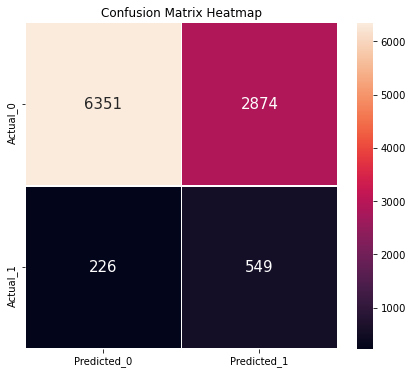

Distribution of Original Class Labels and Predicted CV and Test Class Labels


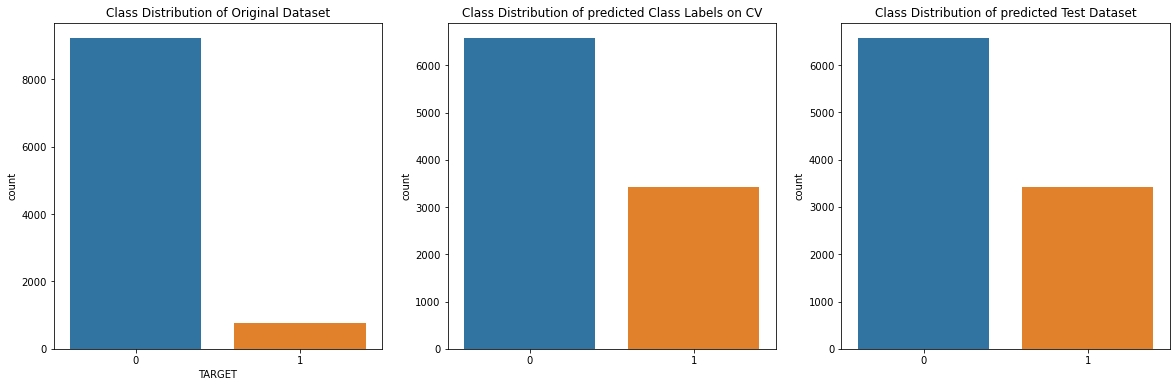

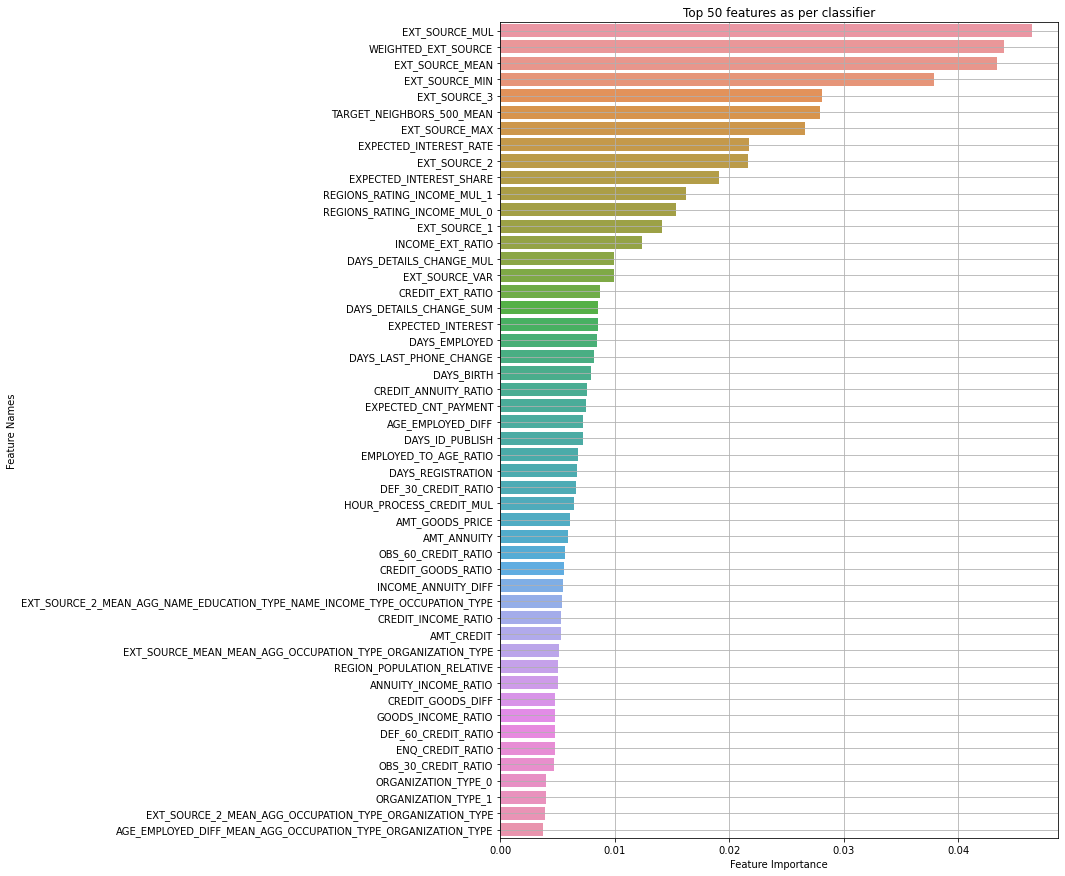

In [48]:
#reinstantiating the best model of rf class with these parameters
rf.best_model = RandomForestClassifier(class_weight = 'balanced_subsample', max_depth = 19,
                                       max_samples = 0.105493, min_samples_leaf = 26,
                                       min_samples_split = 44, n_estimators = 1403, n_jobs = -1,
                                       random_state = 210, verbose = 0)
#training on best parameters
rf.train_on_best_params()
#showing the results
rf.results_on_best_params('random_forest')
#plotting feature importances
rf.feat_importances_show(train_data.columns, num_features = 50)

Discussion des résultats

Nous voyons que le modèle de forêt aléatoire fonctionne moins bien que la régression logistique et la SVM linéaire.
Nous constatons une énorme différence dans les scores de formation et de validation croisée. Le modèle a un surajustement très élevé.
L'AUC du test est également inférieure à celle des deux autres modèles.
De la matrice de confusion, nous voyons que le nombre de faux positifs est assez élevé, ce qui affecte notre valeur de précision. Cependant, nous voyons que la valeur de Recall est élevée, ce qui est en fait bon pour la perspective des entreprises.
Les valeurs de rappel des données d'entraînement et de CV montrent également qu'il existe un surajustement élevé des données d'entraînement.

Nous voyons que la caractéristique la plus importante est à nouveau la moyenne TARGET de 500 voisins, similaire à la régression logistique et à la SVM linéaire. Nous remarquons également que la plupart des fonctionnalités EXT_SOURCE sont parmi les fonctionnalités les plus performantes. Les caractéristiques générées à l'aide des caractéristiques brutes EXT_SOURCE fonctionnent mieux que les caractéristiques brutes elles-mêmes.

In [49]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : rf.test_preds_probas}).to_csv('Random_Forest.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f Random_Forest.csv -m "My TVD Random_Forest"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk
Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/268k [00:00<?, ?B/s]
  3%|2         | 8.00k/268k [00:01<00:36, 7.27kB/s]
 75%|#######4  | 200k/268k [00:01<00:00, 225kB/s]  
100%|##########| 268k/268k [00:04<00:00, 56.9kB/s]


In [50]:
with open('Random_Forest_CV_Preds.pkl', 'wb') as f:
    pickle.dump(rf.cv_preds_probas, f)

with open('Random_Forest_Test_Preds.pkl', 'wb') as f:
    pickle.dump(rf.test_preds_probas, f)

with open('Random_Forest_Model.pkl', 'wb') as f:
    pickle.dump(rf.best_model, f)

## ExtraTreesClassifier

> Ce classificateur est très similaire au RandomForestClassifier, sauf qu'il n'examine que certaines valeurs aléatoires pour *Information Gain* tout en fractionnant les données pour les caractéristiques numériques.

In [51]:
params = {
    'n_jobs' : -1,
    'bootstrap' : True,
    'random_state' : 210,
    'class_weight' : 'balanced_subsample',
    'verbose' : 0
}
clf = ExtraTreesClassifier(**params)
hyperparams = {
    'n_estimators' : list(range(500, 1500)),
    'max_depth' : list(range(10,30)),
    'min_samples_split' : list(range(5,20)),
    'min_samples_leaf' : list(range(2,20)),
    'max_samples' : uniform(0,1)   
}

extra_trees = modelling(clf, x_train_std, y_train, x_test_std)

#lets do randomized search cv first
extra_trees.random_search_cv(hyperparams, n_iter = 10, n_jobs = -1, random_state = 4281)


Doing Randomized Search CV on Classifier with 10 random initializations...
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.2min finished


Done.
Time elapsed = 0:06:21.379097


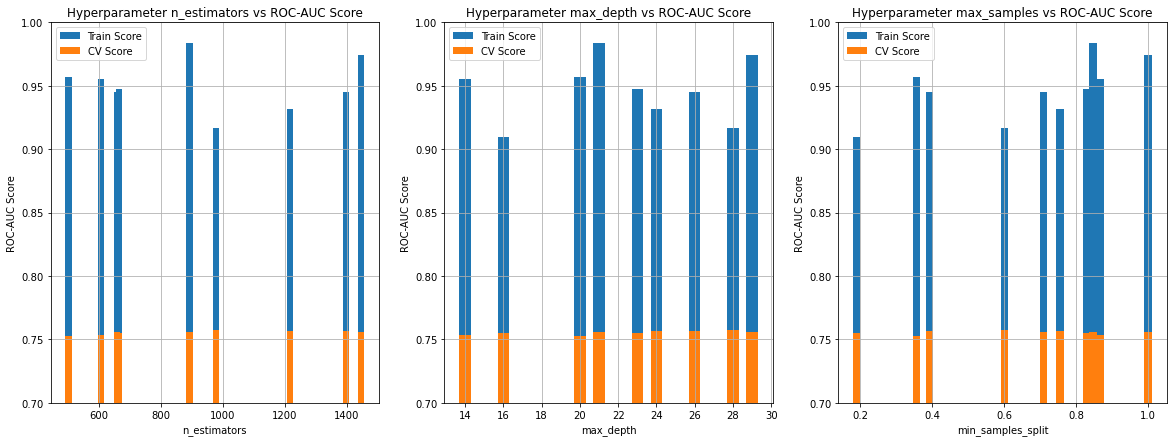

In [52]:
cv_results = extra_trees.tuning_results

#lets plot the ROC-AUC for different Hyperparameters
plt.figure(figsize = (20,7))
plt.subplot(1,3,1)
cv_results = cv_results.sort_values('param_n_estimators')
plt.bar(cv_results['param_n_estimators'], cv_results['mean_train_score'], width = 20, label = 'Train Score')
plt.bar(cv_results['param_n_estimators'], cv_results['mean_test_score'], width = 20, label = 'CV Score')
plt.ylim(0.7,1)
plt.title('Hyperparameter n_estimators vs ROC-AUC Score')
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
cv_results = cv_results.sort_values('param_max_depth')
plt.bar(cv_results['param_max_depth'], cv_results['mean_train_score'], width = 0.6, label = 'Train Score')
plt.bar(cv_results['param_max_depth'], cv_results['mean_test_score'], width = 0.6, label = 'CV Score')
plt.ylim(0.7,1)
plt.title('Hyperparameter max_depth vs ROC-AUC Score')
plt.xlabel('max_depth')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
cv_results = cv_results.sort_values('param_min_samples_split')
plt.bar(cv_results['param_max_samples'], cv_results['mean_train_score'], width = 0.02, label = 'Train Score')
plt.bar(cv_results['param_max_samples'], cv_results['mean_test_score'], width = 0.02, label = 'CV Score')
plt.ylim(0.7,1)
plt.title('Hyperparameter max_samples vs ROC-AUC Score')
plt.xlabel('min_samples_split')
plt.ylabel('ROC-AUC Score')

plt.legend()
plt.grid()
plt.show()

> Semblable au cas de Random Forest, nous constatons ici également de grands écarts entre les scores CV et Train. Cependant, les écarts ici sont plus importants que ceux du modèle RandomForest.

In [53]:
cv_results['Train_CV_Score_Difference'] = cv_results['mean_train_score'] - cv_results['mean_test_score']

#lets look at the differences between the train and CV scores
print("Checking out the differences between Train and CV Scores for each set of hyperparameters:\n")
display(cv_results[['params', 'mean_test_score', 'mean_train_score', 'Train_CV_Score_Difference']])

Checking out the differences between Train and CV Scores for each set of hyperparameters:



,params,mean_test_score,mean_train_score,Train_CV_Score_Difference
3,"{'max_depth': 29, 'max_samples': 0.99942209291...",0.756172,0.974038,0.217867
7,"{'max_depth': 21, 'max_samples': 0.84676766673...",0.756035,0.983663,0.227628
9,"{'max_depth': 26, 'max_samples': 0.39390409715...",0.756480,0.944739,0.188258
6,"{'max_depth': 26, 'max_samples': 0.70868250450...",0.755741,0.944978,0.189237
4,"{'max_depth': 24, 'max_samples': 0.75490714257...",0.757024,0.931727,0.174704
5,"{'max_depth': 28, 'max_samples': 0.60002385073...",0.757361,0.916457,0.159096
2,"{'max_depth': 16, 'max_samples': 0.19140070731...",0.754896,0.909492,0.154596
0,"{'max_depth': 20, 'max_samples': 0.35680763572...",0.752916,0.956698,0.203782
8,"{'max_depth': 23, 'max_samples': 0.82887645113...",0.755483,0.947854,0.192372
1,"{'max_depth': 14, 'max_samples': 0.86734516973...",0.753344,0.954974,0.201631


> On choisira l'ensemble des hyperparamètres qui ont un Cross-Validation Score considérable, tout en compromettant un peu le Gap. En effet, les paramètres de moindre écart ont un CV-Score très faible par rapport aux autres.
> Nous choisissons les hyperparamètres du 5ème indice.

Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:00:41.594461

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.40014747097284775

Train Results:
	ROC-AUC Score = 0.9151766413148003
	Precision Score = 0.2469437652811736
	Recall Score = 0.912258064516129
CV Results:
	ROC-AUC Score = 0.756700830492176
	Precision Score = 0.17490223960184856
	Recall Score = 0.6348387096774194
Confusion Matrix of CV data:


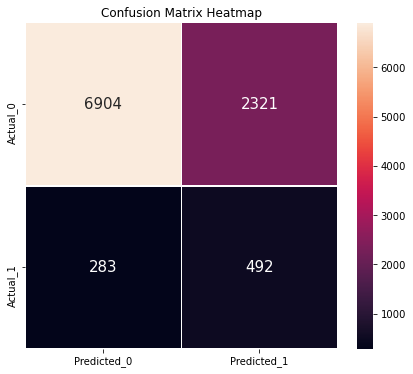

Distribution of Original Class Labels and Predicted CV and Test Class Labels


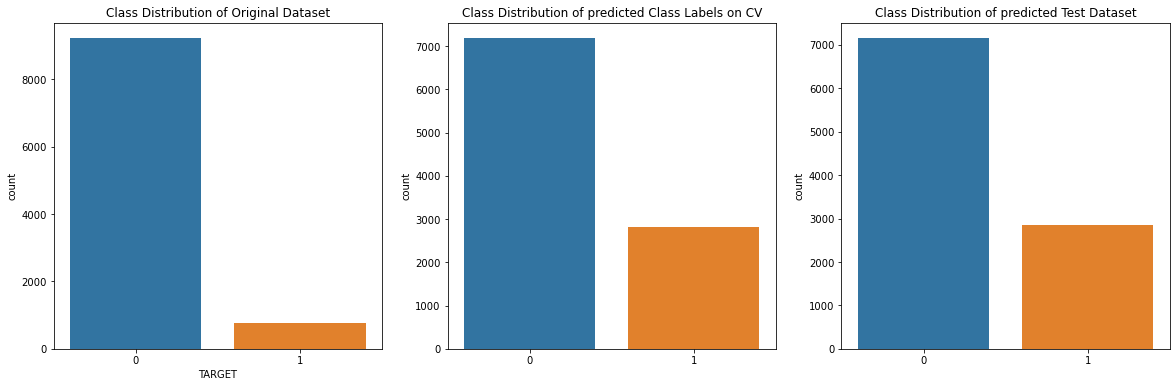

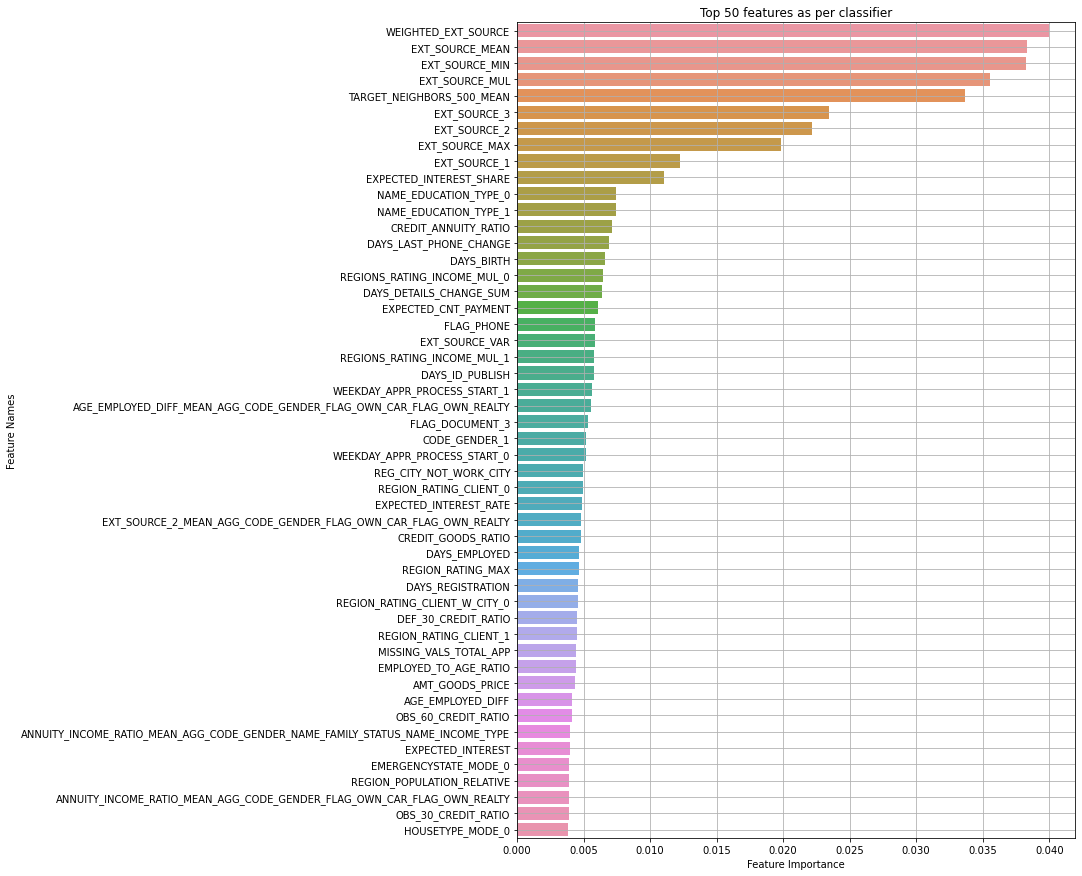

In [54]:
#reinstantiating the best model of extra_trees class with these parameters
extra_trees.best_model = ExtraTreesClassifier(bootstrap = True, class_weight = 'balanced_subsample',
                                              max_depth = 28, max_samples = 0.600024,
                                              min_samples_leaf = 16, min_samples_split = 10,
                                              n_estimators = 978, n_jobs = -1, random_state = 210, verbose = 0)
#training on best parameters
extra_trees.train_on_best_params()
#showing the results
extra_trees.results_on_best_params('random_forest')
#plotting feature importances
extra_trees.feat_importances_show(train_data.columns, num_features = 50)

Discussion des résultats

À quelques différences près, ce modèle fonctionne de manière très similaire à RandomForest.
Les valeurs AUC et Recall de ce modèle sont également inférieures à la forêt aléatoire. Cela peut également être vu sur le score privé.
La matrice de confusion montre des vrais positifs nettement inférieurs pour ce modèle, par rapport à tous les autres modèles.
Les caractéristiques les plus importantes sont également les mêmes que celles du modèle RandomForest.

In [55]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : extra_trees.test_preds_probas}).to_csv('Extra_Trees.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f Extra_Trees.csv -m "My TVD ExtraTreesClassifier Submission"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk
Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/268k [00:00<?, ?B/s]
  3%|2         | 8.00k/268k [00:00<00:06, 43.3kB/s]
 81%|########  | 216k/268k [00:00<00:00, 897kB/s]  
100%|##########| 268k/268k [00:03<00:00, 86.5kB/s]


In [56]:
with open('Extra_Trees_CV_Preds.pkl', 'wb') as f:
    pickle.dump(extra_trees.cv_preds_probas, f)
with open('Extra_Trees_Test_Preds.pkl', 'wb') as f:
    pickle.dump(extra_trees.test_preds_probas, f)
with open('Extra_Trees_Model.pkl', 'wb') as f:
    pickle.dump(extra_trees.best_model, f)

# Algorithmes d'apprentissage automatique NON sensibles aux données déséquilibrées

> Pour le boost XGBoost et LightGBM, nous avons trop d'hyperparamètres à régler, et faire GridSearchCV ou RandomizedSearchCV peut être trop coûteux sur un si grand ensemble de données pour trouver une solution optimale. C'est pourquoi nous utiliserons la technique d'optimisation bayésienne pour régler les hyperparamètres, qui fonctionne en examinant les résultats des hyperparamètres précédents tout en attribuant de nouveaux hyperparamètres. Il essaie de modéliser sur la fonction de coût qui dépend de tous les hyperparamètres.

## XGBoost GPU

### Bayesian Optimization

__NOTA :__

> A été supprimé du prog initial dans params = {} \
       <1> 'tree_method' : 'gpu_hist', \
       <2> 'gpu_id' : -1, # était 'gpu_id' : 0,

In [57]:
def xgb_evaluation(max_depth, min_child_weight, gamma, subsample, colsample_bytree, colsample_bylevel,
                   colsample_bynode, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of XGBoost's Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.
    
    Inputs: Hyperparamters to be tuned.
        max_depth, min_child_weight, gamma, subsample, colsample_bytree, colsample_bylevel,
        colsample_bynode, reg_alpha, reg_lambda
        
    Returns:
        CV ROC-AUC Score
    '''
    params = {
        'learning_rate' : 0.01,
        'n_estimators' : 10000,
        
        'gpu_id' : -1,
        'max_depth' : int(round(max_depth)),
        'min_child_weight' : int(round(min_child_weight)),
        'subsample': subsample,
        'gamma' : gamma,
        'colsample_bytree' : colsample_bytree,
        'colsample_bylevel' : colsample_bylevel,
        'colsample_bynode' : colsample_bynode,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'random_state' : 51412
    }    
    
    #defining the Cross-Validation Strategry
    stratified_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 33)
    cv_preds = np.zeros(train_data.shape[0])
    
    #iterating over each fold, training the model, and making Out of Fold Predictions
    for train_indices, cv_indices in stratified_cv.split(train_data, target_train):
        
        x_tr = train_data.iloc[train_indices]
        y_tr = target_train.iloc[train_indices]
        x_cv = train_data.iloc[cv_indices]
        y_cv = target_train.iloc[cv_indices]
        
        xgbc = XGBClassifier(**params)
        xgbc.fit(x_tr, y_tr, eval_set= [(x_cv,y_cv)],
                        eval_metric='auc', verbose = False, early_stopping_rounds=200)
        
        cv_preds[cv_indices] = xgbc.predict_proba(x_cv, ntree_limit = xgbc.get_booster().best_ntree_limit)[:,1]
        gc.collect()   
        
    return roc_auc_score(target_train, cv_preds)

In [58]:
#defining the optimizer and the hyperparameters along with ranges of values.
bopt_xgb =  BayesianOptimization(xgb_evaluation, {'max_depth' : (5,15),
                                                  'min_child_weight' : (5,80),
                                                  'gamma' : (0.2,1),
                                                  'subsample' : (0.5,1),
                                                  'colsample_bytree' : (0.5,1),
                                                  'colsample_bylevel' : (0.3,1),
                                                  'colsample_bynode' : (0.3,1),
                                                  'reg_alpha' : (0.001, 0.3),
                                                  'reg_lambda' : (0.001, 0.3)}, 
                                 random_state = 55)

bopt_xgb.maximize(n_iter = 6, init_points = 4)

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7      |  0.3652   |  0.9802   |  0.7419   |  0.394    |  10.31    |  26.42    |  0.2589   |  0.01329  |  0.5542   |
|  2        |  0.778    |  0.837    |  0.336    |  0.8879   |  0.2073   |  11.18    |  66.4     |  0.2697   |  0.2957   |  0.7484   |
|  3        |  0.6666   |  0.5466   |  0.907    |  0.6984   |  0.7149   |  5.205    |  65.61    |  0.1295   |  0.168    |  0.8896   |
|  4        |  0.7813   |  0.5818   |  0.9356   |  0.825    |  0.7818   |  12.8     |  31.3     |  0.006878 |  0.1082   |  0.6516   |
|  5        |  0.7757   |  0.8057   |  0.7387   |  0.8461   |  0.9899   |  5.404    |  74.35    |  0.1637   |  0.2228   |  0.9098   |
|  6        |  0.6854   |  0.642    |  0.9929   |  0.5992   | 

### Extracting the best parameters

In [59]:
#extracting the best parameters
target_values = []
for result in bopt_xgb.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']
    
print("Best Hyperparameters for XGBoost are:\n")
print(best_params)

Best Hyperparameters for XGBoost are:

{'colsample_bylevel': 0.581789986486239, 'colsample_bynode': 0.9355964425376142, 'colsample_bytree': 0.8249848054933024, 'gamma': 0.7818177817205629, 'max_depth': 12.795610399847863, 'min_child_weight': 31.30455857567982, 'reg_alpha': 0.006878316169676387, 'reg_lambda': 0.1082090122893085, 'subsample': 0.6516127256744071}


### Training on Optimized Hyper-parameters

__NOTA :__

> A été supprimé du prog initial dans params = {} \
       <1> 'tree_method' : 'gpu_hist', \
       <2> 'gpu_id' : 0, # était 'gpu_id' : 0,

In [60]:
#training on optimized hyperparameters
params = {
        'learning_rate' : 0.01,
        'n_estimators' : 10000,
        'max_depth' : 5,
        'min_child_weight' : 80,
        'subsample': 0.5541738669753602, #0.9622896832878278,
        'gamma' : 0.3940181611984513, #0.794005454765522,
        'colsample_bytree' : 0.741929990231823, #0.5741523601432443,
        'colsample_bylevel' : 0.3651758006703006, #0.3272128085080071,
        'colsample_bynode' : 0.9801591439928512, #0.9480907366417157,
        'reg_alpha' : 0.2589264827384402, #0.24018946957919934,
        'reg_lambda' : 0.013288945884801236, #0.23887141295582165,
        'random_state' : 51412,
    }    
xgb_boosting = Boosting(train_data, target_train, test_data, params, random_state = 98, save_model_to_pickle = True)
xgb_boosting.train(booster = 'xgboost')

Fitting the xgboost on Training Data with 3 fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation

	Fold Number 1

[0]	validation_0-auc:0.73111	validation_1-auc:0.72989
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
Stopping. Best iteration:
[8]	validation_0-auc:0.78513	validation_1-auc:0.76830


	Fold Number 2

[0]	validation_0-auc:0.73657	validation_1-auc:0.68416
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[400]	validation_0-auc:0.80456	validation_1-auc:0.75305
[800]	validation_0-auc:0.81300	validation_1-auc:0.75935
[1200]	validation_0-auc:0.81961	validation_1-auc:0.75978
[1600]	validation_0-auc:0.82440	validation_1-auc:0.75964
Stopping. Best iteration:
[1500]	validation_0-auc:0.82347	validation_1-auc:0.76047


	Fold Number 3

[0]	validat

In [61]:
#displaying the results and metrics
xgb_boosting.results()
#displaying top 50 important features
#xgb_boosting.feat_importances_show(50)*
xgb_boosting.feat_importances_show(num_features)

Train Results:

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.10433025533954303

	ROC-AUC Score = 0.8132575924468923
	Precision Score = 0.37851662404092073
	Recall Score = 0.38193548387096776
CV Results:
	ROC-AUC Score = 0.6560341288574176
	Precision Score = 0.11721224920802534
	Recall Score = 0.7161290322580646
Confusion, Precision and Recall Matrix on CV data:


TypeError: 'bool' object is not callable

In [62]:

conf_mat

,Predicted_0,Predicted_1
Actual_0,9225,0
Actual_1,775,0


<AxesSubplot:>

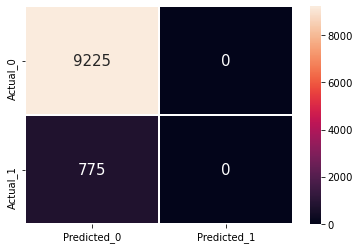

In [63]:
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})

Discussion des résultats

Le modèle XGBoost avec des hyper-paramètres optimisés semble être plus performant que tous les modèles utilisés jusqu'à présent, par une marge. Ces résultats sont reflétés à la fois pour la validation croisée et les scores des tests.
Le modèle unique de XGBoost nous donne un score privé de 0,79513, ce qui représente environ 7,6% du classement privé.
Le CV et le Test AUC sont également très proches l'un de l'autre, ce qui implique une distribution similaire des données d'entraînement et de test.
Nous remarquons ici que la valeur de rappel pour l'ensemble de données CV est en fait plus élevée que l'ensemble de données d'entraînement, mais les valeurs de précision sont très faibles.
En regardant la matrice de confusion, nous voyons qu'il y a très peu de faux négatifs, mais le nombre de faux positifs est assez élevé. C'est le compromis entre le rappel et la précision que nous devons faire.
Nous avons ajusté le seuil en utilisant la courbe ROC-AUC, qui essaie de maximiser le taux de vrais positifs (que nous pouvons également voir à partir de la matrice de confusion) et également de minimiser le taux de faux positifs, qui est proche de 0,037 ici.

In [64]:
features_with_zero_importances = xgb_boosting.feature_importance[xgb_boosting.feature_importance.gain == 0]

print(f"There are {len(features_with_zero_importances)} features with Zero Gain in XGBClassifier. They are:\n")
print(features_with_zero_importances.features.values)

There are 207 features with Zero Gain in XGBClassifier. They are:

['TOTAL_TERM_LAST_MEAN' 'TOTAL_TERM_MEAN_ACTIVE_MEAN'
 'TOTAL_TERM_MEAN_MEAN' 'NONLIVINGAPARTMENTS_AVG'
 'NAME_TYPE_SUITE_MEAN_LAST_5' 'FLAG_DOCUMENT_8'
 'TOTAL_TERM_MEAN_YEAR_REST_SUM' 'NONLIVINGAPARTMENTS_MEDI'
 'FLAG_DOCUMENT_5' 'NONLIVINGAPARTMENTS_MODE' 'NONLIVINGAREA_AVG'
 'NONLIVINGAREA_MEDI' 'WALLSMATERIAL_MODE_0' 'OBS_DEF_30_MUL'
 'NUM_INSTALMENT_NUMBER_MAX_MAX' 'WALLSMATERIAL_MODE_1'
 'NUM_INSTALMENT_NUMBER_MAX_MEAN' 'NUM_INSTALMENT_NUMBER_MAX_SUM'
 'FLAG_DOCUMENT_3' 'NUM_INSTALMENT_VERSION_MEAN_MEAN' 'OBS_DEF_60_MUL'
 'YEARS_BUILD_AVG' 'YEARS_BUILD_MEDI' 'NAME_TYPE_SUITE_1'
 'NAME_GOODS_CATEGORY_MEAN_LAST_5' 'FLAG_EMAIL' 'NAME_TYPE_SUITE_0'
 'INSTALLMENTS_AMT_PAYMENT_MAX_MEAN_INCOME_RATIO'
 'INSTALLMENTS_AMT_PAYMENT_MEAN_LAST_1_YEAR_INCOME_RATIO'
 'INSTALLMENTS_AMT_PAYMENT_MEAN_MAX_INCOME_RATIO'
 'INSTALLMENTS_AMT_PAYMENT_MEAN_MEAN_INCOME_RATIO'
 'INSTALLMENTS_AMT_PAYMENT_MEAN_SUM_INCOME_RATIO'
 'INSTALLMENTS

Importance des fonctionnalités
Les méthodes basées sur l'arborescence donnent une importance raisonnable aux fonctionnalités. Nous voyons que la caractéristique de score la plus élevée selon Gini Gain est la caractéristique EXT_SOURCE_MEAN, qui est la moyenne de toutes les valeurs EXT_SOURCE. Nous voyons de nombreuses fonctionnalités générées à partir de EXT_SOURCE comme les meilleures fonctionnalités. Nous voyons également la moyenne TARGET de 500 voisins comme le cinquième facteur de score le plus élevé. Parmi les autres fonctionnalités, nous remarquons que les fonctionnalités générées à partir des interactions catégorielles dans la table application_train ont également obtenu un score élevé par le modèle.
Parmi les 1236 fonctionnalités, nous constatons que 48 fonctionnalités ont exactement 0 Gini Gain, et nous ferions mieux de les supprimer si nous devions utiliser ce classificateur.

In [65]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : xgb_boosting.test_preds_proba_mean}).to_csv('XGBoost_3folds_final.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f XGBoost_3folds_final.csv -m "My TVD XGBoost 3 folds submission"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk
Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/270k [00:00<?, ?B/s]
  3%|2         | 8.00k/270k [00:00<00:05, 49.2kB/s]
 80%|########  | 216k/270k [00:00<00:00, 981kB/s]  
100%|##########| 270k/270k [00:02<00:00, 104kB/s]


In [66]:
with open('xgb_imp_feats.pkl','wb') as f:
    pickle.dump(xgb_boosting.feature_importance, f)
with open('xgb_cv_preds.pkl', 'wb') as f:
    pickle.dump(xgb_boosting.cv_preds_proba, f)
with open('xgb_test_preds.pkl', 'wb') as f:
    pickle.dump(xgb_boosting.test_preds_proba_mean, f)

#### Analysing the Feature Importances From XGBoost

> Analysons l'importance des caractéristiques des caractéristiques obtenues à partir du modèle XGBoost.

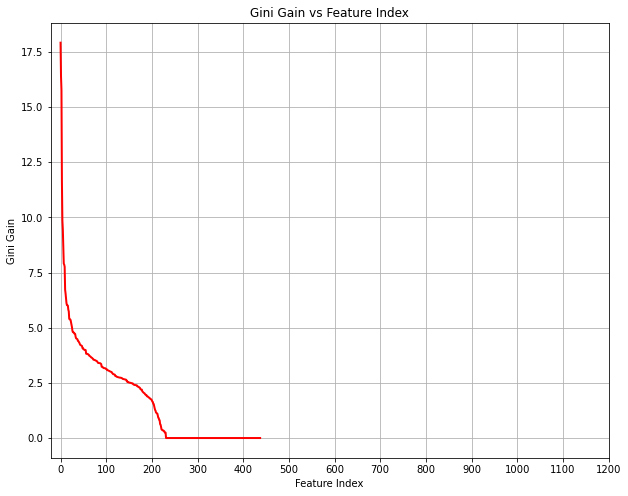

In [67]:
#plotting the importance vs feature index for the features
plt.figure(figsize = (10,8))
plt.plot(list(range(len(xgb_boosting.feature_importance))), xgb_boosting.feature_importance.gain, color = 'r', linewidth = 2)
plt.xlabel('Feature Index')
plt.ylabel('Gini Gain')
plt.xticks(list(range(0,1300,100)))
plt.grid()
plt.title("Gini Gain vs Feature Index")
plt.show()

> D'après la figure ci-dessus, nous remarquons qu'il y a un point de coude à environ 100 caractéristiques, après quoi le gain chute très rapidement. Essayons d'exclure ces 100 premières caractéristiques les mieux notées et essayons d'observer plus de caractéristiques.

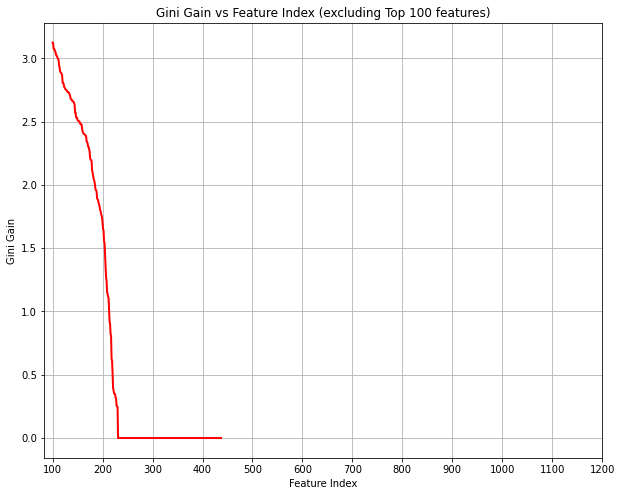

In [68]:
#plotting the importance vs feature index for the features
plt.figure(figsize = (10,8))
plt.plot(list(range(len(xgb_boosting.feature_importance)-100)), xgb_boosting.feature_importance.gain.iloc[100:], color = 'r', linewidth = 2)
plt.xlabel('Feature Index')
plt.ylabel('Gini Gain')
plt.xticks(ticks = list(range(0,1200,100)), labels = list(range(100,1300,100)))
plt.grid()
plt.title("Gini Gain vs Feature Index (excluding Top 100 features)")
plt.show()

> Ici encore, nous voyons un point de baisse de l'importance des caractéristiques/gain de gini à un indice de caractéristiques à 250 features (était compris entre 500 et 600 features). Nous allons donc prendre les 250 (était 600) principales features et essayer de modéliser le XGBoostClassifier avec les mêmes paramètres sur cet ensemble réduit de paramètres, et comparer les performances.

## GPU XGBoost sur un ensemble de features réduit

In [69]:
#reducing the feature set
#taking the top 600 scoring features
train_data_250 = train_data[xgb_boosting.feature_importance.features.iloc[:250]] #était 600
test_data_250 = test_data[xgb_boosting.feature_importance.features.iloc[:250]] #était 600

print(f"Training Data Shape with reduced feature set = {train_data_250.shape}") #était {train_data_600.shape}
print(f"Test Data Shape with reduced feature set = {test_data_250.shape}") #était test_data_600.shape}

Training Data Shape with reduced feature set = (10000, 250)
Test Data Shape with reduced feature set = (10000, 250)


### Training the model

In [70]:
#training on the already optimized params above
xgb_boosting_250 = Boosting(train_data_250, target_train, test_data_250, params, random_state = 98, save_model_to_pickle = True)
xgb_boosting_250.train(booster = 'xgboost', pickle_name = '250feats')

Fitting the xgboost on Training Data with 3 fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation

	Fold Number 1

[0]	validation_0-auc:0.73303	validation_1-auc:0.70366
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[400]	validation_0-auc:0.80217	validation_1-auc:0.76374
[800]	validation_0-auc:0.81198	validation_1-auc:0.76866
[1200]	validation_0-auc:0.81773	validation_1-auc:0.77162
[1600]	validation_0-auc:0.82280	validation_1-auc:0.77245
[2000]	validation_0-auc:0.82663	validation_1-auc:0.77366
[2400]	validation_0-auc:0.82987	validation_1-auc:0.77374
Stopping. Best iteration:
[2330]	validation_0-auc:0.82930	validation_1-auc:0.77395


	Fold Number 2

[0]	validation_0-auc:0.74383	validation_1-auc:0.69172
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rou

In [71]:
#displaying the results and metrics
xgb_boosting_250.results()
#displaying top 50 important features
xgb_boosting_250.feat_importances_show(50)

Train Results:

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.03577622026205063

	ROC-AUC Score = 0.8126220124136725
	Precision Score = 0.1812247435498912
	Recall Score = 0.752258064516129
CV Results:
	ROC-AUC Score = 0.7750441122475741
	Precision Score = 0.11390312448338569
	Recall Score = 0.8890322580645161
Confusion, Precision and Recall Matrix on CV data:


TypeError: 'bool' object is not callable

In [72]:
conf_mat

,Predicted_0,Predicted_1
Actual_0,9225,0
Actual_1,775,0


<AxesSubplot:>

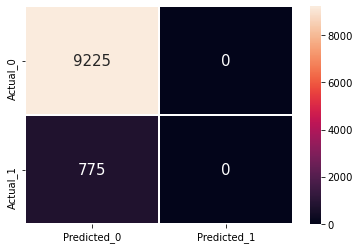

In [73]:
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})

Discussion des résultats

D'après les résultats, nous observons que l'écart entre le CV et le score Train ROC-AUC s'est réduit, ce qui signifie un sur-ajustement un peu moindre par rapport au modèle avec les 1236 caractéristiques.
On remarque également que le Recall s'est amélioré, tandis que la Precision a très légèrement diminué.
Le point ci-dessus peut également être réalisé en examinant la matrice de confusion, qui a signalé un nombre plus élevé de vrais positifs maintenant.
Le score privé s'est également amélioré en supprimant les fonctionnalités. Cela implique qu'il pourrait y avoir eu des fonctionnalités bruyantes, qui causaient une dégradation des performances.
Les Importances des Fonctionnalités restent plus ou moins les mêmes.
Ainsi, nous pouvons conclure qu'en supprimant les ensembles de fonctionnalités, nous avons à la fois amélioré les performances et réduit la complexité de calcul de notre modèle.

In [74]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : xgb_boosting_250.test_preds_proba_mean}).to_csv('XGBoost_250_features.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f XGBoost_250_features.csv -m "My TVD xgb_boosting_250_features"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk
Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/275k [00:00<?, ?B/s]
  3%|2         | 8.00k/275k [00:00<00:07, 36.0kB/s]
 32%|###2      | 88.0k/275k [00:00<00:00, 211kB/s] 
 41%|####      | 112k/275k [00:00<00:00, 175kB/s] 
 49%|####9     | 136k/275k [00:03<00:05, 28.0kB/s]
 93%|#########3| 256k/275k [00:03<00:00, 82.0kB/s]
100%|##########| 275k/275k [00:04<00:00, 57.1kB/s]


In [75]:
with open('xgb_imp_feats_250feats.pkl','wb') as f:
    pickle.dump(xgb_boosting_250.feature_importance, f)
with open('xgb_cv_preds_250feats.pkl', 'wb') as f:
    pickle.dump(xgb_boosting_250.cv_preds_proba, f)
with open('xgb_test_preds_250feats.pkl', 'wb') as f:
    pickle.dump(xgb_boosting_250.test_preds_proba_mean, f)
with open('Final_XGBOOST_Selected_features.pkl', 'wb') as f:
    pickle.dump(xgb_boosting_250.feature_importance.features.values, f)

# LightGBM

## Bayesian Optimization

In [76]:
def lgbm_evaluation(num_leaves, max_depth, min_split_gain, min_child_weight,
                    min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.
    
    Inputs: Hyperparamters to be tuned.
        num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda
        
    Returns:
        CV ROC-AUC Score
    '''
    
    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : 266
    }
    stratified_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 33)
    
    cv_preds = np.zeros(train_data.shape[0])
    for train_indices, cv_indices in stratified_cv.split(train_data, target_train):

        x_tr = train_data.iloc[train_indices]
        y_tr = target_train.iloc[train_indices]
        x_cv = train_data.iloc[cv_indices]
        y_cv = target_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                eval_metric='auc', verbose = False, early_stopping_rounds=200)

        cv_preds[cv_indices] = lgbm_clf.predict_proba(x_cv, num_iteration = lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(target_train, cv_preds)

In [77]:
bopt_lgbm = BayesianOptimization(lgbm_evaluation, {'num_leaves' : (25,50),
                                                   'max_depth' : (6,11),
                                                   'min_split_gain' : (0, 0.1),
                                                   'min_child_weight' : (5,80),
                                                   'min_child_samples' : (5,80),
                                                   'subsample' : (0.5,1),
                                                   'colsample_bytree' : (0.5,1),
                                                   'reg_alpha' : (0.001, 0.3),
                                                   'reg_lambda' : (0.001, 0.3)},
                                 random_state = 4976)

bayesian_optimization = bopt_lgbm.maximize(n_iter = 6, init_points = 4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7743   |  0.9839   |  9.624    |  65.58    |  60.98    |  0.08223  |  39.55    |  0.1133   |  0.2049   |  0.6677   |
|  2        |  0.7789   |  0.5453   |  10.99    |  36.09    |  42.7     |  0.02383  |  43.12    |  0.1206   |  0.1951   |  0.8343   |
|  3        |  0.7761   |  0.7313   |  9.478    |  47.08    |  53.08    |  0.0249   |  36.94    |  0.2417   |  0.1072   |  0.5916   |
|  4        |  0.7823   |  0.5671   |  7.674    |  26.69    |  8.717    |  0.004937 |  31.48    |  0.118    |  0.09472  |  0.9706   |
|  5        |  0.7835   |  0.843    |  10.6     |  46.36    |  16.37    |  0.0809   |  31.43    |  0.03722  |  0.2425   |  0.8722   |
|  6        |  0.7831   |  0.6559   |  6.891    |  26.95    | 

In [78]:
#extracting the best parameters
target_values = []
for result in bopt_lgbm.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print("Best Hyperparameters obtained are:\n")
print(best_params)

Best Hyperparameters obtained are:

{'colsample_bytree': 1.0, 'max_depth': 6.0, 'min_child_samples': 70.5734206650114, 'min_child_weight': 5.0, 'min_split_gain': 0.1, 'num_leaves': 26.87337085199306, 'reg_alpha': 0.001, 'reg_lambda': 0.3, 'subsample': 0.5}


## Training on Optimized Hyper-parameters

In [79]:
params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : 39,
        'max_depth' : 9,
        'min_split_gain' : 0.030820727751758883,
        'min_child_weight' : 30.074868967458226,
        'min_child_samples' : 31,
        'subsample': 0.7653763123038788,
        'subsample_freq' : 1,
        'colsample_bytree' : 0.6175714684701181,
        'reg_alpha' : 0.15663020002553255,
        'reg_lambda' : 0.22503178038757748,
        'verbosity' : -1,
        'seed' : 266
    }
lgbm_boosting = Boosting(train_data, target_train, test_data, params, random_state = 98, save_model_to_pickle = True)
lgbm_boosting.train(booster = 'lightgbm')

Fitting the lightgbm on Training Data with 3 fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation

	Fold Number 1

Training until validation scores don't improve for 200 rounds
[400]	training's auc: 0.843104	training's binary_logloss: 0.218462	valid_1's auc: 0.767309	valid_1's binary_logloss: 0.235865
[800]	training's auc: 0.872626	training's binary_logloss: 0.200802	valid_1's auc: 0.775328	valid_1's binary_logloss: 0.232927
Early stopping, best iteration is:
[899]	training's auc: 0.878482	training's binary_logloss: 0.197483	valid_1's auc: 0.776367	valid_1's binary_logloss: 0.232769

	Fold Number 2

Training until validation scores don't improve for 200 rounds
[400]	training's auc: 0.844049	training's binary_logloss: 0.216178	valid_1's auc: 0.758892	valid_1's binary_logloss: 0.240824
[800]	training's auc: 0.874117	training's binary_logloss: 0.198463	valid_1's auc: 0.767981	valid_1's binary_logloss: 0.238318
Early stopping, best iteration is:
[843]	training's a

In [80]:
#displaying the results and metrics
lgbm_boosting.results()
#displaying top 50 important features
lgbm_boosting.feat_importances_show(50)

Train Results:

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.04439480025489154

	ROC-AUC Score = 0.8671516041612028
	Precision Score = 0.2380178716490658
	Recall Score = 0.7561290322580645
CV Results:
	ROC-AUC Score = 0.7798138998164175
	Precision Score = 0.12974492870054227
	Recall Score = 0.8335483870967741
Confusion, Precision and Recall Matrix on CV data:


TypeError: 'bool' object is not callable

In [81]:
features_with_zero_importances  = lgbm_boosting.feature_importance[lgbm_boosting.feature_importance.gain == 0]

print(f"There are {len(features_with_zero_importances)} features with Zero Gain in LGBMClassifier. They are:\n")
print(features_with_zero_importances.features.values)

There are 144 features with Zero Gain in LGBMClassifier. They are:

['MIN_PAYMENT_TOTAL_RATIO_MIN_ACTIVE' 'TOTAL_TERM_LAST_MEAN'
 'MIN_PAYMENT_TOTAL_RATIO_MEAN_YEAR_0' 'AMT_APPLICATION_MEAN_LAST_5'
 'AMT_ANNUITY_SUM_LAST_5' 'MONTHS_BALANCE_MAX' 'MONTHS_BALANCE_MAX_MEAN'
 'SUM_FLAGS_DOCUMENTS' 'INSTALLMENTS_AMT_PAYMENT_SUM_SUM_INCOME_RATIO'
 'TOTAL_TERM_MEAN_YEAR_REST_SUM' 'TOTAL_TERM_MEAN_ACTIVE_MEAN'
 'TOTAL_TERM_MEAN_MEAN' 'MIN_PAYMENT_RATIO_MEAN' 'AMT_ANNUITY_MEAN_LAST_5'
 'AMT_INSTALMENT_MAX_MEAN' 'LIVINGAPARTMENTS_AVG'
 'LIVE_REGION_NOT_WORK_REGION' 'AMT_INSTALMENT_MEAN_LAST_1_YEAR'
 'AMT_ANNUITY_MAX_LAST_5' 'INTEREST_RATE_MEAN_LAST_5'
 'INSTALLMENTS_ANNUITY_AMT_INSTALMENT_SUM_MAX_RATIO'
 'SELLERPLACE_AREA_MEAN_LAST_5' 'NAME_GOODS_CATEGORY_MEAN_LAST_5'
 'REG_REGION_NOT_WORK_REGION' 'NUM_INSTALMENT_NUMBER_MAX_SUM'
 'NUM_INSTALMENT_VERSION_MEAN_MEAN' 'NUM_INSTALMENT_NUMBER_MAX_MEAN'
 'AMT_GOODS_PRICE_MAX_LAST_5' 'AMT_DRAWINGS_POS_CURRENT_SUM'
 'NUM_INSTALMENT_NUMBER_MAX_MAX' 'OBS_DE

Results Discussion

Firstly we see that the LightGBM model performs inferiorly as compared to XGBoost model, as observed from the results of Private Score on Test Data. This is contrary to the fact that LightGBM showed higher AUC value for CV dataset as compared to XGBoost.
Again the Recall values are quite high, which is a good thing, but the precision values are again not good. The high recall value suggests that most of the actual defaulters are predicted by the model, but the low precision also indicates that model predicts lots of people as defaulters, while they actually aren't.
We see from the Confusion Matrix that the number of True Positives are lesser in the Case of LightGBM compared to XGBoost. However, the total False Positives are also slightly lesser for LightGBM.
We also observe that bost the boosting methods show the highest number of True Positives among all the models. This is aided by the high Recall value for these models as well.
Feature Importances
We see that the feature TARGET Mean of 500 neighbors scores quite high as compared to all other features. The difference between gain is very significant. This implies that this feature is indeed a very important feature.
Similar to all other ensembles, here too, the EXT_SOURCE features score high again.
One of the interesting high scoring feature for LightGBM is the REGIONS_RATING_INCOME_MUL_1 which is the multiplication of Region Rating of Client with his Income. It has been treated as a categorical feature and has been response encoded, and gives better result than as a numeric feature.
We also observe that there are around 41 features which had 0 gain in LGBMClassifier for splitting. This means they are not useful for our classifier.

In [82]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : lgbm_boosting.test_preds_proba_mean}).to_csv('LGBM_3folds.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f LGBM_3folds.csv -m "LightGBM - 3 Folds Submission"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk
Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/275k [00:00<?, ?B/s]
  3%|2         | 8.00k/275k [00:00<00:04, 66.9kB/s]
 79%|#######8  | 216k/275k [00:00<00:00, 1.13MB/s] 
100%|##########| 275k/275k [00:03<00:00, 86.0kB/s]


In [83]:
with open('lgbm_imp_feats.pkl','wb') as f:
    pickle.dump(lgbm_boosting.feature_importance, f)
with open('lgbm_cv_preds.pkl', 'wb') as f:
    pickle.dump(lgbm_boosting.cv_preds_proba, f)
with open('lgbm_test_preds.pkl', 'wb') as f:
    pickle.dump(lgbm_boosting.test_preds_proba_mean, f)

# Empilement de Classificateurs (*Stacking Classifiers*)

> Dans cette section, nous essaierons d'empiler __les meilleurs classificateurs__ que nous avons utilisés ci-dessus, notamment :

    <1> la régression logistique, 
    <2> la SVM linéaire, 
    <3> la forêt aléatoire, 
    <4> le XGBoost sur les features réduites, et,
    <5> le LightGBM. 

> Nous entraînerons un modèle de classification LightGBM sur les prédictions hors pli pour tous les classificateurs ci-dessus. Nous utiliserons à nouveau la technique d'optimisation bayésienne pour régler les hyperparamètres.

In [84]:
def load_stacking_data(file_directory = '', verbose = True):
    '''
    Objective function to prepare the Stacking Training and Test Data. The training data is the
    Out-Of-Fold predictions of each base learners, and the test data are the predicted probabilities
    on the Test data.
    
    Inputs:
        file_directory: str, default = ''
            The path of directory where the predictions are located. Insert '/' in the end
        verbose: bool, default = True
            Whether to keep verbosity or not
    
    Returns:
        Training stacking data, Test stacking data, Trainig target values
    '''

    if verbose:
        print("Loading the CV (out-of-folds) and Test Predictions from Base Models...")
        start = datetime.now()
        
    global sgd_lr_l2_cv, sgd_svm_cv, rf_cv, xgb_cv, lgbm_cv
    global sgd_lr_l2_test, sgd_svm_test, rf_test, xgb_test, lgbm_test
    
    with open(file_directory + 'SGD_LR_L2_Penalty_CV_Preds.pkl', 'rb') as f:
        sgd_lr_l2_cv = pickle.load(f)
    with open(file_directory + 'SGD_Linear_SVM_CV_Preds.pkl', 'rb') as f:
        sgd_svm_cv = pickle.load(f)
    with open(file_directory + 'Random_Forest_CV_Preds.pkl', 'rb') as f:
        rf_cv = pickle.load(f)
    with open(file_directory + 'xgb_cv_preds_250feats.pkl', 'rb') as f:
        xgb_cv = pickle.load(f)
    with open(file_directory + 'lgbm_cv_preds.pkl', 'rb') as f:
        lgbm_cv = pickle.load(f)

    #loading the Predicted Probabilities of Test Set
    sgd_lr_l2_test = pd.read_csv(file_directory + 'SGD_LR_L2_penalty.csv')['TARGET'] #correction, était : SGD_L2_Penalty.csv
    sgd_svm_test = pd.read_csv(file_directory + 'SGD_Linear_SVM.csv')['TARGET']
    rf_test = pd.read_csv(file_directory + 'Random_Forest.csv')['TARGET']
    xgb_test = pd.read_csv(file_directory + 'XGBoost_250_features.csv')['TARGET']
    lgbm_test = pd.read_csv(file_directory + 'LGBM_3folds.csv')['TARGET']
    
    if verbose:
        print("Making the Training and Test Dataset for Stacking...")
    #defining the training and test datasets
    stack_train = pd.DataFrame(np.stack([sgd_lr_l2_cv, sgd_svm_cv, rf_cv, xgb_cv, lgbm_cv], axis = 1), 
                              columns = ['SGD_LR_L2', 'SGD_SVM', 'RF', 'XGB', 'LGBM'])
    stack_target = target_train.copy()
    stack_test = pd.concat([sgd_lr_l2_test, sgd_svm_test, rf_test, xgb_test, lgbm_test], axis = 1)
    stack_test.columns = ['SGD_LR_L2', 'SGD_SVM', 'RF', 'XGB', 'LGBM']
    
    if verbose:
        print("Done.")
        print(f"Time elapsed = {datetime.now() - start}")
        print(f"Shape of stacking training data = {stack_train.shape}")
        print(f"Shape of stacking test data = {stack_test.shape}")
        print(f"Shape of stacking training class labels = {stack_target.shape}")
        
    return stack_train, stack_test, stack_target

In [85]:
stack_train, stack_test, stack_target = load_stacking_data()

Loading the CV (out-of-folds) and Test Predictions from Base Models...
Making the Training and Test Dataset for Stacking...
Done.
Time elapsed = 0:00:00.846704
Shape of stacking training data = (10000, 5)
Shape of stacking test data = (10000, 5)
Shape of stacking training class labels = (10000,)


## Bayesian Optimization

In [86]:
def lgbm_stacker_optimization(num_leaves, max_depth, min_split_gain, min_child_weight,
                             min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Function for Bayesian Optimization of LightGBM's Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.
    
    Inputs: Hyperparamters to be tuned.
        num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda
        
    Returns:
        CV ROC-AUC Score
    '''
    
    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : 8956
    }
    stratified_cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 96)
    
    cv_preds = np.zeros(stack_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(stack_train, stack_target):

        x_tr = stack_train.iloc[train_indices]
        y_tr = stack_target.iloc[train_indices]
        x_cv = stack_train.iloc[cv_indices]
        y_cv = stack_target.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                eval_metric='auc', verbose = False, early_stopping_rounds=200)

        cv_preds[cv_indices] = lgbm_clf.predict_proba(x_cv, num_iteration = lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(stack_target, cv_preds)

In [87]:
bopt_stacking = BayesianOptimization(lgbm_stacker_optimization, {'num_leaves' : (2,50),
                                                   'max_depth' : (2,6),
                                                   'min_split_gain' : (0, 0.5),
                                                   'min_child_weight' : (1,80),
                                                   'min_child_samples' : (5,80),
                                                   'subsample' : (0.001,1),
                                                   'colsample_bytree' : (0.2,1),
                                                   'reg_alpha' : (0.00001, 0.3),
                                                   'reg_lambda' : (0.00001, 0.3)},
                                 random_state = 6569)

bayesian_optimization = bopt_stacking.maximize(n_iter = 10, init_points = 10)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7825   |  0.7955   |  5.417    |  44.35    |  38.21    |  0.4826   |  19.51    |  0.06595  |  0.05161  |  0.5286   |
|  2        |  0.7817   |  0.7451   |  4.236    |  47.4     |  58.14    |  0.1048   |  47.96    |  0.2365   |  0.249    |  0.7261   |
|  3        |  0.7798   |  0.6329   |  4.483    |  32.69    |  24.78    |  0.3669   |  2.316    |  0.09315  |  0.09452  |  0.4668   |
|  4        |  0.7802   |  0.4877   |  4.83     |  70.16    |  64.09    |  0.2487   |  22.81    |  0.2672   |  0.01726  |  0.4483   |
|  5        |  0.4995   |  0.3603   |  5.12     |  68.84    |  64.73    |  0.1149   |  9.906    |  0.1364   |  0.05073  |  0.1665   |
|  6        |  0.7817   |  0.273    |  2.604    |  26.55    | 

In [88]:
#extracting the best parameters
target_values = []
for result in bopt_stacking.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print("Best Hyperparameters obtained are:\n")
print(best_params)

Best Hyperparameters obtained are:

{'colsample_bytree': 1.0, 'max_depth': 2.0, 'min_child_samples': 80.0, 'min_child_weight': 66.04500079993853, 'min_split_gain': 0.5, 'num_leaves': 30.024810797216656, 'reg_alpha': 0.3, 'reg_lambda': 0.3, 'subsample': 1.0}


## Training on Optimized Hyper-parameters

In [89]:
params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : 3,
        'max_depth' : 5,
        'min_split_gain' : 0.10600273039230335,
        'min_child_weight' : 25.462380118091218,
        'min_child_samples' : 32,
        'subsample': 0.5194861616343917,
        'subsample_freq' : 1,
        'colsample_bytree' : 0.653278704808709,
        'reg_alpha' : 0.17957695696091033,
        'reg_lambda' : 0.13028216024797987,
        'verbosity' : -1,
        'seed' : 266
    }
stacker_boosting = Boosting(stack_train, stack_target, stack_test, params, random_state = 96, num_folds = 4)
stacker_boosting.train(booster = 'lightgbm')

Fitting the lightgbm on Training Data with 4 fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation

	Fold Number 1

Training until validation scores don't improve for 200 rounds
[400]	training's auc: 0.792199	training's binary_logloss: 0.230084	valid_1's auc: 0.792103	valid_1's binary_logloss: 0.22851
[800]	training's auc: 0.795278	training's binary_logloss: 0.227754	valid_1's auc: 0.792416	valid_1's binary_logloss: 0.226601
Early stopping, best iteration is:
[871]	training's auc: 0.795806	training's binary_logloss: 0.227535	valid_1's auc: 0.792492	valid_1's binary_logloss: 0.226519

	Fold Number 2

Training until validation scores don't improve for 200 rounds
[400]	training's auc: 0.797112	training's binary_logloss: 0.227691	valid_1's auc: 0.776366	valid_1's binary_logloss: 0.235051
[800]	training's auc: 0.799768	training's binary_logloss: 0.225201	valid_1's auc: 0.77739	valid_1's binary_logloss: 0.234216
Early stopping, best iteration is:
[675]	training's auc

Train Results:

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.023966109114220157

	ROC-AUC Score = 0.7918673310604074
	Precision Score = 0.17174105823233815
	Recall Score = 0.7496774193548387
CV Results:
	ROC-AUC Score = 0.7846826470845355
	Precision Score = 0.0976063829787234
	Recall Score = 0.9470967741935484


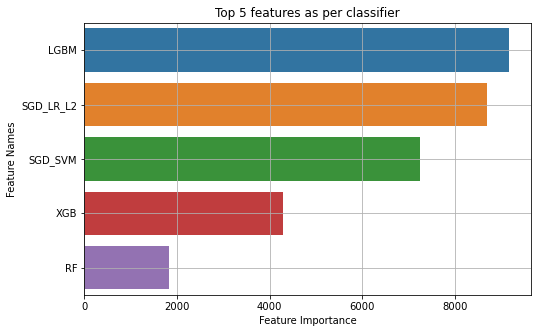

In [90]:
#displaying the results and metrics
stacker_boosting.results(confusion_matrix = False, cv_test_distribution = False)
#displaying top 50 important features
stacker_boosting.feat_importances_show(5, figsize = (8,5))

Discussion des résultats

À partir du classificateur d'empilement, nous voyons que le CV et le score privé obtenus sont les plus élevés que tous les classificateurs de base.
Nous observons également que la valeur de rappel est très élevée, mais la valeur de précision a encore baissé.
Ce modèle d'empilement, cependant, fonctionne moins bien qu'un seul modèle XGB, cela pourrait être dû au faible nombre de modèles de base. De plus, les classificateurs de base peuvent également être corrélés les uns aux autres, ce qui peut également avoir entraîné de faibles performances avec l'empilement.
D'après l'importance des fonctionnalités de LightGBM, nous voyons que les prédictions du modèle de base LGBM obtiennent le score le plus élevé parmi tous les classificateurs de base, suivis par les prédictions de XGB. La moindre importance revient aux prédictions du Random Forest Classifier.

In [91]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : stacker_boosting.test_preds_proba_mean}).to_csv('LGBM_Stacker_4_Fold.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f LGBM_Stacker_4_Fold.csv -m "My TVD LightGBM Stacker with Data from 5 base classifiers"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk
Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/275k [00:00<?, ?B/s]
  3%|2         | 8.00k/275k [00:00<00:05, 48.0kB/s]
 79%|#######8  | 216k/275k [00:00<00:00, 913kB/s]  
100%|##########| 275k/275k [00:02<00:00, 107kB/s]


# Mélange de prédictions

Sur la base des features importances obtenues à partir de l'empilement de classificateurs, nous allons maintenant essayer de mélanger les prédictions de tous les classificateurs, dans un rapport proportionnel à leurs importances de caractéristiques ci-dessus.

In [92]:
#getting the feature importance from stacking classifier
feat_imp_gain_stacking = stacker_boosting.feature_importance
#normalizing the gain values to lie between 0 to 1
feat_imp_gain_stacking.gain = feat_imp_gain_stacking.gain / sum(feat_imp_gain_stacking.gain)
print("Normalized Gain Value as per Stacking Classifier for each base models are:")
display(feat_imp_gain_stacking)

Normalized Gain Value as per Stacking Classifier for each base models are:


,features,gain
0,LGBM,0.293881
2,SGD_LR_L2,0.278204
3,SGD_SVM,0.232043
4,XGB,0.137480
1,RF,0.058392


Results on CV Dataset:

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.07293073864287146

ROC-AUC Score CV = 0.7847764315062505
Precison Score CV = 0.16652482269503546
Recall Score CV = 0.7574193548387097
Confusion Matrix of CV data:


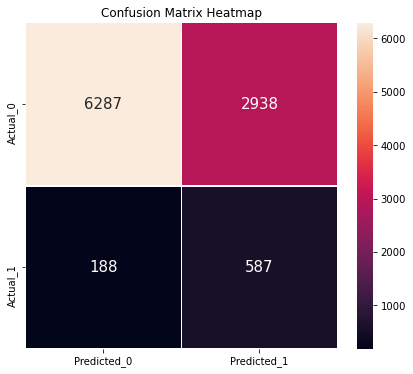

In [93]:
blended_cv_preds = sgd_lr_l2_cv * 0.020748 + sgd_svm_cv * 0.064836 + rf_cv * 0.003137 + xgb_cv * 0.287625 + lgbm_cv * 0.623653
blended_test_preds = sgd_lr_l2_test * 0.020748 + sgd_svm_test * 0.064836 + rf_test * 0.003137 + xgb_test * 0.287625 + lgbm_test * 0.623653

#tuning the threshold again
fpr, tpr, threshold = roc_curve(target_train, blended_cv_preds)
j = tpr - fpr
best_threshold = threshold[np.argmax(j)]
#calculating the metrics values
print("Results on CV Dataset:")
print("="*100)
print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {best_threshold}\n")
print(f"ROC-AUC Score CV = {roc_auc_score(target_train, blended_cv_preds)}")
print(f"Precison Score CV = {precision_score(target_train, np.where(blended_cv_preds >= best_threshold, 1, 0))}")
print(f"Recall Score CV = {recall_score(target_train, np.where(blended_cv_preds >= best_threshold, 1, 0))}") 

print('=' * 100)
print("Confusion Matrix of CV data:")
conf_mat = confusion_matrix(target_train, np.where(blended_cv_preds >= best_threshold, 1, 0))
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (7,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
plt.show()
print("="*100)

Discussion des résultats

Nous voyons que ce modèle mixte montre le deuxième CV ROC-AUC le plus élevé parmi tous les modèles.
C'était un processus un peu plus heuristique, car nous avons juste utilisé l'importance de chaque modèle obtenu à partir de Stacking Classifier comme poids à mélanger, et il s'avère que cela donne le meilleur ROC-AUC parmi tous les modèles jusqu'à présent, sur Test Dataset.
Cependant, les valeurs de rappel et de précision ne sont pas très bonnes. Cela peut nécessiter un réglage de seuil un peu plus rigoureux pour améliorer un peu plus les résultats.

In [94]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : blended_test_preds}).to_csv('Blending_all.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f Blending_all.csv -m "My TVD Blending of results of 5 base classifiers"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk
Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/274k [00:00<?, ?B/s]
 29%|##9       | 80.0k/274k [00:00<00:00, 802kB/s]
 58%|#####8    | 160k/274k [00:01<00:01, 82.7kB/s]
 73%|#######2  | 200k/274k [00:03<00:01, 43.2kB/s]
 82%|########1 | 224k/274k [00:03<00:00, 51.5kB/s]
 99%|#########9| 272k/274k [00:03<00:00, 76.6kB/s]
100%|##########| 274k/274k [00:06<00:00, 44.2kB/s]


# Résumé des résultats

In [95]:
results_df = pd.DataFrame([['Random Model', np.round(0.5001812688821752, 5), '-', np.round(0.5001144672273913, 5), '-', 0.49396, 0.50128, '99.37%'],
                            ['Dominant Class', 0.0, '-', np.round(0.5010095061750377, 5), '-', 0.49530, 0.49055, '99.33%'],
                            ['SGD LogisticRegression L2', np.round(0.7472306143001007,5), np.round(0.7363947633434038,5), 
                               np.round(0.7971552091816715,5), np.round(0.7907336258401249,5), 0.77848, 0.78283, '56.51%'],
                            ['SGD Linear SVM', np.round(0.7457804632426989, 5), np.round(0.7369587109768378, 5), 
                                      np.round(0.7980921976293923, 5), np.round(0.7915505286711596, 5), 0.77955, 0.78299, '55.08%'],
                            ['RandomForestClassifier', np.round(0.8091440080563947, 5), np.round(0.7290231621349446, 5),
                                      np.round(0.8321734127843617, 5), np.round(0.7775905555143139, 5), 0.76457, 0.77192, '65.24%'],
                            ['ExtraTreesClassifier', np.round(0.9113393756294058, 5), np.round(0.60269889224572, 5),
                                      np.round(0.932770629575878, 5), np.round(0.7720865925495278, 5), 0.76164, 0.77116, '66.44%'],
                            ['XGBoostClassifier', np.round(0.7999194360523666, 5), np.round(0.8642497482376637, 5), 
                                      np.round(0.8743687606924759, 5), np.round(0.8051278105368123, 5), 0.79513, 0.79729, '6.30%'],
                            ['XGBoostClassifier - 250 Features', np.round(0.8010070493454179, 5), np.round(0.8686807653575025, 5), 
                                      np.round(0.8702218691280733, 5), np.round(0.8046982367776565, 5), 0.79563, 0.79525, '7.26%'],
                            ['LightGBMClassifier', np.round(0.8262638469284995, 5), np.round(0.8406042296072508, 5), 
                                      np.round(0.9045251207764887, 5), np.round(0.8061038615922426, 5), 0.79428, 0.79465, '10.65%'],
                            ['StackingClassifier', np.round(0.736797583081571, 5), np.round(0.9398590130916414, 5),
                                      np.round(0.807872515009856, 5), np.round(0.8066312491185976, 5), 0.79528, 0.79620, '7.23%'],
                            ['Blending Results', '-', np.round(0.7424370594159114, 5), '-', np.round(0.8066127071870559, 5),
                                      0.79565, 0.79707, '6.24%']], 
                          columns = ['Model', 'Train Recall', 'CV Recall', 'Train ROC-AUC', 'CV ROC-AUC', 
                                     'Private Score (ROC-AUC)', 'Public Score (ROC-AUC)', 'Percentile Private LB'], index = list(range(1,12)))

display(results_df)

,Model,Train Recall,CV Recall,Train ROC-AUC,CV ROC-AUC,Private Score (ROC-AUC),Public Score (ROC-AUC),Percentile Private LB
1,Random Model,0.50018,-,0.50011,-,0.49396,0.50128,99.37%
2,Dominant Class,0,-,0.50101,-,0.49530,0.49055,99.33%
3,SGD LogisticRegression L2,0.74723,0.73639,0.79716,0.79073,0.77848,0.78283,56.51%
4,SGD Linear SVM,0.74578,0.73696,0.79809,0.79155,0.77955,0.78299,55.08%
5,RandomForestClassifier,0.80914,0.72902,0.83217,0.77759,0.76457,0.77192,65.24%
6,ExtraTreesClassifier,0.91134,0.6027,0.93277,0.77209,0.76164,0.77116,66.44%
7,XGBoostClassifier,0.79992,0.86425,0.87437,0.80513,0.79513,0.79729,6.30%
8,XGBoostClassifier - 250 Features,0.80101,0.86868,0.87022,0.8047,0.79563,0.79525,7.26%
9,LightGBMClassifier,0.82626,0.8406,0.90453,0.8061,0.79428,0.79465,10.65%
10,StackingClassifier,0.7368,0.93986,0.80787,0.80663,0.79528,0.79620,7.23%


D'après les résultats ci-dessus, nous observons que :

La valeur de rappel de validation croisée la plus élevée a été obtenue pour Stacking Classifier Model, qui est ensuite suivi par XGBoostClassifier Model.
Le CV ROC-AUC le plus élevé a été observé pour StackingClassifier, suivi par Blended Model, puis LightGBM et XGBoost. Ils sont tous assez proches les uns des autres.
Le meilleur score privé (ROC-AUC) a de nouveau été observé pour le modèle de mélange, qui a pris en considération les prédictions de tous les apprenants de base.
Tout au long du tableau, nous pouvons voir que le CV et le test ROC-AUC sont assez proches l'un de l'autre, avec un écart constant d'environ 0,1 entre eux. Ainsi, le CV peut être utilisé comme une mesure judicieuse pour garder une trace du score Private LB.
Dans l'ensemble, les modèles Boosting ont surpassé les autres modèles par une marge, comme le montrent à la fois le CV et le score privé. Cependant, les modèles linéaires comme Logistic Regression et Linear SVM ont donné de meilleurs résultats que RandomForest Ensemble. Cela pourrait être dû à la grande dimensionnalité de l'ensemble de données

# DataFrame final avec des fonctionnalités réduites pour le pipeline

Sur la base des fonctionnalités éliminées ci-dessus, nous les supprimerons des tables relationnelles, qui seront chargées en mémoire pendant le temps de production, pour être fusionnées avec les principaux points de données application_test.

In [96]:
relational_tables_prepare()

Loading the tables into memory...
Done.
Time Elapsed = 0:00:13.543312

Removing the non-useful features...
Done.
Time Elapsed = 0:00:00.114074

Merging all the tables, and saving to pickle file 'relational_table.pkl'...
Done.
Total Time taken = 0:00:14.274889


# Finaliser le PIPELINE 

In [97]:
#importing Useful DataStructures
import pandas as pd
import numpy as np

#importing Misc Libraries
import os
import gc
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

## Definition de la fonction Final Pipeline

In [98]:
class final_pipeline:
    '''
    Final Pipeline for Prediction of Test Datapoints
    
    Contains 5 member Functions:
        1. init method
        2. load_required_files method
        3. preprocessing method
        4. final_function_1 method
        5. final_function_2 method
    '''
    
    def __init__(self, file_directory = "../P7_Pret_Credit_Conso_VERGE-DEPRE_Thierry/"):
        '''
        This function is used to initialize the Class members. It also loads up the required files for pre-processing and predictions
        once instantiated.
        
        Inputs:
            self
            file_directory: str, default = ''
                Path of the directory where the file is stored
        
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.load_required_files()
        
    def load_required_files(self):
        '''
        Function to load all the required files for Pre-processing and prediction. Gets called when the 
        class gets initialized
        
        Inputs:
            self
            
        Returns:
            Pre-processed DataFrame
        '''
        
        #loading important files
        with open(self.file_directory + 'relational_table.pkl', 'rb') as f:
            self.relational_table = pickle.load(f)
        #loading final columns list
        with open(self.file_directory + 'Final_XGBOOST_Selected_features.pkl', 'rb') as f:
            self.final_cols = pickle.load(f)
        #loading te columns for modelling for ext_sources
        with open(self.file_directory + 'columns_for_ext_values_predictor.pkl', 'rb') as f:
            self.columns_for_modelling = pickle.load(f)
        #loading XGBRegressor models for predicting missing EXT_SOURCE fields
        with open(self.file_directory + 'Nan EXT source predictors/nan_EXT_SOURCE_1_xgbr_model.pkl', 'rb') as f:
            self.xgbr_ext_1 = pickle.load(f)
        with open(self.file_directory + 'Nan EXT source predictors/nan_EXT_SOURCE_2_xgbr_model.pkl', 'rb') as f:
            self.xgbr_ext_2 = pickle.load(f)
        with open(self.file_directory + 'Nan EXT source predictors/nan_EXT_SOURCE_3_xgbr_model.pkl', 'rb') as f:
            self.xgbr_ext_3 = pickle.load(f)
        #loading LGBMRegressor model for predicting Count Payments for data
        with open(self.file_directory + 'cnt_payment_predictor_lgbmr.pkl', 'rb') as f:
            self.cnt_payment_lgbmr = pickle.load(f)
        #loading the training target values
        with open(self.file_directory + 'Train_TARGET.pkl', 'rb') as f:
            self.TARGET = pickle.load(f)
        #loading KNN model for TARGET_500_neighbors feature
        with open(self.file_directory + 'KNN_model_TARGET_500_neighbors.pkl', 'rb') as f:
            self.knn_target_500_neighbors = pickle.load(f)
        #loading grouped interactions for several groupings
        file_names = ['Application_train_grouped_interactions_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE.pkl',
                      'Application_train_grouped_interactions_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE.pkl',
                      'Application_train_grouped_interactions_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME_TYPE.pkl',
                      'Application_train_grouped_interactions_NAME_EDUCATION_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE.pkl',
                      'Application_train_grouped_interactions_OCCUPATION_TYPE_ORGANIZATION_TYPE.pkl',
                      'Application_train_grouped_interactions_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY.pkl']
        self.group_interactions_tables = []
        for group_interactions_file_name in file_names:
            with open(self.file_directory + 'Grouped Interactions/' + group_interactions_file_name, 'rb') as f:
                self.group_interactions_tables.append(pickle.load(f))
        
        #loading final model for prediction
        with open(self.file_directory + 'Final Prediction XGB/' + 'clf_xgboost_fold_1_model_600feats.pkl', 'rb') as f:
            self.final_xgb_1 = pickle.load(f)
        with open(self.file_directory + 'Final Prediction XGB/' + 'clf_xgboost_fold_2_model_600feats.pkl', 'rb') as f:
            self.final_xgb_2 = pickle.load(f)
        with open(self.file_directory + 'Final Prediction XGB/' + 'clf_xgboost_fold_3_model_600feats.pkl', 'rb') as f:
            self.final_xgb_3 = pickle.load(f)
        #threshold for class label
        self.threshold = 0.04579606279730797
    
    def preprocessing(self, data):
        '''
        Function to preprocess the data into required format for predictions
        
        Inputs:
            self
            data: DataFrame
                The Test DataFrame
            
        Returns:
            None        
        '''
        
        #dropping flag columns
        flag_cols_to_drop = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12',
                    'FLAG_DOCUMENT_20']
        data = data.drop(flag_cols_to_drop, axis = 1)
        #converting age to years
        data['DAYS_BIRTH'] = data['DAYS_BIRTH'] * -1 / 365
        #removing erroneous points
        data['DAYS_EMPLOYED'][data['DAYS_EMPLOYED'] == 365243] = np.nan
        data['OBS_30_CNT_SOCIAL_CIRCLE'][data['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        data['OBS_60_CNT_SOCIAL_CIRCLE'][data['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        #filling NaN values for categorical columns with 'XNA'
        categorical_columns = data.dtypes[data.dtypes == 'object'].index.tolist()
        data[categorical_columns] = data[categorical_columns].fillna('XNA')
        #converting columns of REGION_RATING_CLIENT to object type
        data['REGION_RATING_CLIENT'] = data['REGION_RATING_CLIENT'].astype('object')
        data['REGION_RATING_CLIENT_W_CITY'] = data['REGION_RATING_CLIENT_W_CITY'].astype('object')
        #counting the total NaN values for each application
        data['MISSING_VALS_TOTAL_APP'] = data.isna().sum(axis = 1)
        
        #we need to predict missing EXT_SOURCE Values if any
        columns_for_modelling = self.columns_for_modelling
        #defining the list of models
        xgbr_ext_models = [self.xgbr_ext_2, self.xgbr_ext_3, self.xgbr_ext_1]
        for index, ext_col in enumerate(['EXT_SOURCE_2','EXT_SOURCE_3','EXT_SOURCE_1']):
            #checking if the value is missing or not
            if data[ext_col].isna().sum() > 0:
                X_test_missing = data[data[ext_col].isna()][columns_for_modelling]
                data[ext_col][data[ext_col].isna()] = xgbr_ext_models[index].predict(X_test_missing)
                
            #adding the predicted column to columns for modelling for next column's prediction
            columns_for_modelling = columns_for_modelling + [ext_col]
        
        #creating numeric features
        #income and credit features
        data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['CREDIT_ANNUITY_RATIO'] = data['AMT_CREDIT'] / (data['AMT_ANNUITY'] + 0.00001)
        data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_ANNUITY_DIFF'] = data['AMT_INCOME_TOTAL'] - data['AMT_ANNUITY']
        data['CREDIT_GOODS_RATIO'] = data['AMT_CREDIT'] / (data['AMT_GOODS_PRICE'] + 0.00001)
        data['CREDIT_GOODS_DIFF'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE'] + 0.00001
        data['GOODS_INCOME_RATIO'] = data['AMT_GOODS_PRICE'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_EXT_RATIO'] = data['AMT_INCOME_TOTAL'] / (data['EXT_SOURCE_3'] + 0.00001)
        data['CREDIT_EXT_RATIO'] = data['AMT_CREDIT'] / (data['EXT_SOURCE_3'] + 0.00001)
        #age ratios and diffs
        data['AGE_EMPLOYED_DIFF'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
        data['EMPLOYED_TO_AGE_RATIO'] = data['DAYS_EMPLOYED'] / (data['DAYS_BIRTH'] + 0.00001)
        #car ratios
        data['CAR_EMPLOYED_DIFF'] = data['OWN_CAR_AGE'] - data['DAYS_EMPLOYED']
        data['CAR_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_EMPLOYED']+0.00001)
        data['CAR_AGE_DIFF'] = data['DAYS_BIRTH'] - data['OWN_CAR_AGE']
        data['CAR_AGE_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_BIRTH'] + 0.00001)
        #flag contacts sum
        data['FLAG_CONTACTS_SUM'] = data['FLAG_MOBIL'] + data['FLAG_EMP_PHONE'] + data['FLAG_WORK_PHONE'] + data[
                                    'FLAG_CONT_MOBILE'] + data['FLAG_PHONE'] + data['FLAG_EMAIL']
        
        data['HOUR_PROCESS_CREDIT_MUL'] = data['AMT_CREDIT'] * data['HOUR_APPR_PROCESS_START']
        #family members
        data['CNT_NON_CHILDREN'] = data['CNT_FAM_MEMBERS'] - data['CNT_CHILDREN']
        data['CHILDREN_INCOME_RATIO'] = data['CNT_CHILDREN'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['PER_CAPITA_INCOME'] = data['AMT_INCOME_TOTAL'] / (data['CNT_FAM_MEMBERS'] + 1)
        #region ratings
        data['REGIONS_RATING_INCOME_MUL'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) * data['AMT_INCOME_TOTAL'] / 2
        data['REGION_RATING_MAX'] = [max(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MAX'] = [min(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MEAN'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) / 2
        data['REGION_RATING_MUL'] = data['REGION_RATING_CLIENT'] * data['REGION_RATING_CLIENT_W_CITY']
        #flag regions
        data['FLAG_REGIONS'] = data['REG_REGION_NOT_LIVE_REGION'] + data['REG_REGION_NOT_WORK_REGION'] + data['LIVE_REGION_NOT_WORK_REGION']+data[
                                'REG_CITY_NOT_LIVE_CITY'] + data['REG_CITY_NOT_WORK_CITY'] + data['LIVE_CITY_NOT_WORK_CITY']   
        #ext_sources
        data['EXT_SOURCE_MEAN'] = (data['EXT_SOURCE_1'] + data['EXT_SOURCE_2'] + data['EXT_SOURCE_3'] ) / 3
        data['EXT_SOURCE_MUL'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3'] 
        data['EXT_SOURCE_MAX'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_MIN'] = [min(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_VAR'] = [np.var([ele1,ele2,ele3]) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['WEIGHTED_EXT_SOURCE'] =  data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 3 + data.EXT_SOURCE_3 * 4
        #apartment scores
        data['APARTMENTS_SUM_AVG'] = data['APARTMENTS_AVG'] + data['BASEMENTAREA_AVG'] + data['YEARS_BEGINEXPLUATATION_AVG'] + data[
                                    'YEARS_BUILD_AVG'] + data['COMMONAREA_AVG'] + data['ELEVATORS_AVG'] + data['ENTRANCES_AVG'] + data[
                                    'FLOORSMAX_AVG'] + data['FLOORSMIN_AVG'] + data['LANDAREA_AVG'] + data['LIVINGAPARTMENTS_AVG'] + data[
                                    'LIVINGAREA_AVG'] + data['NONLIVINGAPARTMENTS_AVG'] + data['NONLIVINGAREA_AVG']

        data['APARTMENTS_SUM_MODE'] = data['APARTMENTS_MODE'] + data['BASEMENTAREA_MODE'] + data['YEARS_BEGINEXPLUATATION_MODE'] + data[
                                    'YEARS_BUILD_MODE'] + data['COMMONAREA_MODE'] + data['ELEVATORS_MODE'] + data['ENTRANCES_MODE'] + data[
                                    'FLOORSMAX_MODE'] + data['FLOORSMIN_MODE'] + data['LANDAREA_MODE'] + data['LIVINGAPARTMENTS_MODE'] + data[
                                    'LIVINGAREA_MODE'] + data['NONLIVINGAPARTMENTS_MODE'] + data['NONLIVINGAREA_MODE'] + data['TOTALAREA_MODE']

        data['APARTMENTS_SUM_MEDI'] = data['APARTMENTS_MEDI'] + data['BASEMENTAREA_MEDI'] + data['YEARS_BEGINEXPLUATATION_MEDI'] + data[
                                    'YEARS_BUILD_MEDI'] + data['COMMONAREA_MEDI'] + data['ELEVATORS_MEDI'] + data['ENTRANCES_MEDI'] + data[
                                    'FLOORSMAX_MEDI'] + data['FLOORSMIN_MEDI'] + data['LANDAREA_MEDI'] + data['LIVINGAPARTMENTS_MEDI'] + data[
                                    'LIVINGAREA_MEDI'] + data['NONLIVINGAPARTMENTS_MEDI'] + data['NONLIVINGAREA_MEDI']
        data['INCOME_APARTMENT_AVG_MUL'] = data['APARTMENTS_SUM_AVG'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MODE_MUL'] = data['APARTMENTS_SUM_MODE'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MEDI_MUL'] = data['APARTMENTS_SUM_MEDI'] * data['AMT_INCOME_TOTAL']
        #OBS And DEF
        data['OBS_30_60_SUM'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['OBS_60_CNT_SOCIAL_CIRCLE']
        data['DEF_30_60_SUM'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_30_MUL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] *  data['DEF_30_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_60_MUL'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] *  data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['SUM_OBS_DEF_ALL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['DEF_30_CNT_SOCIAL_CIRCLE'] + data[
                                    'OBS_60_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['OBS_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        #Flag Documents combined
        data['SUM_FLAGS_DOCUMENTS'] = data['FLAG_DOCUMENT_3'] + data['FLAG_DOCUMENT_5'] + data['FLAG_DOCUMENT_6']  + data[
                                    'FLAG_DOCUMENT_7'] + data['FLAG_DOCUMENT_8'] + data['FLAG_DOCUMENT_9'] + data[
                                    'FLAG_DOCUMENT_11'] + data['FLAG_DOCUMENT_13'] + data['FLAG_DOCUMENT_14'] + data[
                                    'FLAG_DOCUMENT_15'] + data['FLAG_DOCUMENT_16'] + data['FLAG_DOCUMENT_17'] + data[
                                    'FLAG_DOCUMENT_18'] + data['FLAG_DOCUMENT_19'] + data['FLAG_DOCUMENT_21']
        #details change
        data['DAYS_DETAILS_CHANGE_MUL'] = data['DAYS_LAST_PHONE_CHANGE'] * data['DAYS_REGISTRATION'] * data['DAYS_ID_PUBLISH']
        data['DAYS_DETAILS_CHANGE_SUM'] = data['DAYS_LAST_PHONE_CHANGE'] + data['DAYS_REGISTRATION'] + data['DAYS_ID_PUBLISH']
        #enquires
        data['AMT_ENQ_SUM'] = data['AMT_REQ_CREDIT_BUREAU_HOUR'] + data['AMT_REQ_CREDIT_BUREAU_DAY'] + data['AMT_REQ_CREDIT_BUREAU_WEEK'] + data[
                            'AMT_REQ_CREDIT_BUREAU_MON'] + data['AMT_REQ_CREDIT_BUREAU_QRT'] + data['AMT_REQ_CREDIT_BUREAU_YEAR']
        data['ENQ_CREDIT_RATIO'] = data['AMT_ENQ_SUM'] / (data['AMT_CREDIT'] + 0.00001)
        
        #we need to predict count_payment for our given data
        test_data = data[['AMT_CREDIT','AMT_ANNUITY']].fillna(0)
        test_data['CREDIT_ANNUITY_RATIO'] = test_data['AMT_CREDIT'] / (test_data['AMT_ANNUITY'] + 1)
        cnt_payment = self.cnt_payment_lgbmr.predict(test_data)
        del test_data
        data['EXPECTED_CNT_PAYMENT'] = cnt_payment
        data['EXPECTED_INTEREST'] = data['AMT_ANNUITY'] *  data['EXPECTED_CNT_PAYMENT'] - data['AMT_CREDIT']
        data['EXPECTED_INTEREST_SHARE'] = data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] + 0.00001)
        data['EXPECTED_INTEREST_RATE'] = 2 * 12 * data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] * (data['EXPECTED_CNT_PAYMENT'] + 1))
        
        #predicting the mean of TARGET of 500 neighbors of test data
        test_data_for_neighbors = data[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATIO']].fillna(0)
        test_500_neighbors = self.knn_target_500_neighbors.kneighbors(test_data_for_neighbors)[1]
        data['TARGET_NEIGHBORS_500_MEAN'] = [self.TARGET.iloc[ele].mean() for ele in test_500_neighbors]

        #creating features based on categorical interactions
        columns_to_aggregate_on = [
            ['NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE'],
            ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE'],
            ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE'],
            ['NAME_EDUCATION_TYPE','NAME_INCOME_TYPE','OCCUPATION_TYPE'],
            ['OCCUPATION_TYPE','ORGANIZATION_TYPE'],
            ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY']
        ]
        for index, group in enumerate(columns_to_aggregate_on):
            group_stats = self.group_interactions_tables[index]
            data = data.join(group_stats, on = group)
        
        #response coding for categorical columns
        categorical_columns = data.dtypes[data.dtypes == 'object'].index.tolist()
        for col in categorical_columns:
            #loading the dictionary with values corresponding to TARGET variable 0 and 1 for each of the categories
            with open(self.file_directory + 'Response Coding/' + f'Response_coding_dict_{col}.pkl', 'rb') as f:
                mapping_dictionary_column = pickle.load(f)
            #mapping this dictionary with our DataFrame
            data[col + '_0'] = data[col].map(mapping_dictionary_column[0])
            data[col + '_1'] = data[col].map(mapping_dictionary_column[1])
            #removing the original categorical columns
            _ = data.pop(col)
            
        #merging with the relational table
        data = data.merge(self.relational_table, on = 'SK_ID_CURR', how = 'left')

        #adding features based on interactions between different tables
        
        #previous_application columns
        prev_annuity_columns =  ['AMT_ANNUITY_MEAN_LAST_5', 'AMT_ANNUITY_SUM_LAST_5', 'AMT_ANNUITY_MAX_LAST_5', 'AMT_ANNUITY_MEAN_FIRST_2',
                                 'AMT_ANNUITY_SUM_FIRST_2', 'AMT_ANNUITY_MAX_FIRST_2', 'AMT_ANNUITY_MEAN_ALL', 'AMT_ANNUITY_SUM_ALL', 'AMT_ANNUITY_MAX_ALL']
        for col in prev_annuity_columns:
            data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        prev_goods_columns = ['AMT_GOODS_PRICE_MEAN_LAST_5', 'AMT_GOODS_PRICE_MAX_LAST_5', 'AMT_GOODS_PRICE_SUM_LAST_5', 'AMT_GOODS_PRICE_MEAN_FIRST_2',
                              'AMT_GOODS_PRICE_MAX_FIRST_2', 'AMT_GOODS_PRICE_SUM_FIRST_2', 'AMT_GOODS_PRICE_MEAN_ALL', 'AMT_GOODS_PRICE_MAX_ALL',
                              'AMT_GOODS_PRICE_SUM_ALL']
        for col in prev_goods_columns:
            data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)       
        #credit_card_balance columns
        cc_amt_principal_cols = ['AMT_RECEIVABLE_PRINCIPAL_SUM', 'AMT_RECEIVABLE_PRINCIPAL_MEAN', 'AMT_RECEIVABLE_PRINCIPAL_MAX', 'EXP_AMT_RECEIVABLE_PRINCIPAL_LAST']
        for col in cc_amt_principal_cols:
            data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        cc_amt_recivable_cols = ['AMT_RECIVABLE_SUM', 'AMT_RECIVABLE_MEAN', 'AMT_RECIVABLE_MAX', 'EXP_AMT_RECIVABLE_LAST']
        for col in cc_amt_recivable_cols:
            data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        cc_amt_total_receivable_cols = ['AMT_TOTAL_RECEIVABLE_SUM', 'AMT_TOTAL_RECEIVABLE_MEAN', 'AMT_TOTAL_RECEIVABLE_MAX', 'EXP_AMT_TOTAL_RECEIVABLE_LAST']
        for col in cc_amt_total_receivable_cols:
            data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        #installments_payments columns
        installments_payment_cols = ['AMT_PAYMENT_MEAN_MEAN', 'AMT_PAYMENT_MEAN_SUM', 'AMT_PAYMENT_MEAN_MAX', 'AMT_PAYMENT_SUM_MEAN', 'AMT_PAYMENT_SUM_SUM',
                                     'AMT_PAYMENT_SUM_MAX', 'AMT_PAYMENT_MAX_MEAN', 'AMT_PAYMENT_MEAN_LAST_1_YEAR', 'AMT_PAYMENT_SUM_LAST_1_YEAR',
                                     'AMT_PAYMENT_MAX_LAST_1_YEAR', 'AMT_PAYMENT_MEAN_FIRST_5_INSTALLMENTS', 'AMT_PAYMENT_SUM_FIRST_5_INSTALLMENTS',
                                     'AMT_PAYMENT_MAX_FIRST_5_INSTALLMENTS']
        for col in installments_payment_cols:
            data['INSTALLMENTS_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        installments_max_installment = ['AMT_INSTALMENT_MEAN_MAX', 'AMT_INSTALMENT_SUM_MAX']
        for col in installments_max_installment:
            data['INSTALLMENTS_ANNUITY_' + col + '_RATIO'] = data['AMT_ANNUITY'] / (data[col] + 0.00001)
        #bureau and bureau_balance columns
        bureau_days_credit_cols = ['DAYS_CREDIT_MEAN_OVERALL', 'DAYS_CREDIT_MEAN_CREDITACTIVE_CLOSED', 'DAYS_CREDIT_MIN_CREDITACTIVE_CLOSED',
                                   'DAYS_CREDIT_MAX_CREDITACTIVE_CLOSED', 'DAYS_CREDIT_LAST_CREDITACTIVE_CLOSED', 'DAYS_CREDIT_MEAN_CREDITACTIVE_ACTIVE',
                                   'DAYS_CREDIT_MIN_CREDITACTIVE_ACTIVE', 'DAYS_CREDIT_MAX_CREDITACTIVE_ACTIVE', 'DAYS_CREDIT_LAST_CREDITACTIVE_ACTIVE',
                                   'DAYS_CREDIT_MEANCREDIT_ACTIVE_REST', 'DAYS_CREDIT_MINCREDIT_ACTIVE_REST', 'DAYS_CREDIT_MAXCREDIT_ACTIVE_REST',
                                   'DAYS_CREDIT_LASTCREDIT_ACTIVE_REST']
        for col in bureau_days_credit_cols:
            data['BUREAU_' + col + '_EMPLOYED_DIFF'] = data[col] - data['DAYS_EMPLOYED']
            data['BUREAU_' + col + '_REGISTRATION_DIFF'] = data[col] - data['DAYS_REGISTRATION']  
        bureau_overdue_cols = ['AMT_CREDIT_MAX_OVERDUE_MEAN_OVERALL', 'AMT_CREDIT_SUM_OVERDUE_MEAN_OVERALL', 'AMT_CREDIT_MAX_OVERDUE_MAX_CREDITACTIVE_CLOSED',
                               'AMT_CREDIT_MAX_OVERDUE_SUM_CREDITACTIVE_CLOSED', 'AMT_CREDIT_SUM_OVERDUE_MAX_CREDITACTIVE_CLOSED', 'AMT_CREDIT_SUM_OVERDUE_SUM_CREDITACTIVE_CLOSED',
                               'AMT_CREDIT_MAX_OVERDUE_MAX_CREDITACTIVE_ACTIVE', 'AMT_CREDIT_MAX_OVERDUE_SUM_CREDITACTIVE_ACTIVE', 'AMT_CREDIT_SUM_OVERDUE_MAX_CREDITACTIVE_ACTIVE',
                                'AMT_CREDIT_SUM_OVERDUE_SUM_CREDITACTIVE_ACTIVE', 'AMT_CREDIT_MAX_OVERDUE_MAXCREDIT_ACTIVE_REST', 'AMT_CREDIT_MAX_OVERDUE_SUMCREDIT_ACTIVE_REST',
                               'AMT_CREDIT_SUM_OVERDUE_MAXCREDIT_ACTIVE_REST', 'AMT_CREDIT_SUM_OVERDUE_SUMCREDIT_ACTIVE_REST']
        for col in bureau_overdue_cols:
            data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        bureau_amt_annuity_cols = ['AMT_ANNUITY_MEAN_OVERALL']
        for col in bureau_amt_annuity_cols:
            data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)  
            
        #removing some non-useful features
        data = data[self.final_cols]
        
        gc.collect()
        
        return data
    
    def final_function_1(self, input_data):
        '''
        Function 1 for prediction. This function takes one argument that is the test datapoint, and prints the prediction for that point.
        
        Inputs:
            self
            input_data: DataFrame
                The test datapoint, whose Target is to be predicted
        
        Returns:
            None
        '''
        
        start_time = datetime.now()
        #first preprocessing it
        test_data = self.preprocessing(input_data)
        #making the predictions
        test_predicted_probability = np.zeros(len(input_data))
        for model in [self.final_xgb_1, self.final_xgb_2, self.final_xgb_3]:
            test_predicted_probability += model.predict_proba(test_data, ntree_limit = model.get_booster().best_ntree_limit)[:,1] / 3
        predicted_class_label = np.where(test_predicted_probability > self.threshold, 1, 0)
        
        #printing the results
        print("-" * 100)
        print(f"Predicted Probabilties for given Client(s) being Defaulter is/are: {np.round(test_predicted_probability, 4)}")
        print(f"The class label for given query point is: {predicted_class_label}")
        print(f"Total Time Taken for prediction = {datetime.now() - start_time}")
        print('-' * 100)
        
    def final_function_2(self, input_data, target):
        '''
        Function 2 for prediction. This function takes both the Test Point and Target value of that point. It returns
        the prediction along with the metric for the predicted points.
        
        Inputs:
            self
            input_data: DataFrame
                Test Datapoint
            target: Series
                Target value corresponding to test points
        
        Returns:
            None
        '''
        
        start_time = datetime.now()
        #first preprocessing the input data
        test_data = self.preprocessing(input_data)
        
        #making predictions
        test_predicted_probability = np.zeros(input_data.shape[0])
        for model in [self.final_xgb_1, self.final_xgb_2, self.final_xgb_3]:
            test_predicted_probability += model.predict_proba(test_data, ntree_limit = model.get_booster().best_ntree_limit)[:,1] / 3

        print("-" * 100)
        print(f"Predicted Probabilties for given Client(s) being Defaulter is/are:\n{np.round(test_predicted_probability, 4)}")
        predicted_classes = np.where(test_predicted_probability > self.threshold, 1, 0)
        print(f"\nThe predicted class labels are:\n{predicted_classes}")
        #if there are more than 1 input, printing the Metrics
        if len(input_data)>1:
            print('-' * 100)
            print("\nThe Performance Metrics are:\n")
            try:
                print(f"ROC-AUC Score = {roc_auc_score(target, test_predicted_probability)}")
            except:
                print("Cannot calculate ROC-AUC Score as the Test Datapoints have only 1 type of Class Labels present. Try with different Datapoints")
            print(f"Recall Score = {recall_score(target, predicted_classes)}")
        print(f"Total Time taken for prediction = {datetime.now() - start_time}")
        print("-" * 100)

### Obtention des tables en sortie

In [99]:
train_data = pd.read_csv('../P7_Pret_Credit_Conso_VERGE-DEPRE_Thierry/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv')
test_data = pd.read_csv('../P7_Pret_Credit_Conso_VERGE-DEPRE_Thierry/Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv')

### Création de l'objet du pipeline final

In [111]:
testing_class = final_pipeline(file_directory = 'Final Pipeline Files/')

# Fonction 1

Cette fonction prend un seul point de données et renvoie la probabilité prédite que cette personne soit un défaillant, ainsi que son étiquette de classe.

In [112]:
test_datapoint_func_1 = test_data.sample(1)
print("Out test query point for Testing Function 1 of pipeline is:")
display(test_datapoint_func_1)

Out test query point for Testing Function 1 of pipeline is:


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
6495,147670,Cash loans,F,N,Y,0,67500.0,140746.5,14548.5,121500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,3.0


In [116]:
#predicting the output
testing_class.final_function_1(test_datapoint_func_1)

----------------------------------------------------------------------------------------------------
Predicted Probabilties for given Client(s) being Defaulter is/are: [0.1138]
The class label for given query point is: [1]
Total Time Taken for prediction = 0:00:00.705499
----------------------------------------------------------------------------------------------------


# Fonction 2

Cette fonction prend le point de données de test, ainsi que la variable de classe. Il renvoie la probabilité prédite d'une personne en défaut, ainsi que la métrique

In [117]:
test_datapoint_func_2 = train_data.sample(50).copy()
targets_func_2 = test_datapoint_func_2.pop('TARGET')
print("Some of the Test Query points for Testing Function 2 of pipeline is:")
display(test_datapoint_func_2.head(5))
print("Target Labels of These Datapoints are:")
print(targets_func_2.values[:5])

Some of the Test Query points for Testing Function 2 of pipeline is:


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
301654,449463,Revolving loans,M,N,Y,0,157500.0,270000.0,13500.0,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
162138,287977,Cash loans,F,Y,Y,1,90000.0,702000.0,23328.0,702000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,7.0
179325,307795,Cash loans,F,N,Y,1,180000.0,894766.5,29700.0,679500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
239634,377495,Cash loans,F,N,Y,0,270000.0,780363.0,39973.5,697500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
300553,448198,Cash loans,F,N,Y,0,135000.0,961146.0,28233.0,688500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


Target Labels of These Datapoints are:
[0 0 0 0 0]


In [118]:
#predicting the outputs and calculating the metrics of given datapoints
testing_class.final_function_2(test_datapoint_func_2, targets_func_2)

----------------------------------------------------------------------------------------------------
Predicted Probabilties for given Client(s) being Defaulter is/are:
[0.1169 0.1233 0.1378 0.1611 0.1519 0.1659 0.2321 0.2023 0.1382 0.1992
 0.1361 0.1331 0.2434 0.1482 0.1312 0.1526 0.2406 0.1286 0.1369 0.1282
 0.1296 0.1519 0.2413 0.1579 0.2117 0.1427 0.1247 0.1217 0.1291 0.1466
 0.2244 0.1418 0.1883 0.1283 0.2251 0.142  0.2184 0.1663 0.1348 0.1411
 0.1285 0.1847 0.2068 0.1458 0.2081 0.1137 0.3168 0.1968 0.1569 0.1456]

The predicted class labels are:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------------------------------------------------------

The Performance Metrics are:

ROC-AUC Score = 0.6622222222222223
Recall Score = 1.0
Total Time taken for prediction = 0:00:00.645427
----------------------------------------------------------------------------------------------------
